# Import Packages

In [ ]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
import tensorflow as tf
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_curve, roc_auc_score, classification_report,
                             accuracy_score, confusion_matrix, balanced_accuracy_score,
                             average_precision_score, precision_recall_curve, f1_score)
from sklearn.pipeline import Pipeline
from scipy.stats import reciprocal, uniform, randint
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn import metrics

import os
import sys
from IPython.display import HTML, display
from math import ceil
from scipy.spatial.distance import cosine
import collections
import random
import time
import string
import re


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Embedding, Dense, Convolution1D, MaxPooling1D,
                                      GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.manifold import TSNE
import datetime



# Data

1. Real Activity Indicators:
  - Indstrial Production
  - PMI
  - Non-Farm Payrolls
  - Consumer Confidence
  - Initial Jobless Claims
  - Unemployment Rate
  - Business Condition Participation
  - Labor Market Participation
  - Hourly Salary Growth
  - Atlanta Wage Inflation
  - Real Exports of Goods and Services
  - Real Personal Consumption Expenditures
  - Total Vehicle Sales
2. Pricing Indicators:
  - CPI
  - CPI - Food&Energy
  - CPI - Food&Energy - Services
  - Core CPI
  - CEX -> Indicator of Expected Inflation
  - Professional Forcasters Surey
  - Bank of NewYork - Survey of Inflation
  - Breakevens
  - Michigan: Inflation Expectations
  - Bank Prime Loan Rate
3. Financial Conditions
  - Real Broad Dollar Index
  - Bloomberg



## 1. Real Activity Indicators

  - Indstrial Production **(get)**
  - PMI
  - Non-Farm Payrolls **(get)**
  - Consumer Confidence **(get)**
  - Initial Jobless Claims **(get)**
  - Unemployment Rate **(get)**
  - Business Condition Participation
  - Labor Market Participation **(get)**
  - Hourly Salary Growth **(get)**
  - Atlanta Wage Inflation
  - Real Exports of Goods and Services
  - Real Personal Consumption Expenditures **(get)**
  - Total Vehicle Sales **(get)**
  - Boom Bust **(get)**

In [ ]:
def get_series_frequency(api_key, series_id):
    fred = Fred(api_key=api_key)
    series_info = fred.get_series_info(series_id)
    frequency = series_info['frequency']
    return frequency

api_key = '952788f1db28fee1045a9b286a714923'
fred = Fred(api_key='952788f1db28fee1045a9b286a714923')

In [ ]:
# INDPRO 1919
INDPRO_monthly  = fred.get_series_first_release('INDPRO')
#INDPRO_monthly.isna().sum()

# PAYEMS 1939
PAYEMS_monthly  = fred.get_series_first_release('PAYEMS')

# UMCSENT 1978 not season
UMCSENT_monthly = fred.get_series_first_release('UMCSENT').replace({pd.NaT: np.nan})
#UMCSENT_monthly[UMCSENT_monthly.index >= '1978-01-01'].isna().sum()

# ICSA 1967
ICSA    = fred.get_series_first_release('ICSA') # Not Monthly(Daily)
ICSA.index = pd.to_datetime(ICSA.index)
ICSA_monthly = ICSA.groupby(ICSA.index.to_period('M')).nth(0)

# UNRATE 1948
UNRATE_monthly  = fred.get_series_first_release('UNRATE')

# Average Hour Earning
#Avg_Hr_Earnings = fred.get_series_first_release('CES0500000003')
#Ave_Hr_Growth = Avg_Hr_Earnings.pct_change()

# Labor Market Participation 1948
CIVPART = fred.get_series_first_release('CIVPART')

# Exports of Goods and Services
#Exports_GnS = fred.get_series('A020RL1Q158SBEA') # Not Monthly(Qualterly)

# Personal Consumption Expenditures 1959
PCE = fred.get_series('DPCERAM1M225NBEA')

# Total Vehicle Sales (TOTALSA) 1976
TVS = fred.get_series('TOTALSA')

# BOOM BUST 1976
Boom_Bust = fred.get_series('T10Y2Y')
Boom_Bust.index = pd.to_datetime(Boom_Bust.index)
Boom_Bust_filled = Boom_Bust.ffill()
Boom_Bust_monthly = Boom_Bust_filled.resample('MS').first()


In [ ]:
real_act_colnames = ['industrial_production', 'non_farm_payrolls',
                     'consumer_sentiment', 'initial_jobless_claims',
                     'unemployment_rate',
                     'labor_mkt_participation', 'personal_consumption_expenditures',
                     'total_vehicle_sales', 'boom_bust']

real_act_series = [INDPRO_monthly, PAYEMS_monthly,
                   UMCSENT_monthly, ICSA_monthly,
                   UNRATE_monthly,
                   CIVPART, PCE,
                   TVS, Boom_Bust_monthly]

# Create a list to store the DataFrames with converted or original indexes
df_list_converted = []

for data in real_act_series:
    # Check if the index is not of type datetime64[ns]
    if not isinstance(data.index, pd.DatetimeIndex):
        # Convert the index to DatetimeIndex
        datetime_index = data.index.to_timestamp()
    else:
        # Keep the original index
        datetime_index = data.index
    # Create a new DataFrame with the converted or original index and the same values
    df_converted = pd.DataFrame(data.values, index=datetime_index, columns=[data.name])
    df_list_converted.append(df_converted)

# Concatenate the DataFrames along the columns axis
df_real_activity_indicator = pd.concat(df_list_converted, axis=1).astype(float)
# Set the column names
df_real_activity_indicator.columns = real_act_colnames

df_real_activity_indicator = df_real_activity_indicator[df_real_activity_indicator.index >= '1978-01-01']

## 2. Pricing Indicators:

  - CPI **(get)**
  - CPI - Food&Energy - Services
  - Core CPI **(get)**
  - CEX -> Indicator of Expected Inflation
  - Professional Forcasters Surey
  - Bank of NewYork - Survey of Inflation **(get)**
  - Consumer Sentiment **(get)**
  - 10-year Breakevens **(get)**
  - Michigan: Inflation Expectations **(get)**
  - Bank Prime Loan Rate **(get)**

In [ ]:
# CPI 1947
CPI = fred.get_series_first_release('CPIAUCSL')
CPI_deriv = CPI.diff(1)
CPI_accer = CPI - 2*CPI.shift(1) + CPI.shift(2)

# Core CPI 1957
Core_CPI = fred.get_series_first_release('CPILFESL')

# CEX
# CEX = fred.get_series_first_release('CXUTOTALEXPLB0101M')

# Survey 1978
Survey = fred.get_series_first_release('CSINFT02USM460S')

# Sentiment 1960
Sentiment = fred.get_series_first_release('CSCICP03USM665S')

# Breakeven
#Breakeven_Inflation_Rate_10y = fred.get_series_first_release('T10YIEM')

# Michigan Inflation Expectations 1978
Mich_inf_expect = fred.get_series_first_release('MICH')

# Bank Loan Rate 1955 Not Season
Bank_Loan_Rate = fred.get_series('DPRIME')
Bank_Loan_Rate.index = pd.to_datetime(Bank_Loan_Rate.index)
Bank_Loan_Rate_filled = Bank_Loan_Rate.ffill()
Bank_Loan_Rate_monthly = Bank_Loan_Rate_filled.resample('MS').first()
Bank_Loan_Rate_monthly_deriv = Bank_Loan_Rate_monthly.diff(1)
Bank_Loan_Rate_monthly_accer = Bank_Loan_Rate_monthly - 2*Bank_Loan_Rate_monthly.shift(1) + Bank_Loan_Rate_monthly.shift(2)

In [ ]:
price_idc_colnames = ['cpi', 'cpi deriv', 'cpi accer',
                      'core cpi','survey',
                      'sentiment','inflation expectation',
                      'bank loan rate', 'bank loan rate deriv',
                      'bank loan rate accer']

price_idc_series = [CPI, Core_CPI,
                    CPI_deriv, CPI_accer,
                    Survey,Sentiment, Mich_inf_expect,
                    Bank_Loan_Rate_monthly, Bank_Loan_Rate_monthly_deriv,
                    Bank_Loan_Rate_monthly_accer]

# Create a list to store the DataFrames with converted or original indexes
df_list_converted = []

for data in price_idc_series:
    # Check if the index is not of type datetime64[ns]
    if not isinstance(data.index, pd.DatetimeIndex):
        # Convert the index to DatetimeIndex
        datetime_index = data.index.to_timestamp()
    else:
        # Keep the original index
        datetime_index = data.index
    # Create a new DataFrame with the converted or original index and the same values
    df_converted = pd.DataFrame(data.values, index=datetime_index, columns=[data.name])
    df_list_converted.append(df_converted)

# Concatenate the DataFrames along the columns axis
df_pricing_indicator = pd.concat(df_list_converted, axis=1).astype(float)
# Set the column names
df_pricing_indicator.columns = price_idc_colnames

df_pricing_indicator = df_pricing_indicator[df_pricing_indicator.index >= '1978-01-01']

## 3. Financial Conditions:

- Real Broad Dollar Index (RTWEXBGS)
- Bloomberg





In [ ]:
#import io
#from google.colab import files
#from google.colab import drive
#drive.mount('/content/gdrive')
#uploaded = files.upload()
#National_financial_cond = pd.read_excel(io.BytesIO(uploaded['NFCIINDX Index_monthly.xlsx']), skiprows=5).iloc[::-1]
#National_financial_cond

In [ ]:
# Real Broad Dollar Index (RTWEXBGS)
#US_dollar_index = fred.get_series('RTWEXBGS')
National_financial_cond = pd.read_excel('NFCIINDX Index 1.xlsx', skiprows=5).iloc[::-1]
National_financial_cond.index = pd.to_datetime(National_financial_cond['Date'])
National_financial_cond.index = National_financial_cond.index.to_period('M').to_timestamp('M') + pd.DateOffset(days=1)
#National_financial_cond = National_financial_cond['PX_LAST']
National_financial_cond['National Financial Cond'] = National_financial_cond['PX_LAST']
df_National_financial_cond = National_financial_cond.drop(['Date','PX_LAST', 'Change', '% Change', 'PX_MID', 'Change.1', '% Change.1'], axis = 1)
df_National_financial_cond = df_National_financial_cond[df_National_financial_cond.index >= '1978-01-01']

,Date,PX_LAST,Change,% Change,PX_MID,Change.1,% Change.1,National Financial Cond
Date,,,,,,,,
1971-02-01,1971-01-29,0.775243,NaN,NaN,0.775243,NaN,NaN,0.775243
1971-03-01,1971-02-26,0.943682,0.168439,21.727328,0.943682,0.168439,21.727328,0.943682
1971-04-01,1971-03-31,1.108812,0.165130,17.498435,1.108812,0.165130,17.498435,1.108812
1971-05-01,1971-04-30,1.394160,0.285348,25.734604,1.394160,0.285348,25.734604,1.394160
1971-06-01,1971-05-31,1.368658,-0.025502,-1.829202,1.368658,-0.025502,-1.829202,1.368658
...,...,...,...,...,...,...,...,...
2022-12-01,2022-11-30,-0.204584,-0.062973,-44.469435,-0.204584,-0.062973,-44.469435,-0.204584
2023-01-01,2022-12-30,-0.254747,-0.050163,-24.519707,-0.254747,-0.050163,-24.519707,-0.254747
2023-02-01,2023-01-31,-0.356873,-0.102126,-40.089320,-0.356873,-0.102126,-40.089320,-0.356873


## Final DataFrame

In [ ]:
df_concate = pd.concat([df_real_activity_indicator, df_pricing_indicator, df_National_financial_cond], axis = 1)
df_concate.shape
df_concate.isna().sum()

industrial_production                2
non_farm_payrolls                    2
consumer_sentiment                   2
initial_jobless_claims               1
unemployment_rate                    2
labor_mkt_participation              2
personal_consumption_expenditures    2
total_vehicle_sales                  2
boom_bust                            0
cpi                                  2
cpi deriv                            2
cpi accer                            2
core cpi                             2
survey                               2
sentiment                            2
inflation expectation                2
bank loan rate                       0
bank loan rate deriv                 0
bank loan rate accer                 0
National Financial Cond              1
dtype: int64

In [ ]:
#From '1984-01-01' to '2023-02-01'
df_concate_process1 = df_concate[df_concate.index <= '2023-02-01']
df_concate_process1.isna().sum()
# Lets remove average hourly growth and breakevens.
df_concate_process1 = df_concate_process1.drop(['consumer_sentiment', 'inflation expectation'], axis = 1)

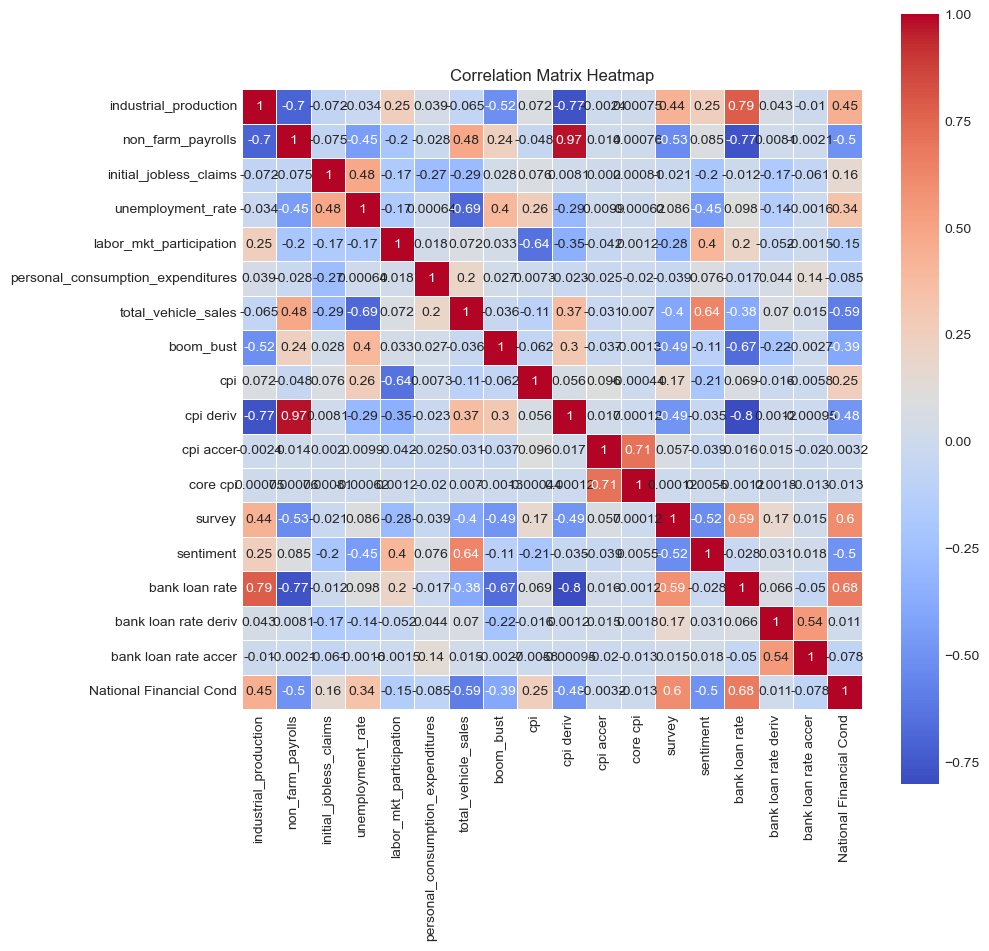

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_real_activity_indicator is the DataFrame you want to visualize correlations for

# Compute the correlation matrix
corr_matrix = df_concate_process1.corr()

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Y-variable

Text(0, 0.5, 'Frequency')

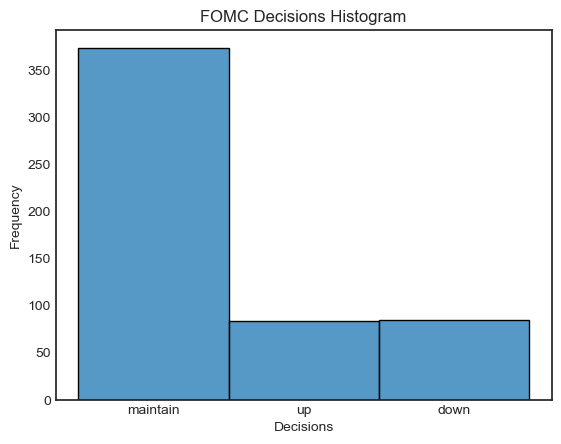

In [ ]:
Fed_effective = fred.get_series('FEDFUNDS')
Fed_change = Fed_effective.diff(1).dropna()
df_Fed_change = pd.DataFrame(Fed_change, columns = ['Rate Change (bps)'])
df_hist_fed_change = pd.DataFrame(Fed_change, columns = ['Rate Change (bps)'])
df_Fed_change['Decision'] = np.where(abs(df_Fed_change['Rate Change (bps)']) < 0.2, 'maintain',
                                     np.where(df_Fed_change['Rate Change (bps)'] > 0.2, 'up', 'down'))


df_hist_fed_change = df_hist_fed_change[df_hist_fed_change.index >= '1978-01-01']
df_hist_fed_change = df_hist_fed_change[df_hist_fed_change.index <= '2023-02-01']


df_Fed_change = df_Fed_change[df_Fed_change.index >= '1978-02-01' ]
df_Fed_change = df_Fed_change[ df_Fed_change.index <= '2023-03-01']
sns.histplot(data=df_Fed_change, x='Decision', discrete=True)
# Set the title and labels
plt.title('FOMC Decisions Histogram')
plt.xlabel('Decisions')
plt.ylabel('Frequency')
# Show the plot


plt.plot(Fed_effective)
plt.xlabel('Time')
plt.ylabel('Rate %')
plt.axvline(datetime.datetime(1978, 1, 1), linestyle='--', color = 'red')
plt.title('Federal Fund Effective Rate')
plt.show()


#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
# Plot Fed_effective on the first subplot
#ax1.plot(Fed_effective)
#ax1.set_title('Fed Effective')
# Plot industrial_production on the second subplot
#ax2.plot(X['industrial_production'])
#ax2.set_title('Industrial Production')
# Display the subplots
#plt.show()

Datas: X = df_concate_process1, Y = df_Fed_change['Decision']




# Train Validation Test split

In [ ]:
X = df_concate_process1
X['lag(Y)'] = df_hist_fed_change
Y = df_Fed_change['Decision']

#6-3-1
total_length = X.shape[0]
Cut_off_train = int(total_length * 0.6)
Cut_off_valid = int(total_length * 0.8)

# Train 0 - 324
# Valid 325 - 433
# Test  433 - 542

# 1978-01-01 ~ 2005-01-01
X_train  = X.iloc[ :Cut_off_train, :]
Y_train  = Y.iloc[ :Cut_off_train]
print(Y_train.value_counts())


# 2005-02-01 ~ 2014-01-01
X_valid  = X.iloc[ Cut_off_train:Cut_off_valid, :]
Y_valid  = Y.iloc[Cut_off_train:Cut_off_valid]
print(Y_valid.value_counts())


# 2014-02-01 ~ 2023-02-01
X_test  = X.iloc[ Cut_off_valid:, :]
Y_test  = Y.iloc[ Cut_off_valid:]
print(Y_test.value_counts())


maintain    191
down         69
up           65
Name: Decision, dtype: int64
maintain    90
down        11
up           7
Name: Decision, dtype: int64
maintain    93
up          11
down         5
Name: Decision, dtype: int64


 Standarization

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)


# Create a label encoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the target variable
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_valid_encoded = label_encoder.transform(Y_valid)
Y_test_encoded = label_encoder.transform(Y_test)

#down = 0 maintain = 1, up = 2

# LASSO Feature Selection

In [ ]:
headers = []
for col in X:
  headers.append(col)

X = df_concate_process1
Y = df_Fed_change['Decision']

Generalized_scaler = StandardScaler()
X_scaled = Generalized_scaler.fit_transform(X)


['lag(Y)', 'bank loan rate', 'cpi accer', 'labor_mkt_participation', 'survey', 'core cpi', 'personal_consumption_expenditures', 'sentiment', 'cpi', 'industrial_production', 'unemployment_rate', 'bank loan rate accer', 'cpi deriv', 'initial_jobless_claims', 'boom_bust', 'total_vehicle_sales', 'bank loan rate deriv', 'National Financial Cond', 'non_farm_payrolls']


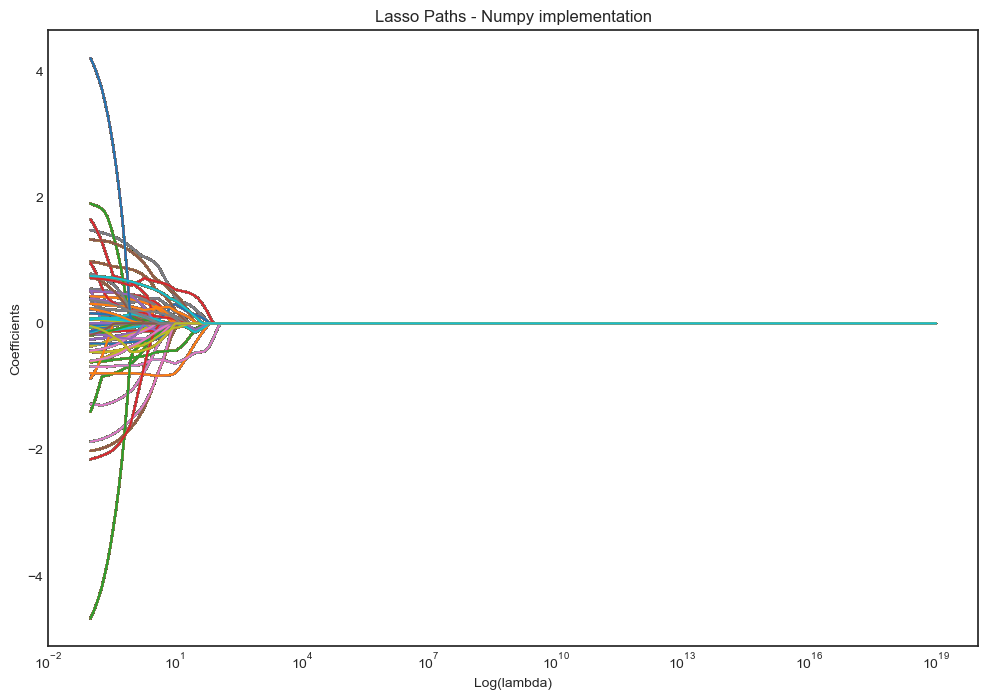

In [ ]:
%matplotlib inline
plt.style.use('seaborn-white')
model = LogisticRegression(penalty="l1", solver = 'liblinear', tol= 1e-4, max_iter = int(1e6))

lamda = np.logspace(0,20,300)/10
coefs_ = []
for c in lamda:
    model.set_params(C=1/c)
    model.fit(X_scaled, Y.ravel())
    coefs_.append(model.coef_.ravel().copy())

coefs_ = np.array(coefs_)
n,_ = coefs_.shape
plt.figure(figsize = (12,8))
for i in range(n):
    plt.plot(lamda, coefs_)
plt.xscale('log')
plt.xlabel('Log(lambda)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')

zeros = []


# Loops through all the paths
for i in range(0, len(lamda)):

  # Loops through the values in the path
  for j in range(0,X_scaled.shape[1]):

    # When the path equals zero and is not in the list add it to the list
    if coefs_[i][j] == 0:
      if not headers[j] in zeros:
        zeros.append(headers[j])

# Reverses the list to represent a hierarchy of importance in descending order
zeros.reverse()
print(zeros)

# Model Fitting With All Features:

- Linear: Logistic, LDA
- Non-Linear: QDA, SVM, KNN, LSTM, XGBOOST, Random Forest
  

In [ ]:
tscv = TimeSeriesSplit(n_splits=2)

### Logistic

In [ ]:
lr       = LogisticRegression( max_iter = 10000)
lr.fit(X_train_scaled,Y_train_encoded)

LogisticRegression(max_iter=10000)

In [ ]:
# Insample
Y_train_hat = lr.predict(X_train_scaled)
Y_train_hat_prob = lr.predict_proba(X_train_scaled)
train_accuracy   = accuracy_score(Y_train_encoded, Y_train_hat)*100
train_auc_roc    = roc_auc_score(Y_train_encoded, Y_train_hat_prob, multi_class='ovr', average='macro') * 100

print('For in-sample subtrain set:')

print('Accuracy: %.4f %%' % train_accuracy)
print('AUC: %.4f %%' % train_auc_roc)

print(classification_report(Y_train_encoded, Y_train_hat, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat))


print('---------------------------------------------------------------')
# Validation
Y_valid_hat = lr.predict(X_valid_scaled)
Y_valid_hat_prob = lr.predict_proba(X_valid_scaled)
valid_accuracy   = accuracy_score(Y_valid_encoded, Y_valid_hat)*100
valid_auc_roc    = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy)
print('AUC: %.4f %%' % valid_auc_roc)

print('---------------------------------------------------------------')
print(classification_report(Y_valid_encoded, Y_valid_hat, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat))

For in-sample subtrain set:
Accuracy: 71.3846 %
AUC: 85.5266 %
              precision    recall  f1-score   support

           0   0.714286  0.507246  0.593220        69
           1   0.714286  0.890052  0.792541       191
           2   0.710526  0.415385  0.524272        65

    accuracy                       0.713846       325
   macro avg   0.713033  0.604228  0.636678       325
weighted avg   0.713534  0.713846  0.696570       325

0.6042277827390506
---------------------------------------------------------------
For validation set:
Accuracy: 83.3333 %
AUC: 62.4566 %
---------------------------------------------------------------
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        11
           1   0.833333  1.000000  0.909091        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.833333       108
   macro avg   0.277778  0.333333  0.303030       108
weighted avg   0.694444  0.8

/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


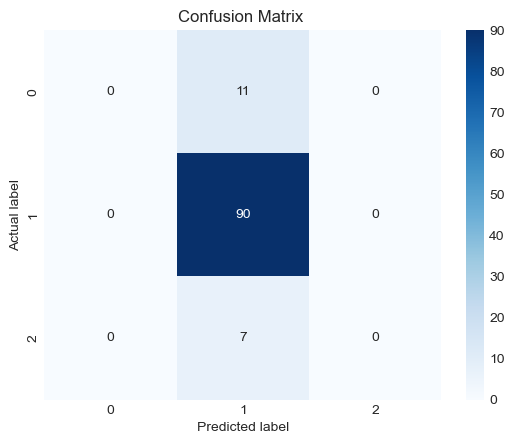

In [ ]:
conf_mat_lr = confusion_matrix(Y_valid_encoded, Y_valid_hat)
sns.heatmap(conf_mat_lr, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### LDA

In [ ]:
results = []
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

param_grid = {
    'ldasolver': ['lsqr', 'eigen'],
    'ldashrinkage': [None, 'auto', 0.1, 0.4, 0.7, 0.9]
}

for shrinkage in param_grid['ldashrinkage']:
    for solver in param_grid['ldasolver']:
        lda = LinearDiscriminantAnalysis(shrinkage=shrinkage, solver=solver)
        pipe.set_params(lda=lda)
        pipe.fit(X_train_scaled, Y_train_encoded)
        Y_pred_lda = pipe.predict(X_valid_scaled)
        accuracy = (Y_pred_lda == Y_valid_encoded).mean()
        results.append((shrinkage, solver, accuracy))



#lda = LinearDiscriminantAnalysis()
#lda.set_params(solver='svd')
#lda.fit(X_train_scaled, Y_train_encoded)
#Y_pred_lda = lda.predict(X_valid_scaled)
#accuracy = (Y_pred_lda == Y_valid_encoded).mean()
#results.append(('None', 'svd', accuracy))

In [ ]:
df = pd.DataFrame(results, columns=['shrinkage','solver', 'accuracy'])
df

,shrinkage,solver,accuracy
0,None,lsqr,0.805556
1,None,eigen,0.805556
2,auto,lsqr,0.814815
3,auto,eigen,0.814815
4,0.1,lsqr,0.814815
5,0.1,eigen,0.814815
6,0.4,lsqr,0.787037
7,0.4,eigen,0.787037
8,0.7,lsqr,0.777778
9,0.7,eigen,0.777778


In [ ]:
## Best parameters: shrinkage = None, solver = svd, accuracy = 0.842593
lda_model = LinearDiscriminantAnalysis()
lda_model.set_params(solver='svd')
lda_model.fit(X_train_scaled, Y_train_encoded)


Y_train_hat_lda = lda_model.predict(X_train_scaled)
Y_train_hat_prob_lda = lda_model.predict_proba(X_train_scaled)
train_accuracy_lda = accuracy_score(Y_train_encoded, Y_train_hat_lda) * 100
train_auc_roc_lda = roc_auc_score(Y_train_encoded, Y_train_hat_prob_lda, multi_class='ovr', average='macro') * 100
print('For in-sample subtrain set:')
print('Accuracy: %.4f %%' % train_accuracy_lda)
print('AUC: %.4f %%' % train_auc_roc_lda)

print(classification_report(Y_train_encoded, Y_train_hat_lda, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_lda))

print('---------------------------------------')
Y_valid_hat_lda = lda_model.predict(X_valid_scaled)
Y_valid_hat_prob_lda = lda_model.predict_proba(X_valid_scaled)
valid_accuracy_lda = accuracy_score(Y_valid_encoded, Y_valid_hat_lda) * 100
valid_auc_roc_lda = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_lda, multi_class='ovr', average='macro') * 100
print('For validation set:')
print('Accuracy: %.4f %%' % valid_accuracy_lda)
print('AUC: %.4f %%' % valid_auc_roc_lda)

print(classification_report(Y_valid_encoded, Y_valid_hat_lda, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_lda))



For in-sample subtrain set:
Accuracy: 70.4615 %
AUC: 84.6793 %
              precision    recall  f1-score   support

           0   0.711111  0.463768  0.561404        69
           1   0.710638  0.874346  0.784038       191
           2   0.666667  0.461538  0.545455        65

    accuracy                       0.704615       325
   macro avg   0.696139  0.599884  0.630299       325
weighted avg   0.701944  0.704615  0.689054       325

0.5998840424062367
---------------------------------------
For validation set:
Accuracy: 80.5556 %
AUC: 75.2005 %
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        11
           1   0.828571  0.966667  0.892308        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.805556       108
   macro avg   0.276190  0.322222  0.297436       108
weighted avg   0.690476  0.805556  0.743590       108

0.32222222222222224


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


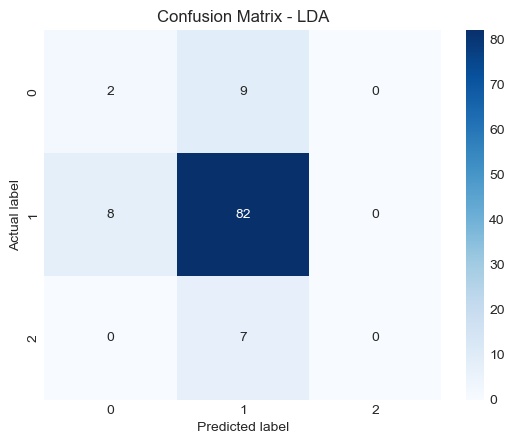

In [ ]:
conf_mat_lda = confusion_matrix(Y_valid_encoded, Y_pred_lda)
sns.heatmap(conf_mat_lda, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix - LDA')
plt.show()

### QDA

In [ ]:
model = QuadraticDiscriminantAnalysis()

tscv = TimeSeriesSplit(n_splits=2)

# Parameters
reg_param = [1 / x for x in range(1, 1000)]
#priors = [None]  # You can add custom prior probabilities for classes here, or keep it None
#store_covariance = [True, False]
#tol = [1e-4, 1e-3, 1e-2, 1e-1]
#n_features_in = [x for x in range(1, 20)]

params = {
    'reg_param': reg_param,
#    'priors': priors,
#    'store_covariance': store_covariance,
#    'tol': tol
#    'n_features_in_': n_features_in
}

grid = GridSearchCV(model, params, cv=tscv, scoring='f1_weighted')
grid.fit(X_train_scaled, Y_train_encoded)
qda_model = grid.best_estimator_


In [ ]:
qda_model.fit(X_train_scaled, Y_train_encoded)

Y_train_hat_qda = qda_model.predict(X_train_scaled)
Y_train_hat_prob_qda = qda_model.predict_proba(X_train_scaled)
train_accuracy_qda = accuracy_score(Y_train_encoded, Y_train_hat_qda) * 100
train_auc_roc_qda = roc_auc_score(Y_train_encoded, Y_train_hat_prob_qda, multi_class='ovr', average='macro') * 100
print('For in-sample subtrain set:')
print('Accuracy: %.4f %%' % train_accuracy_qda)
print('AUC: %.4f %%' % train_auc_roc_qda)

print(classification_report(Y_train_encoded, Y_train_hat_qda, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_qda))

print('---------------------------------------')
Y_valid_hat_qda = qda_model.predict(X_valid_scaled)
Y_valid_hat_prob_qda = qda_model.predict_proba(X_valid_scaled)
valid_accuracy_qda   = accuracy_score(Y_valid_encoded, Y_valid_hat_qda)*100
valid_auc_roc_qda    = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_qda, multi_class='ovr', average='macro') * 100
print('For validation set:')
print('Accuracy: %.4f %%' % valid_accuracy_qda)
print('AUC: %.4f %%' % valid_auc_roc_qda)


print(classification_report(Y_valid_encoded, Y_valid_hat_qda, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_qda))

For in-sample subtrain set:
Accuracy: 68.9231 %
AUC: 82.3853 %
              precision    recall  f1-score   support

           0   0.857143  0.347826  0.494845        69
           1   0.688259  0.890052  0.776256       191
           2   0.600000  0.461538  0.521739        65

    accuracy                       0.689231       325
   macro avg   0.715134  0.566472  0.597613       325
weighted avg   0.706463  0.689231  0.665607       325

0.5664723015053087
---------------------------------------
For validation set:
Accuracy: 79.6296 %
AUC: 80.7490 %
              precision    recall  f1-score   support

           0   0.250000  0.181818  0.210526        11
           1   0.840000  0.933333  0.884211        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.796296       108
   macro avg   0.363333  0.371717  0.364912       108
weighted avg   0.725463  0.796296  0.758285       108

0.3717171717171717


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


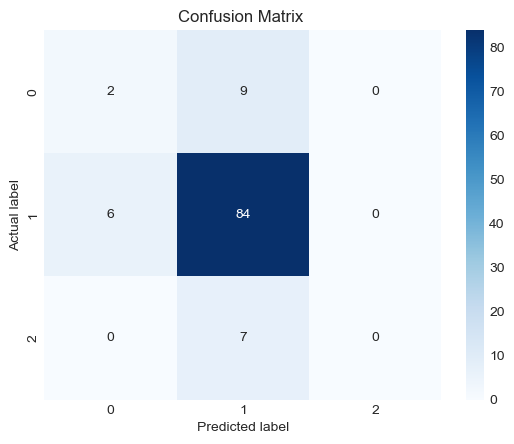

In [ ]:
conf_mat_qda = confusion_matrix(Y_valid_encoded, Y_valid_hat_qda)
sns.heatmap(conf_mat_qda, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### KNN

In [ ]:
max_k = 100
k_range = np.arange(max_k, 0, -1)
k_inverse = 1/k_range

train_error_rate = []
valid_error_rate = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train_scaled, Y_train_encoded)
  Y_train_hat_knn = knn.predict(X_train_scaled)
  Y_valid_hat_knn = knn.predict(X_valid_scaled)
  train_error = 1 - np.mean(Y_train_hat_knn == Y_train_encoded)
  valid_error = 1 - np.mean(Y_valid_hat_knn == Y_valid_encoded)
  train_error_rate.append(train_error)
  valid_error_rate.append(valid_error)


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

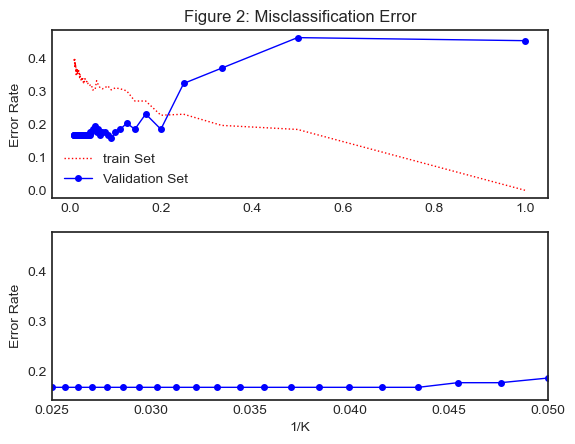

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(k_inverse, train_error_rate, color = 'red',linestyle = 'dotted', linewidth=1, markersize=4, label = 'train Set')
plt.plot(k_inverse, valid_error_rate, '-bo', linewidth=1, markersize=4, label = 'Validation Set')
plt.title('Figure 2: Misclassification Error')
plt.legend()
plt.ylabel('Error Rate')
#plt.xlabel('1/K')
plt.subplot(2, 1, 2)
plt.plot(k_inverse, valid_error_rate, '-bo', linewidth=1, markersize=4, label = 'Validation Set')
plt.ylabel('Error Rate')
plt.xlim([0.025, 0.05])
plt.xlabel("1/K")
plt.show()


In figure 2, the blue line is the KNN error rate when predicting the validation set and the red line is the KNN error rate when predicting the subtraining set. Since the red line is trival as KNN, being fitted with subtraining set, decrease the number of neighbourhood will result a perfit fit, but subject to overfit. We will focus on the blue line.

In [ ]:
min_error = np.min(valid_error_rate)
min_error_indices = np.where(valid_error_rate == min_error)[0]
min_error_K = [k_range[i] for i in min_error_indices]
print("The minimal error rate is: ", min_error)
print("Optimal K is: ", min_error_K)

The minimal error rate is:  0.15740740740740744
Optimal K is:  [11]


The minimal error rate occurs when K = 24 and 23 with an minimal error being 0157

In [ ]:
Historical_validation_AUC = []
Historical_k = []
for k in min_error_K:
  print('')
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, Y_train_encoded)
  print(f'KNN (K={k})')
  Y_train_hat_knn = knn.predict(X_train_scaled)
  Y_train_hat_prob_knn = knn.predict_proba(X_train_scaled)
  train_accuracy_knn = accuracy_score(Y_train_encoded, Y_train_hat_knn) * 100
  train_roc_auc_knn = roc_auc_score(Y_train_encoded, Y_train_hat_prob_knn, multi_class='ovr', average='macro') * 100
#  train_cm_knn = confusion_matrix(Y_train_encoded, Y_train_hat_knn)
#  train_fpr_knn = (train_cm_knn[0, 1] / (train_cm_knn[0, 1] + train_cm_knn[0, 0])) * 100
#  train_fnr_knn = (train_cm_knn[1, 0] / (train_cm_knn[1, 0] + train_cm_knn[1, 1])) * 100
  print('For in-sample train set:')
#  print('Confusion Matrix:\n', train_cm_knn)
  print('Accuracy: %.4f %%' % train_accuracy_knn)
  print('AUC: %.4f %%' % train_roc_auc_knn)
#  print('False Positive Rate (FPR): %.4f %%' % train_fpr_knn)
#  print('False Negative Rate (FNR): %.4f %%' % train_fnr_knn)
  print('---------------------------------------')
  Y_valid_hat_knn = knn.predict(X_valid_scaled)
  Y_valid_hat_prob_knn = knn.predict_proba(X_valid_scaled)
  valid_accuracy_knn = accuracy_score(Y_valid_encoded, Y_valid_hat_knn) * 100
  valid_roc_auc_knn = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_knn, multi_class='ovr', average='macro') * 100
  Historical_validation_AUC.append(valid_roc_auc_knn)
  Historical_k.append(k)


#  valid_cm_knn = confusion_matrix(Y_valid_encoded, Y_valid_hat_knn)
#  valid_fpr_knn = (valid_cm_knn[0, 1] / (valid_cm_knn[0, 1] + valid_cm_knn[0, 0])) * 100
#  valid_fnr_knn = (valid_cm_knn[1, 0] / (valid_cm_knn[1, 0] + valid_cm_knn[1, 1])) * 100
  print('For valid set:')
#  print('Confusion Matrix:\n', valid_cm_knn)
  print('Accuracy: %.4f %%' % valid_accuracy_knn)
  print('AUC: %.4f %%' % valid_roc_auc_knn)
#  print('False Positive Rate (FPR): %.4f %%' % valid_fpr_knn)
#  print('False Negative Rate (FNR): %.4f %%' % valid_fnr_knn)



KNN (K=11)
For in-sample train set:
Accuracy: 69.5385 %
AUC: 86.7938 %
---------------------------------------
For valid set:
Accuracy: 84.2593 %
AUC: 66.5588 %


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

Therefore, we will keep K = 11

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_scaled, Y_train_encoded)
print(f'KNN (K={k})')
Y_train_hat_knn = knn.predict(X_train_scaled)
Y_train_hat_prob_knn = knn.predict_proba(X_train_scaled)
train_accuracy_knn = accuracy_score(Y_train_encoded, Y_train_hat_knn) * 100
train_roc_auc_knn = roc_auc_score(Y_train_encoded, Y_train_hat_prob_knn, multi_class='ovr', average='macro') * 100

print('For in-sample train set:')

print('Accuracy: %.4f %%' % train_accuracy_knn)
print('AUC: %.4f %%' % train_roc_auc_knn)

print(classification_report(Y_train_encoded, Y_train_hat_knn, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_knn))


print('---------------------------------------')
Y_valid_hat_knn = knn.predict(X_valid_scaled)
Y_valid_hat_prob_knn = knn.predict_proba(X_valid_scaled)
valid_accuracy_knn = accuracy_score(Y_valid_encoded, Y_valid_hat_knn) * 100
valid_roc_auc_knn = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_knn, multi_class='ovr', average='macro') * 100

print('For valid set:')

print('Accuracy: %.4f %%' % valid_accuracy_knn)
print('AUC: %.4f %%' % valid_roc_auc_knn)

print(classification_report(Y_valid_encoded, Y_valid_hat_knn, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_knn))

KNN (K=11)
For in-sample train set:
Accuracy: 69.5385 %
AUC: 86.7938 %
              precision    recall  f1-score   support

           0   0.596491  0.492754  0.539683        69
           1   0.737557  0.853403  0.791262       191
           2   0.617021  0.446154  0.517857        65

    accuracy                       0.695385       325
   macro avg   0.650356  0.597437  0.616267       325
weighted avg   0.683500  0.695385  0.683169       325

0.5974368702345029
---------------------------------------
For valid set:
Accuracy: 84.2593 %
AUC: 66.5588 %
              precision    recall  f1-score   support

           0   0.571429  0.363636  0.444444        11
           1   0.861386  0.966667  0.910995        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.842593       108
   macro avg   0.477605  0.443434  0.451813       108
weighted avg   0.776023  0.842593  0.804430       108

0.44343434343434346


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

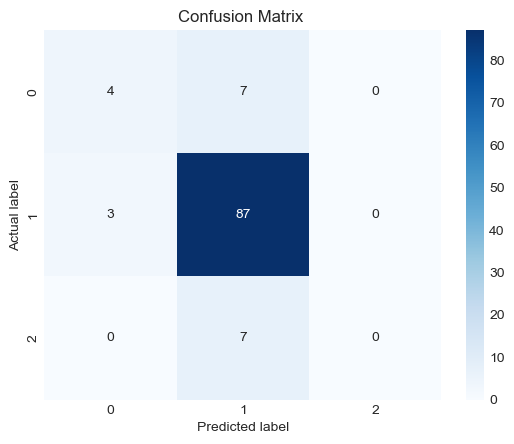

In [ ]:
conf_mat_knn = confusion_matrix(Y_valid_encoded, Y_valid_hat_knn)
sns.heatmap(conf_mat_knn, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### SVM Polynomial

In [ ]:
#X_concat = np.concatenate((X_train_scaled, X_valid_scaled), axis = 0)
#Y_concat = np.concatenate((Y_train_encoded, Y_valid_encoded), axis = 0)


tscv = TimeSeriesSplit(n_splits=2)

svm_poly = SVC(kernel='poly', probability=True)
param_grid_poly = {
    "C": np.arange(1, 11),
    "gamma": np.logspace(-3, -1, 5),
    #"gamma" : [1/x for x in range(1,100)],
    "degree": np.arange(2, 6),
    "coef0": np.linspace(-1, 1, 11)
}

grid_search_poly = GridSearchCV(svm_poly, param_grid_poly, cv=tscv, scoring='f1_weighted', n_jobs= -1)
grid_search_poly.fit(X_train_scaled, Y_train_encoded)

print(grid_search_poly.best_estimator_)
print('degree is', grid_search_poly.best_estimator_.degree)

SVC(C=5, coef0=-1.0, degree=5, gamma=0.0031622776601683794, kernel='poly',
    probability=True)
degree is 5


In [ ]:
svm_poly = grid_search_poly.best_estimator_.fit(X_train_scaled, Y_train_encoded)

Y_train_hat_poly = svm_poly.predict(X_train_scaled)
Y_train_hat_prob_poly = svm_poly.predict_proba(X_train_scaled)
train_accuracy_poly = accuracy_score(Y_train_encoded, Y_train_hat_poly) * 100
train_auc_roc_poly = roc_auc_score(Y_train_encoded, Y_train_hat_prob_poly, multi_class='ovr', average='macro') * 100
print('For in-sample subtrain set:')
print('Accuracy: %.4f %%' % train_accuracy_poly)
print('AUC: %.4f %%' % train_auc_roc_poly)

print(classification_report(Y_train_encoded, Y_train_hat_poly, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_poly))


print('---------------------------------------')
Y_valid_hat_poly = svm_poly.predict(X_valid_scaled)
Y_valid_hat_prob_poly = svm_poly.predict_proba(X_valid_scaled)
valid_accuracy_poly   = accuracy_score(Y_valid_encoded, Y_valid_hat_poly)*100
valid_auc_roc_poly    = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_poly, multi_class='ovr', average='macro') * 100
print('For validation set:')
print('Accuracy: %.4f %%' % valid_accuracy_poly)
print('AUC: %.4f %%' % valid_auc_roc_poly)


print(classification_report(Y_valid_encoded, Y_valid_hat_poly, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_poly))

For in-sample subtrain set:
Accuracy: 65.5385 %
AUC: 74.2634 %
              precision    recall  f1-score   support

           0   0.609756  0.362319  0.454545        69
           1   0.683128  0.869110  0.764977       191
           2   0.536585  0.338462  0.415094        65

    accuracy                       0.655385       325
   macro avg   0.609823  0.523297  0.544872       325
weighted avg   0.638242  0.655385  0.629093       325

0.5232967755617426
---------------------------------------
For validation set:
Accuracy: 71.2963 %
AUC: 51.6983 %
              precision    recall  f1-score   support

           0   0.473684  0.818182  0.600000        11
           1   0.883117  0.755556  0.814371        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.712963       108
   macro avg   0.452267  0.524579  0.471457       108
weighted avg   0.784176  0.712963  0.739754       108

0.5245791245791246


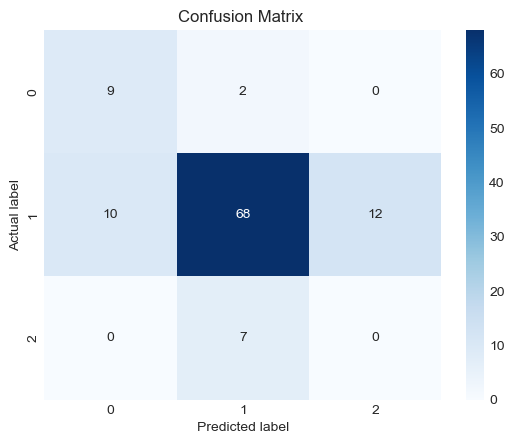

In [ ]:
conf_mat_svm = confusion_matrix(Y_valid_encoded, Y_valid_hat_poly)
sns.heatmap(conf_mat_svm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### Randomized Forest

In [ ]:
param_dist = {
    'n_estimators': np.arange(200, 500, 100),
    'max_depth': np.arange(1, 40)
}

rf_clf = RandomForestClassifier()

# Full Features
random_search_rf = RandomizedSearchCV(
    rf_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring=make_scorer(f1_score, average='macro'),
    cv=tscv,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train_scaled, Y_train_encoded)
best_params = random_search_rf.best_params_
print('', best_params)

 {'n_estimators': 300, 'max_depth': 2}


In [ ]:
# In-sample
Y_train_hat_rf = random_search_rf.predict(X_train_scaled)
Y_train_hat_prob_rf = random_search_rf.predict_proba(X_train_scaled)
train_accuracy_rf = accuracy_score(Y_train_encoded, Y_train_hat_rf) * 100
train_auc_roc_rf = roc_auc_score(Y_train_encoded, Y_train_hat_prob_rf, multi_class='ovr', average='macro') * 100

print('For in-sample train set:')

print('Accuracy: %.4f %%' % train_accuracy_rf)
print('AUC: %.4f %%' % train_auc_roc_rf)

print(classification_report(Y_train_encoded, Y_train_hat_rf, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_rf))

print('---------------------------------------------------------------')

# Validation
Y_valid_hat_rf = random_search_rf.predict(X_valid_scaled)
Y_valid_hat_prob_rf = random_search_rf.predict_proba(X_valid_scaled)
valid_accuracy_rf = accuracy_score(Y_valid_encoded, Y_valid_hat_rf) * 100
valid_auc_roc_rf = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_rf, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy_rf)
print('AUC: %.4f %%' % valid_auc_roc_rf)


print(classification_report(Y_valid_encoded, Y_valid_hat_rf, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_rf))

For in-sample train set:
Accuracy: 68.3077 %
AUC: 84.5764 %
              precision    recall  f1-score   support

           0   0.791667  0.275362  0.408602        69
           1   0.679245  0.942408  0.789474       191
           2   0.638889  0.353846  0.455446        65

    accuracy                       0.683077       325
   macro avg   0.703267  0.523872  0.551174       325
weighted avg   0.695042  0.683077  0.641806       325

0.5238722832166948
---------------------------------------------------------------
For validation set:
Accuracy: 85.1852 %
AUC: 53.9798 %
              precision    recall  f1-score   support

           0   1.000000  0.181818  0.307692        11
           1   0.849057  1.000000  0.918367        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.851852       108
   macro avg   0.616352  0.393939  0.408687       108
weighted avg   0.809399  0.851852  0.796645       108

0.393939393939394


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


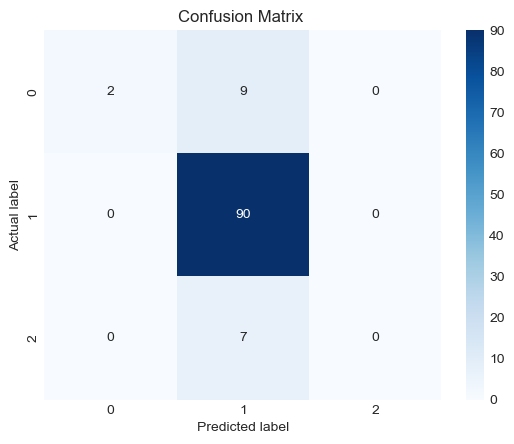

In [ ]:
conf_mat_rf = confusion_matrix(Y_valid_encoded, Y_valid_hat_rf)
sns.heatmap(conf_mat_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### XGBOOSTING

In [ ]:
param_dist_xgb = {
    'n_estimators': np.arange(200, 500, 100),
    'max_depth': np.arange(1, 40),
    'gamma': [x for x in range(1,10)],
    'alpha': [1/x for x in range(1,1000)],
    'lambda':[1/x for x in range(1,1000)],
    'min_child_weight': [x for x in range(1,10)]
}

xgb_classifier = xgb.XGBClassifier(learning_rate = 0.1)

# Full Features
random_search_xgb = RandomizedSearchCV(
    xgb_classifier,
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring= 'f1_weighted',
    cv=tscv,
    n_jobs=-1,
    random_state=42
)

# Full Features
random_search_xgb.fit(X_train_scaled, Y_train_encoded)
best_params_xgb = random_search_xgb.best_params_
print('For full predictors:', best_params_xgb)

For full predictors: {'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 1, 'lambda': 0.0010309278350515464, 'gamma': 2, 'alpha': 0.0023752969121140144}


In [ ]:
# In-sample
Y_train_hat_xgb = random_search_xgb.predict(X_train_scaled)
Y_train_hat_prob_xgb = random_search_xgb.predict_proba(X_train_scaled)
train_accuracy_xgb = accuracy_score(Y_train_encoded, Y_train_hat_xgb) * 100
train_auc_roc_xgb = roc_auc_score(Y_train_encoded, Y_train_hat_prob_xgb, multi_class='ovr', average='macro') * 100

print('For in-sample subtrain set:')
print('Accuracy: %.4f %%' % train_accuracy_xgb)
print('AUC: %.4f %%' % train_auc_roc_xgb)

print(classification_report(Y_train_encoded, Y_train_hat_xgb, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_xgb))

print('---------------------------------------------------------------')

# Validation
Y_valid_hat_xgb = random_search_xgb.predict(X_valid_scaled)
Y_valid_hat_prob_xgb = random_search_xgb.predict_proba(X_valid_scaled)
valid_accuracy_xgb = accuracy_score(Y_valid_encoded, Y_valid_hat_xgb) * 100
valid_auc_roc_xgb = roc_auc_score(Y_valid, Y_valid_hat_prob_xgb, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy_xgb)
print('AUC: %.4f %%' % valid_auc_roc_xgb)


print(classification_report(Y_valid_encoded, Y_valid_hat_xgb, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_xgb))

For in-sample subtrain set:
Accuracy: 70.7692 %
AUC: 87.8832 %
              precision    recall  f1-score   support

           0   0.679245  0.521739  0.590164        69
           1   0.737069  0.895288  0.808511       191
           2   0.575000  0.353846  0.438095        65

    accuracy                       0.707692       325
   macro avg   0.663771  0.590291  0.612257       325
weighted avg   0.692379  0.707692  0.688071       325

0.5902910807987066
---------------------------------------------------------------
For validation set:
Accuracy: 87.0370 %
AUC: 85.6964 %
              precision    recall  f1-score   support

           0   0.666667  0.727273  0.695652        11
           1   0.895833  0.955556  0.924731        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.870370       108
   macro avg   0.520833  0.560943  0.540128       108
weighted avg   0.814429  0.870370  0.841463       108

0.560942760942761


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


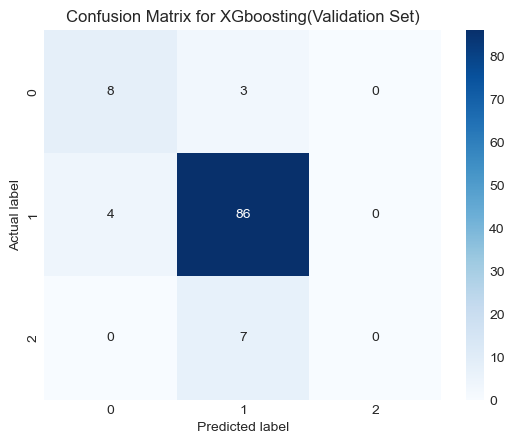

In [ ]:
conf_mat_xgb = confusion_matrix(Y_valid_encoded, Y_valid_hat_xgb)
sns.heatmap(conf_mat_xgb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix for XGboosting(Validation Set)')
plt.show()

For test set:
Accuracy: 85.3211 %
AUC: 84.3193 %
              precision    recall  f1-score   support

           0   0.500000  0.200000  0.285714         5
           1   0.859813  0.989247  0.920000        93
           2   0.000000  0.000000  0.000000        11

    accuracy                       0.853211       109
   macro avg   0.453271  0.396416  0.401905       109
weighted avg   0.756538  0.853211  0.798060       109

0.396415770609319


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


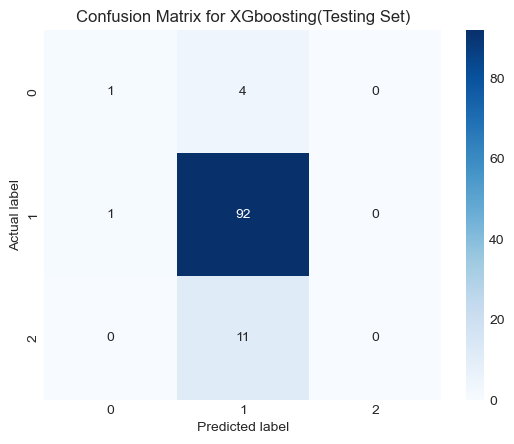

In [ ]:
Y_test_hat_xgb = random_search_xgb.predict(X_test_scaled)
Y_test_hat_prob_xgb = random_search_xgb.predict_proba(X_test_scaled)
test_accuracy_xgb = accuracy_score(Y_test_encoded, Y_test_hat_xgb) * 100
test_auc_roc_xgb = roc_auc_score(Y_test, Y_test_hat_prob_xgb, multi_class='ovr', average='macro') * 100

print('For test set:')

print('Accuracy: %.4f %%' % test_accuracy_xgb)
print('AUC: %.4f %%' % test_auc_roc_xgb)


print(classification_report(Y_test_encoded, Y_test_hat_xgb, digits=6))
print(balanced_accuracy_score(Y_test_encoded, Y_test_hat_xgb))


conf_mat_xgb_test = confusion_matrix(Y_test_encoded, Y_test_hat_xgb)
sns.heatmap(conf_mat_xgb_test, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix for XGboosting(Testing Set)')
plt.show()

### Neural Net Work

In [ ]:
Y_train_onehot   = to_categorical(Y_train_encoded,   num_classes=3)
Y_valid_onehot   = to_categorical(Y_valid_encoded, num_classes=3)

In [ ]:
#def create_NN_model():
#  NN = Sequential()#
#
#  NN.add(Dense(300, activation="relu", input_shape = X_train_scaled.shape[1:]))
#  NN.add(Dropout(0.5))
#  NN.add(Dense(100, activation="relu"))
#  NN.add(Dropout(0.5))
#  NN.add(Dense(3, activation="softmax"))
#  optimizer = Adam(learning_rate=0.0001)
#  NN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#
#  return NN

#NN_model = create_NN_model()
#
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)
#
#NN_history = NN_model.fit(X_train_scaled, Y_train_onehot,
#                            epochs=200,
#                            batch_size=15,
#                            validation_data=(X_valid_scaled, Y_valid_onehot),
#                            callbacks=[early_stopping])






def build_network(hidden=2, neurons=25, shape=[X_train_scaled.shape[1]], rate=0.001, drop=0.5):
  model = Sequential()
  model.add(keras.layers.InputLayer(input_shape=shape))

  for i in range(hidden):
    model.add(Dense(neurons, activation = 'relu'))
    model.add(Dropout(drop))

  model.add(Dense(3,activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=rate)
  model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

params = {'hidden': [2,3,4,5],
          'neurons':[50, 100, 150, 200, 250, 300],
          'rate':reciprocal(3e-4,3e-1),
          'drop':uniform(0.1,0.5)}

cl = keras.wrappers.scikit_learn.KerasClassifier(build_network)
cl.fit(X_train_scaled, Y_train_onehot, epochs = 50, validation_data=(X_valid_scaled, Y_valid_onehot), batch_size=16, callbacks=[EarlyStopping(monitor='val_loss', patience=9)])

NN_model = RandomizedSearchCV(cl, params, n_iter=20, cv=tscv, verbose=2)
NN_model.fit(X_train_scaled, Y_train_onehot, epochs=50,  validation_data=(X_valid_scaled, Y_valid_onehot), callbacks=[EarlyStopping(monitor='val_loss', patience=9)], batch_size=20)

/var/folders/lk/r1pv7gcs7zv2103vh2sw8j840000gn/T/ipykernel_95462/142219288.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cl = keras.wrappers.scikit_learn.KerasClassifier(build_network)


Epoch 1/50


2023-05-02 18:01:19.473215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.3229 - accuracy: 0.3631

2023-05-02 18:01:20.680767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 56ms/step - loss: 1.3229 - accuracy: 0.3631 - val_loss: 1.1173 - val_accuracy: 0.1204
Epoch 2/50
21/21 [==============================] - 1s 25ms/step - loss: 1.1930 - accuracy: 0.4246 - val_loss: 0.8403 - val_accuracy: 0.5556
Epoch 3/50
21/21 [==============================] - 1s 25ms/step - loss: 1.1821 - accuracy: 0.4523 - val_loss: 0.7683 - val_accuracy: 0.7593
Epoch 4/50
21/21 [==============================] - 1s 25ms/step - loss: 1.0356 - accuracy: 0.5415 - val_loss: 0.7459 - val_accuracy: 0.7778
Epoch 5/50
21/21 [==============================] - 0s 24ms/step - loss: 0.9992 - accuracy: 0.5292 - val_loss: 0.7312 - val_accuracy: 0.7778
Epoch 6/50
21/21 [==============================] - 0s 23ms/step - loss: 0.9670 - accuracy: 0.5846 - val_loss: 0.7215 - val_accuracy: 0.7685
Epoch 7/50
21/21 [==============================] - 0s 23ms/step - loss: 0.9680 - accuracy: 0.5754 - val_loss: 0.6970 - val_accuracy: 0.7870
Epoch 8/50
21/21 [======

2023-05-02 18:01:30.813250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.5036 - accuracy: 0.3761

2023-05-02 18:01:31.985281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 193ms/step - loss: 1.5036 - accuracy: 0.3761 - val_loss: 1.2367 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 0s 66ms/step - loss: 1.2489 - accuracy: 0.4128 - val_loss: 0.8393 - val_accuracy: 0.7963
Epoch 3/50
6/6 [==============================] - 0s 54ms/step - loss: 1.1676 - accuracy: 0.4862 - val_loss: 1.4877 - val_accuracy: 0.1019
Epoch 4/50
6/6 [==============================] - 0s 62ms/step - loss: 1.2554 - accuracy: 0.4220 - val_loss: 1.0818 - val_accuracy: 0.5093
Epoch 5/50
6/6 [==============================] - 0s 72ms/step - loss: 1.1464 - accuracy: 0.4128 - val_loss: 1.6926 - val_accuracy: 0.1019
Epoch 6/50
6/6 [==============================] - 0s 43ms/step - loss: 1.0311 - accuracy: 0.4679 - val_loss: 3.3211 - val_accuracy: 0.1019
Epoch 7/50
6/6 [==============================] - 0s 48ms/step - loss: 1.3345 - accuracy: 0.4404 - val_loss: 1.1788 - val_accuracy: 0.1019
Epoch 8/50
6/6 [=====================

2023-05-02 18:01:35.248606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 52ms/step - loss: 1.1099 - accuracy: 0.4630
[CV] END drop=0.46719632798007704, hidden=4, neurons=100, rate=0.027876437355469113; total time=   5.0s
Epoch 1/50


2023-05-02 18:01:35.801282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.4786 - accuracy: 0.4147

2023-05-02 18:01:37.099980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 115ms/step - loss: 1.4786 - accuracy: 0.4147 - val_loss: 0.6198 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 51ms/step - loss: 1.2012 - accuracy: 0.4424 - val_loss: 0.8971 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 41ms/step - loss: 1.1304 - accuracy: 0.4286 - val_loss: 0.9111 - val_accuracy: 0.7870
Epoch 4/50
11/11 [==============================] - 0s 44ms/step - loss: 1.0421 - accuracy: 0.5023 - val_loss: 0.6980 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 40ms/step - loss: 1.1861 - accuracy: 0.5392 - val_loss: 0.8435 - val_accuracy: 0.8056
Epoch 6/50
11/11 [==============================] - 0s 30ms/step - loss: 1.1278 - accuracy: 0.4793 - val_loss: 0.7269 - val_accuracy: 0.8426
Epoch 7/50
11/11 [==============================] - 0s 32ms/step - loss: 1.0890 - accuracy: 0.5115 - val_loss: 0.4901 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:01:42.871066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 63ms/step - loss: 0.8133 - accuracy: 0.7963
[CV] END drop=0.46719632798007704, hidden=4, neurons=100, rate=0.027876437355469113; total time=   7.7s
Epoch 1/50


2023-05-02 18:01:43.414167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1657 - accuracy: 0.3303

2023-05-02 18:01:44.231956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 153ms/step - loss: 1.1657 - accuracy: 0.3303 - val_loss: 1.0081 - val_accuracy: 0.5463
Epoch 2/50
6/6 [==============================] - 0s 57ms/step - loss: 0.9800 - accuracy: 0.5229 - val_loss: 0.9502 - val_accuracy: 0.6019
Epoch 3/50
6/6 [==============================] - 0s 45ms/step - loss: 0.9054 - accuracy: 0.5596 - val_loss: 1.0327 - val_accuracy: 0.5093
Epoch 4/50
6/6 [==============================] - 0s 61ms/step - loss: 0.8682 - accuracy: 0.5688 - val_loss: 1.0265 - val_accuracy: 0.5278
Epoch 5/50
6/6 [==============================] - 0s 52ms/step - loss: 0.8138 - accuracy: 0.5780 - val_loss: 1.0817 - val_accuracy: 0.4630
Epoch 6/50
6/6 [==============================] - 0s 42ms/step - loss: 0.8262 - accuracy: 0.5780 - val_loss: 1.1089 - val_accuracy: 0.4630
Epoch 7/50
6/6 [==============================] - 0s 49ms/step - loss: 0.7876 - accuracy: 0.6422 - val_loss: 1.1509 - val_accuracy: 0.4074
Epoch 8/50
6/6 [=====================

2023-05-02 18:01:47.135796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 56ms/step - loss: 1.0474 - accuracy: 0.4352
[CV] END drop=0.3223750294010457, hidden=2, neurons=300, rate=0.0009084086562701814; total time=   4.2s
Epoch 1/50


2023-05-02 18:01:47.626187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0227 - accuracy: 0.4977

2023-05-02 18:01:48.614884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 91ms/step - loss: 1.0227 - accuracy: 0.4977 - val_loss: 0.5363 - val_accuracy: 0.8056
Epoch 2/50
11/11 [==============================] - 1s 45ms/step - loss: 0.9019 - accuracy: 0.5991 - val_loss: 0.5091 - val_accuracy: 0.8056
Epoch 3/50
11/11 [==============================] - 0s 35ms/step - loss: 0.8558 - accuracy: 0.6129 - val_loss: 0.5159 - val_accuracy: 0.7963
Epoch 4/50
11/11 [==============================] - 0s 31ms/step - loss: 0.7968 - accuracy: 0.6498 - val_loss: 0.6278 - val_accuracy: 0.7593
Epoch 5/50
11/11 [==============================] - 0s 28ms/step - loss: 0.7593 - accuracy: 0.6498 - val_loss: 0.5862 - val_accuracy: 0.7685
Epoch 6/50
11/11 [==============================] - 0s 29ms/step - loss: 0.7225 - accuracy: 0.6636 - val_loss: 0.5637 - val_accuracy: 0.7685
Epoch 7/50
11/11 [==============================] - 0s 29ms/step - loss: 0.7286 - accuracy: 0.6682 - val_loss: 0.6019 - val_accuracy: 0.7685
Epoch 8/50
11/11 [======

2023-05-02 18:01:52.228884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 43ms/step - loss: 0.5192 - accuracy: 0.8056
[CV] END drop=0.3223750294010457, hidden=2, neurons=300, rate=0.0009084086562701814; total time=   5.1s
Epoch 1/50


2023-05-02 18:01:52.764435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 256.9688 - accuracy: 0.3486

2023-05-02 18:01:54.118627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 219ms/step - loss: 256.9688 - accuracy: 0.3486 - val_loss: 17.0879 - val_accuracy: 0.8333
Epoch 2/50
6/6 [==============================] - 0s 82ms/step - loss: 18.8891 - accuracy: 0.2752 - val_loss: 33.2606 - val_accuracy: 0.8333
Epoch 3/50
6/6 [==============================] - 0s 68ms/step - loss: 61.7789 - accuracy: 0.3303 - val_loss: 46.3353 - val_accuracy: 0.1019
Epoch 4/50
6/6 [==============================] - 0s 54ms/step - loss: 51.2570 - accuracy: 0.3211 - val_loss: 107.9055 - val_accuracy: 0.1019
Epoch 5/50
6/6 [==============================] - 0s 41ms/step - loss: 8.5378 - accuracy: 0.3578 - val_loss: 1.9687 - val_accuracy: 0.0648
Epoch 6/50
6/6 [==============================] - 0s 56ms/step - loss: 17.1203 - accuracy: 0.3486 - val_loss: 1.0624 - val_accuracy: 0.0648
Epoch 7/50
6/6 [==============================] - 0s 48ms/step - loss: 6.3033 - accuracy: 0.3303 - val_loss: 0.8965 - val_accuracy: 0.8333
Epoch 8/50
6/6 [==========

2023-05-02 18:01:59.447228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 73ms/step - loss: 1.0975 - accuracy: 0.1852
[CV] END drop=0.14779309885643735, hidden=5, neurons=250, rate=0.07914320636529075; total time=   7.4s
Epoch 1/50


2023-05-02 18:02:00.149819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 200.7547 - accuracy: 0.3687

2023-05-02 18:02:01.985235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 147ms/step - loss: 200.7547 - accuracy: 0.3687 - val_loss: 3.0968 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 53ms/step - loss: 2.9485 - accuracy: 0.4286 - val_loss: 1.8049 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 48ms/step - loss: 13.4590 - accuracy: 0.4424 - val_loss: 3.6712 - val_accuracy: 0.3333
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 11.8425 - accuracy: 0.4562 - val_loss: 0.7495 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 33ms/step - loss: 3.0123 - accuracy: 0.4885 - val_loss: 0.8280 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 30ms/step - loss: 2.2745 - accuracy: 0.4839 - val_loss: 0.8286 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 39ms/step - loss: 4.3241 - accuracy: 0.4793 - val_loss: 0.8191 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=

2023-05-02 18:02:08.578762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 54ms/step - loss: 0.8492 - accuracy: 0.7963
[CV] END drop=0.14779309885643735, hidden=5, neurons=250, rate=0.07914320636529075; total time=   9.0s
Epoch 1/50


2023-05-02 18:02:09.170714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1333 - accuracy: 0.2936

2023-05-02 18:02:10.419473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 204ms/step - loss: 1.1333 - accuracy: 0.2936 - val_loss: 1.0969 - val_accuracy: 0.1204
Epoch 2/50
6/6 [==============================] - 1s 85ms/step - loss: 1.0167 - accuracy: 0.5321 - val_loss: 0.9930 - val_accuracy: 0.5741
Epoch 3/50
6/6 [==============================] - 0s 52ms/step - loss: 0.9593 - accuracy: 0.5413 - val_loss: 0.9885 - val_accuracy: 0.4630
Epoch 4/50
6/6 [==============================] - 0s 44ms/step - loss: 0.9216 - accuracy: 0.5780 - val_loss: 0.9846 - val_accuracy: 0.4630
Epoch 5/50
6/6 [==============================] - 0s 42ms/step - loss: 0.9087 - accuracy: 0.5872 - val_loss: 1.0459 - val_accuracy: 0.2778
Epoch 6/50
6/6 [==============================] - 0s 50ms/step - loss: 0.8412 - accuracy: 0.6330 - val_loss: 0.9840 - val_accuracy: 0.5926
Epoch 7/50
6/6 [==============================] - 0s 46ms/step - loss: 0.7999 - accuracy: 0.5963 - val_loss: 0.9409 - val_accuracy: 0.6111
Epoch 8/50
6/6 [=====================

2023-05-02 18:02:14.854724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 56ms/step - loss: 1.0177 - accuracy: 0.4537
[CV] END drop=0.2417474688817984, hidden=4, neurons=200, rate=0.0015284117819778465; total time=   6.3s
Epoch 1/50


2023-05-02 18:02:15.467953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.5392

2023-05-02 18:02:16.869097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 121ms/step - loss: 1.0525 - accuracy: 0.5392 - val_loss: 0.6371 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 54ms/step - loss: 0.8974 - accuracy: 0.6267 - val_loss: 0.5935 - val_accuracy: 0.8056
Epoch 3/50
11/11 [==============================] - 0s 40ms/step - loss: 0.8601 - accuracy: 0.6636 - val_loss: 0.5828 - val_accuracy: 0.8056
Epoch 4/50
11/11 [==============================] - 0s 36ms/step - loss: 0.8229 - accuracy: 0.6267 - val_loss: 0.5888 - val_accuracy: 0.7778
Epoch 5/50
11/11 [==============================] - 0s 29ms/step - loss: 0.7741 - accuracy: 0.6267 - val_loss: 0.5789 - val_accuracy: 0.7685
Epoch 6/50
11/11 [==============================] - 0s 33ms/step - loss: 0.7469 - accuracy: 0.6774 - val_loss: 0.6832 - val_accuracy: 0.7222
Epoch 7/50
11/11 [==============================] - 0s 27ms/step - loss: 0.7095 - accuracy: 0.6774 - val_loss: 0.5904 - val_accuracy: 0.7593
Epoch 8/50
11/11 [=====

2023-05-02 18:02:22.072625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 52ms/step - loss: 0.5533 - accuracy: 0.7315
[CV] END drop=0.2417474688817984, hidden=4, neurons=200, rate=0.0015284117819778465; total time=   7.2s
Epoch 1/50


2023-05-02 18:02:22.655866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1818 - accuracy: 0.3670

2023-05-02 18:02:24.095166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 210ms/step - loss: 1.1818 - accuracy: 0.3670 - val_loss: 1.3039 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 1s 93ms/step - loss: 1.0207 - accuracy: 0.5229 - val_loss: 0.9709 - val_accuracy: 0.7037
Epoch 3/50
6/6 [==============================] - 0s 80ms/step - loss: 0.9727 - accuracy: 0.5963 - val_loss: 1.4411 - val_accuracy: 0.1019
Epoch 4/50
6/6 [==============================] - 0s 53ms/step - loss: 0.8951 - accuracy: 0.5413 - val_loss: 1.2020 - val_accuracy: 0.2315
Epoch 5/50
6/6 [==============================] - 0s 51ms/step - loss: 0.8516 - accuracy: 0.6422 - val_loss: 1.5006 - val_accuracy: 0.1019
Epoch 6/50
6/6 [==============================] - 0s 56ms/step - loss: 0.7905 - accuracy: 0.6697 - val_loss: 1.1749 - val_accuracy: 0.1759
Epoch 7/50
6/6 [==============================] - 0s 44ms/step - loss: 0.8157 - accuracy: 0.6606 - val_loss: 1.2489 - val_accuracy: 0.2407
Epoch 8/50
6/6 [=====================

2023-05-02 18:02:27.771096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 52ms/step - loss: 1.2501 - accuracy: 0.3796
[CV] END drop=0.1627266640477055, hidden=5, neurons=250, rate=0.0031333174418807946; total time=   5.7s
Epoch 1/50


2023-05-02 18:02:28.372189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.1149 - accuracy: 0.4562

2023-05-02 18:02:30.063119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 148ms/step - loss: 1.1149 - accuracy: 0.4562 - val_loss: 0.6113 - val_accuracy: 0.8426
Epoch 2/50
11/11 [==============================] - 1s 57ms/step - loss: 0.9381 - accuracy: 0.5714 - val_loss: 0.5800 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 36ms/step - loss: 0.8908 - accuracy: 0.6313 - val_loss: 0.6062 - val_accuracy: 0.8056
Epoch 4/50
11/11 [==============================] - 0s 34ms/step - loss: 0.8188 - accuracy: 0.6359 - val_loss: 1.2031 - val_accuracy: 0.2407
Epoch 5/50
11/11 [==============================] - 0s 43ms/step - loss: 0.7951 - accuracy: 0.6175 - val_loss: 0.5559 - val_accuracy: 0.8241
Epoch 6/50
11/11 [==============================] - 0s 37ms/step - loss: 0.7636 - accuracy: 0.6452 - val_loss: 0.5698 - val_accuracy: 0.7407
Epoch 7/50
11/11 [==============================] - 0s 30ms/step - loss: 0.6618 - accuracy: 0.7005 - val_loss: 1.5580 - val_accuracy: 0.4722
Epoch 8/50
11/11 [=====

2023-05-02 18:02:35.570124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 58ms/step - loss: 0.5599 - accuracy: 0.6944
[CV] END drop=0.1627266640477055, hidden=5, neurons=250, rate=0.0031333174418807946; total time=   7.9s
Epoch 1/50


2023-05-02 18:02:36.242455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.3486

2023-05-02 18:02:37.462481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 200ms/step - loss: 1.1213 - accuracy: 0.3486 - val_loss: 1.0802 - val_accuracy: 0.3889
Epoch 2/50
6/6 [==============================] - 1s 107ms/step - loss: 1.1202 - accuracy: 0.3303 - val_loss: 1.1902 - val_accuracy: 0.1111
Epoch 3/50
6/6 [==============================] - 0s 74ms/step - loss: 1.0729 - accuracy: 0.4037 - val_loss: 1.1884 - val_accuracy: 0.1019
Epoch 4/50
6/6 [==============================] - 1s 99ms/step - loss: 1.0104 - accuracy: 0.4312 - val_loss: 1.1629 - val_accuracy: 0.1019
Epoch 5/50
6/6 [==============================] - 0s 53ms/step - loss: 0.9731 - accuracy: 0.5872 - val_loss: 1.0784 - val_accuracy: 0.1111
Epoch 6/50
6/6 [==============================] - 0s 45ms/step - loss: 0.9531 - accuracy: 0.5780 - val_loss: 1.0448 - val_accuracy: 0.1389
Epoch 7/50
6/6 [==============================] - 0s 56ms/step - loss: 0.9665 - accuracy: 0.5505 - val_loss: 1.0301 - val_accuracy: 0.1574
Epoch 8/50
6/6 [====================

2023-05-02 18:02:47.431822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 68ms/step - loss: 1.0824 - accuracy: 0.4444
[CV] END drop=0.21978602262019883, hidden=5, neurons=150, rate=0.0007644726057492797; total time=  11.9s
Epoch 1/50


2023-05-02 18:02:49.641890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0742 - accuracy: 0.4700

2023-05-02 18:02:51.278224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 4s 136ms/step - loss: 1.0742 - accuracy: 0.4700 - val_loss: 0.8146 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 80ms/step - loss: 1.0148 - accuracy: 0.5300 - val_loss: 0.6696 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 41ms/step - loss: 0.9595 - accuracy: 0.5576 - val_loss: 0.5465 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 42ms/step - loss: 0.9403 - accuracy: 0.5899 - val_loss: 0.5137 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 35ms/step - loss: 0.9145 - accuracy: 0.5806 - val_loss: 0.4856 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 41ms/step - loss: 0.8811 - accuracy: 0.5899 - val_loss: 0.5500 - val_accuracy: 0.8148
Epoch 7/50
11/11 [==============================] - 0s 36ms/step - loss: 0.7885 - accuracy: 0.6221 - val_loss: 0.4562 - val_accuracy: 0.8241
Epoch 8/50
11/11 [=====

2023-05-02 18:02:58.077150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 77ms/step - loss: 0.6775 - accuracy: 0.6667
[CV] END drop=0.21978602262019883, hidden=5, neurons=150, rate=0.0007644726057492797; total time=  10.7s
Epoch 1/50


2023-05-02 18:02:58.771734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 10.4412 - accuracy: 0.3211

2023-05-02 18:03:00.250324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 240ms/step - loss: 10.4412 - accuracy: 0.3211 - val_loss: 1.1488 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 1s 112ms/step - loss: 1.1229 - accuracy: 0.3394 - val_loss: 0.8015 - val_accuracy: 0.8333
Epoch 3/50
6/6 [==============================] - 0s 94ms/step - loss: 1.2028 - accuracy: 0.4128 - val_loss: 6.2932 - val_accuracy: 0.1019
Epoch 4/50
6/6 [==============================] - 0s 69ms/step - loss: 1.1249 - accuracy: 0.3945 - val_loss: 2.6063 - val_accuracy: 0.1019
Epoch 5/50
6/6 [==============================] - 0s 56ms/step - loss: 1.2516 - accuracy: 0.3853 - val_loss: 4.0884 - val_accuracy: 0.1019
Epoch 6/50
6/6 [==============================] - 0s 61ms/step - loss: 1.2009 - accuracy: 0.4404 - val_loss: 4.0870 - val_accuracy: 0.1019
Epoch 7/50
6/6 [==============================] - 0s 53ms/step - loss: 1.1025 - accuracy: 0.4312 - val_loss: 3.5389 - val_accuracy: 0.1019
Epoch 8/50
6/6 [===================

2023-05-02 18:03:04.481805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 61ms/step - loss: 2.6073 - accuracy: 0.2407
[CV] END drop=0.20390332971901085, hidden=5, neurons=300, rate=0.02443889054954194; total time=   6.4s
Epoch 1/50


2023-05-02 18:03:05.156834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 5.8440 - accuracy: 0.3410

2023-05-02 18:03:07.044838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 159ms/step - loss: 5.8440 - accuracy: 0.3410 - val_loss: 2.3034 - val_accuracy: 0.4444
Epoch 2/50
11/11 [==============================] - 1s 56ms/step - loss: 1.1989 - accuracy: 0.4885 - val_loss: 0.8221 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 42ms/step - loss: 1.0874 - accuracy: 0.4839 - val_loss: 0.9446 - val_accuracy: 0.7407
Epoch 4/50
11/11 [==============================] - 1s 52ms/step - loss: 1.1013 - accuracy: 0.4977 - val_loss: 0.8609 - val_accuracy: 0.8148
Epoch 5/50
11/11 [==============================] - 0s 36ms/step - loss: 1.0230 - accuracy: 0.5161 - val_loss: 1.1606 - val_accuracy: 0.5926
Epoch 6/50
11/11 [==============================] - 0s 40ms/step - loss: 1.0412 - accuracy: 0.5253 - val_loss: 0.6561 - val_accuracy: 0.8056
Epoch 7/50
11/11 [==============================] - 0s 38ms/step - loss: 1.0344 - accuracy: 0.4839 - val_loss: 0.5314 - val_accuracy: 0.7870
Epoch 8/50
11/11 [=====

2023-05-02 18:03:14.034052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 67ms/step - loss: 0.7356 - accuracy: 0.8148
[CV] END drop=0.20390332971901085, hidden=5, neurons=300, rate=0.02443889054954194; total time=   9.5s
Epoch 1/50


2023-05-02 18:03:14.643597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 2.8793 - accuracy: 0.3119

2023-05-02 18:03:15.857900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 218ms/step - loss: 2.8793 - accuracy: 0.3119 - val_loss: 1.2843 - val_accuracy: 0.0648
Epoch 2/50
6/6 [==============================] - 1s 91ms/step - loss: 1.1772 - accuracy: 0.3303 - val_loss: 1.2983 - val_accuracy: 0.0833
Epoch 3/50
6/6 [==============================] - 0s 69ms/step - loss: 1.1633 - accuracy: 0.3394 - val_loss: 1.2641 - val_accuracy: 0.1019
Epoch 4/50
6/6 [==============================] - 0s 61ms/step - loss: 1.0658 - accuracy: 0.4404 - val_loss: 1.4890 - val_accuracy: 0.1019
Epoch 5/50
6/6 [==============================] - 0s 46ms/step - loss: 1.2841 - accuracy: 0.4312 - val_loss: 1.2119 - val_accuracy: 0.1019
Epoch 6/50
6/6 [==============================] - 0s 41ms/step - loss: 1.0775 - accuracy: 0.4679 - val_loss: 1.0609 - val_accuracy: 0.5648
Epoch 7/50
6/6 [==============================] - 0s 46ms/step - loss: 1.0336 - accuracy: 0.4954 - val_loss: 1.0258 - val_accuracy: 0.7222
Epoch 8/50
6/6 [=====================

2023-05-02 18:03:21.423769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 64ms/step - loss: 1.0287 - accuracy: 0.4722
[CV] END drop=0.5545361664603005, hidden=4, neurons=200, rate=0.014488832872317682; total time=   7.4s
Epoch 1/50


2023-05-02 18:03:22.041799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.7763 - accuracy: 0.3456

2023-05-02 18:03:23.555534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 132ms/step - loss: 1.7763 - accuracy: 0.3456 - val_loss: 0.9675 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 46ms/step - loss: 1.1462 - accuracy: 0.4562 - val_loss: 0.8084 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 52ms/step - loss: 1.1470 - accuracy: 0.4470 - val_loss: 0.8283 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 36ms/step - loss: 1.0659 - accuracy: 0.4793 - val_loss: 0.7805 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 34ms/step - loss: 1.1252 - accuracy: 0.5115 - val_loss: 0.8609 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 46ms/step - loss: 1.2152 - accuracy: 0.4194 - val_loss: 0.8984 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 37ms/step - loss: 1.1280 - accuracy: 0.4839 - val_loss: 0.8579 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:03:35.285469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 70ms/step - loss: 0.8425 - accuracy: 0.7963
[CV] END drop=0.5545361664603005, hidden=4, neurons=200, rate=0.014488832872317682; total time=  13.9s
Epoch 1/50


2023-05-02 18:03:35.896566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 42.1495 - accuracy: 0.3945

2023-05-02 18:03:36.826924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 171ms/step - loss: 42.1495 - accuracy: 0.3945 - val_loss: 284.3434 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 0s 84ms/step - loss: 12.7479 - accuracy: 0.3945 - val_loss: 64.2396 - val_accuracy: 0.6111
Epoch 3/50
6/6 [==============================] - 0s 56ms/step - loss: 9.5177 - accuracy: 0.4679 - val_loss: 17.6702 - val_accuracy: 0.8333
Epoch 4/50
6/6 [==============================] - 0s 47ms/step - loss: 3.7933 - accuracy: 0.3853 - val_loss: 45.5310 - val_accuracy: 0.8333
Epoch 5/50
6/6 [==============================] - 0s 43ms/step - loss: 4.8171 - accuracy: 0.3578 - val_loss: 43.5431 - val_accuracy: 0.8056
Epoch 6/50
6/6 [==============================] - 0s 47ms/step - loss: 1.4314 - accuracy: 0.3761 - val_loss: 45.5898 - val_accuracy: 0.8056
Epoch 7/50
6/6 [==============================] - 0s 44ms/step - loss: 1.9637 - accuracy: 0.3853 - val_loss: 48.2493 - val_accuracy: 0.7870
Epoch 8/50
6/6 [===========

2023-05-02 18:03:40.431142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 55ms/step - loss: 44.3032 - accuracy: 0.6019
[CV] END drop=0.24380349103582358, hidden=2, neurons=100, rate=0.26852566429140406; total time=   5.1s
Epoch 1/50


2023-05-02 18:03:40.970368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 25.8784 - accuracy: 0.3364

2023-05-02 18:03:42.068076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 98ms/step - loss: 25.8784 - accuracy: 0.3364 - val_loss: 7.4699 - val_accuracy: 0.1111
Epoch 2/50
11/11 [==============================] - 0s 45ms/step - loss: 4.2807 - accuracy: 0.5115 - val_loss: 4.4164 - val_accuracy: 0.7778
Epoch 3/50
11/11 [==============================] - 0s 33ms/step - loss: 3.3300 - accuracy: 0.4700 - val_loss: 28.1763 - val_accuracy: 0.6204
Epoch 4/50
11/11 [==============================] - 0s 37ms/step - loss: 1.6251 - accuracy: 0.4839 - val_loss: 0.8075 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 33ms/step - loss: 1.0396 - accuracy: 0.4839 - val_loss: 0.8513 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 32ms/step - loss: 2.8366 - accuracy: 0.4839 - val_loss: 0.8863 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 33ms/step - loss: 1.0563 - accuracy: 0.4839 - val_loss: 0.7785 - val_accuracy: 0.8333
Epoch 8/50
11/11 [====

2023-05-02 18:03:47.853504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 45ms/step - loss: 0.9058 - accuracy: 0.7963
[CV] END drop=0.24380349103582358, hidden=2, neurons=100, rate=0.26852566429140406; total time=   7.4s
Epoch 1/50


2023-05-02 18:03:48.359752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1742 - accuracy: 0.3394

2023-05-02 18:03:49.416511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 207ms/step - loss: 1.1742 - accuracy: 0.3394 - val_loss: 1.2279 - val_accuracy: 0.0833
Epoch 2/50
6/6 [==============================] - 0s 69ms/step - loss: 1.0706 - accuracy: 0.3945 - val_loss: 1.2020 - val_accuracy: 0.1296
Epoch 3/50
6/6 [==============================] - 0s 63ms/step - loss: 1.0564 - accuracy: 0.4312 - val_loss: 1.1768 - val_accuracy: 0.1944
Epoch 4/50
6/6 [==============================] - 0s 59ms/step - loss: 1.0133 - accuracy: 0.5413 - val_loss: 1.1274 - val_accuracy: 0.3333
Epoch 5/50
6/6 [==============================] - 0s 46ms/step - loss: 0.9477 - accuracy: 0.5138 - val_loss: 1.1059 - val_accuracy: 0.3148
Epoch 6/50
6/6 [==============================] - 0s 54ms/step - loss: 0.9330 - accuracy: 0.6147 - val_loss: 1.1123 - val_accuracy: 0.2222
Epoch 7/50
6/6 [==============================] - 0s 43ms/step - loss: 0.9287 - accuracy: 0.5780 - val_loss: 1.0681 - val_accuracy: 0.3056
Epoch 8/50
6/6 [=====================

2023-05-02 18:03:56.001200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 65ms/step - loss: 1.0389 - accuracy: 0.5000
[CV] END drop=0.4102504245939943, hidden=3, neurons=300, rate=0.00034496841800014927; total time=   8.2s
Epoch 1/50


2023-05-02 18:03:56.602982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0795 - accuracy: 0.4516

2023-05-02 18:03:58.076788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 133ms/step - loss: 1.0795 - accuracy: 0.4516 - val_loss: 0.8618 - val_accuracy: 0.7778
Epoch 2/50
11/11 [==============================] - 1s 58ms/step - loss: 1.0177 - accuracy: 0.4931 - val_loss: 0.6970 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 40ms/step - loss: 0.9890 - accuracy: 0.5438 - val_loss: 0.6215 - val_accuracy: 0.8148
Epoch 4/50
11/11 [==============================] - 0s 36ms/step - loss: 0.9383 - accuracy: 0.5438 - val_loss: 0.5721 - val_accuracy: 0.8148
Epoch 5/50
11/11 [==============================] - 0s 37ms/step - loss: 0.8834 - accuracy: 0.6037 - val_loss: 0.5624 - val_accuracy: 0.8148
Epoch 6/50
11/11 [==============================] - 0s 39ms/step - loss: 0.9027 - accuracy: 0.5760 - val_loss: 0.5660 - val_accuracy: 0.7870
Epoch 7/50
11/11 [==============================] - 0s 36ms/step - loss: 0.8398 - accuracy: 0.6498 - val_loss: 0.5845 - val_accuracy: 0.7778
Epoch 8/50
11/11 [=====

2023-05-02 18:04:05.035007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 59ms/step - loss: 0.5632 - accuracy: 0.7963
[CV] END drop=0.4102504245939943, hidden=3, neurons=300, rate=0.00034496841800014927; total time=   9.0s
Epoch 1/50


2023-05-02 18:04:05.591778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.3097 - accuracy: 0.3761

2023-05-02 18:04:06.725736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 195ms/step - loss: 1.3097 - accuracy: 0.3761 - val_loss: 1.5267 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 0s 77ms/step - loss: 1.1921 - accuracy: 0.4771 - val_loss: 1.1913 - val_accuracy: 0.1019
Epoch 3/50
6/6 [==============================] - 0s 68ms/step - loss: 1.0118 - accuracy: 0.5688 - val_loss: 1.0639 - val_accuracy: 0.3796
Epoch 4/50
6/6 [==============================] - 0s 60ms/step - loss: 0.9742 - accuracy: 0.5688 - val_loss: 0.9901 - val_accuracy: 0.5833
Epoch 5/50
6/6 [==============================] - 0s 48ms/step - loss: 0.8878 - accuracy: 0.5963 - val_loss: 0.9627 - val_accuracy: 0.6667
Epoch 6/50
6/6 [==============================] - 0s 54ms/step - loss: 0.9927 - accuracy: 0.4862 - val_loss: 1.0472 - val_accuracy: 0.4907
Epoch 7/50
6/6 [==============================] - 0s 80ms/step - loss: 0.8670 - accuracy: 0.5780 - val_loss: 1.1680 - val_accuracy: 0.1944
Epoch 8/50
6/6 [=====================

2023-05-02 18:04:11.110814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 70ms/step - loss: 1.0380 - accuracy: 0.4537
[CV] END drop=0.49981492684311446, hidden=3, neurons=200, rate=0.005263817206871006; total time=   6.1s
Epoch 1/50


2023-05-02 18:04:11.715739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.2040 - accuracy: 0.4147

2023-05-02 18:04:13.144118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 132ms/step - loss: 1.2040 - accuracy: 0.4147 - val_loss: 0.5588 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 44ms/step - loss: 1.0204 - accuracy: 0.5668 - val_loss: 0.5750 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 42ms/step - loss: 0.9962 - accuracy: 0.5392 - val_loss: 0.6573 - val_accuracy: 0.8148
Epoch 4/50
11/11 [==============================] - 0s 40ms/step - loss: 0.9030 - accuracy: 0.5991 - val_loss: 0.6236 - val_accuracy: 0.7685
Epoch 5/50
11/11 [==============================] - 0s 34ms/step - loss: 0.8697 - accuracy: 0.5806 - val_loss: 0.6718 - val_accuracy: 0.7778
Epoch 6/50
11/11 [==============================] - 0s 33ms/step - loss: 0.8331 - accuracy: 0.6129 - val_loss: 0.6394 - val_accuracy: 0.7778
Epoch 7/50
11/11 [==============================] - 1s 48ms/step - loss: 0.8859 - accuracy: 0.6083 - val_loss: 0.7044 - val_accuracy: 0.7500
Epoch 8/50
11/11 [=====

2023-05-02 18:04:17.297351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 44ms/step - loss: 0.5094 - accuracy: 0.7870
[CV] END drop=0.49981492684311446, hidden=3, neurons=200, rate=0.005263817206871006; total time=   6.1s
Epoch 1/50


2023-05-02 18:04:17.805392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.3500 - accuracy: 0.2752

2023-05-02 18:04:18.679095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 168ms/step - loss: 1.3500 - accuracy: 0.2752 - val_loss: 1.0218 - val_accuracy: 0.3519
Epoch 2/50
6/6 [==============================] - 0s 86ms/step - loss: 1.0017 - accuracy: 0.5413 - val_loss: 1.0152 - val_accuracy: 0.5556
Epoch 3/50
6/6 [==============================] - 0s 61ms/step - loss: 0.9834 - accuracy: 0.5229 - val_loss: 1.0368 - val_accuracy: 0.3333
Epoch 4/50
6/6 [==============================] - 0s 65ms/step - loss: 0.8556 - accuracy: 0.6055 - val_loss: 1.1799 - val_accuracy: 0.1111
Epoch 5/50
6/6 [==============================] - 0s 53ms/step - loss: 0.9152 - accuracy: 0.5505 - val_loss: 1.1277 - val_accuracy: 0.1944
Epoch 6/50
6/6 [==============================] - 0s 45ms/step - loss: 0.8108 - accuracy: 0.6239 - val_loss: 1.0515 - val_accuracy: 0.3796
Epoch 7/50
6/6 [==============================] - 0s 52ms/step - loss: 0.7643 - accuracy: 0.5963 - val_loss: 1.0783 - val_accuracy: 0.3796
Epoch 8/50
6/6 [=====================

2023-05-02 18:04:22.248016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 58ms/step - loss: 0.9557 - accuracy: 0.4907
[CV] END drop=0.4865713671745995, hidden=2, neurons=200, rate=0.00293068413487122; total time=   5.0s
Epoch 1/50


2023-05-02 18:04:22.782399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0533 - accuracy: 0.5300

2023-05-02 18:04:23.972683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 110ms/step - loss: 1.0533 - accuracy: 0.5300 - val_loss: 0.5630 - val_accuracy: 0.8426
Epoch 2/50
11/11 [==============================] - 0s 47ms/step - loss: 0.9251 - accuracy: 0.5991 - val_loss: 0.5469 - val_accuracy: 0.8148
Epoch 3/50
11/11 [==============================] - 1s 44ms/step - loss: 0.9195 - accuracy: 0.5991 - val_loss: 0.5923 - val_accuracy: 0.8148
Epoch 4/50
11/11 [==============================] - 0s 36ms/step - loss: 0.8273 - accuracy: 0.6452 - val_loss: 0.6196 - val_accuracy: 0.7778
Epoch 5/50
11/11 [==============================] - 0s 31ms/step - loss: 0.8217 - accuracy: 0.6359 - val_loss: 0.5886 - val_accuracy: 0.7870
Epoch 6/50
11/11 [==============================] - 0s 43ms/step - loss: 0.7627 - accuracy: 0.6728 - val_loss: 0.6165 - val_accuracy: 0.7685
Epoch 7/50
11/11 [==============================] - 0s 30ms/step - loss: 0.6934 - accuracy: 0.6728 - val_loss: 0.6534 - val_accuracy: 0.7500
Epoch 8/50
11/11 [=====

2023-05-02 18:04:28.299285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 55ms/step - loss: 0.4660 - accuracy: 0.8426
[CV] END drop=0.4865713671745995, hidden=2, neurons=200, rate=0.00293068413487122; total time=   6.0s
Epoch 1/50


2023-05-02 18:04:28.867251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.5965 - accuracy: 0.3303

2023-05-02 18:04:30.195126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 220ms/step - loss: 1.5965 - accuracy: 0.3303 - val_loss: 1.2648 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 0s 94ms/step - loss: 1.4361 - accuracy: 0.3853 - val_loss: 1.1717 - val_accuracy: 0.1019
Epoch 3/50
6/6 [==============================] - 0s 62ms/step - loss: 1.3173 - accuracy: 0.2661 - val_loss: 1.1304 - val_accuracy: 0.1296
Epoch 4/50
6/6 [==============================] - 0s 66ms/step - loss: 1.2090 - accuracy: 0.3486 - val_loss: 1.1186 - val_accuracy: 0.2593
Epoch 5/50
6/6 [==============================] - 0s 72ms/step - loss: 1.1464 - accuracy: 0.3945 - val_loss: 1.1109 - val_accuracy: 0.2963
Epoch 6/50
6/6 [==============================] - 0s 70ms/step - loss: 1.0462 - accuracy: 0.4495 - val_loss: 1.1137 - val_accuracy: 0.2778
Epoch 7/50
6/6 [==============================] - 0s 60ms/step - loss: 0.9943 - accuracy: 0.4771 - val_loss: 1.1032 - val_accuracy: 0.2870
Epoch 8/50
6/6 [=====================

2023-05-02 18:04:37.467914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 73ms/step - loss: 1.0474 - accuracy: 0.5463
[CV] END drop=0.5912502538590767, hidden=4, neurons=100, rate=0.0008495194105655959; total time=   9.3s
Epoch 1/50


2023-05-02 18:04:39.352570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.4178 - accuracy: 0.2995

2023-05-02 18:04:41.011170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 150ms/step - loss: 1.4178 - accuracy: 0.2995 - val_loss: 1.0686 - val_accuracy: 0.2685
Epoch 2/50
11/11 [==============================] - 1s 62ms/step - loss: 1.1406 - accuracy: 0.4055 - val_loss: 0.9625 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 56ms/step - loss: 1.1291 - accuracy: 0.4747 - val_loss: 0.8996 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 1.0906 - accuracy: 0.4562 - val_loss: 0.8850 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 37ms/step - loss: 1.1035 - accuracy: 0.5161 - val_loss: 0.8677 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 37ms/step - loss: 1.0238 - accuracy: 0.5392 - val_loss: 0.8329 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 35ms/step - loss: 1.0188 - accuracy: 0.5161 - val_loss: 0.8131 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:04:55.979924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 69ms/step - loss: 0.6750 - accuracy: 0.8056
[CV] END drop=0.5912502538590767, hidden=4, neurons=100, rate=0.0008495194105655959; total time=  18.5s
Epoch 1/50


2023-05-02 18:04:56.590123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 7.0813 - accuracy: 0.3761

2023-05-02 18:04:57.718340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 207ms/step - loss: 7.0813 - accuracy: 0.3761 - val_loss: 3.4286 - val_accuracy: 0.7778
Epoch 2/50
6/6 [==============================] - 0s 85ms/step - loss: 2.8378 - accuracy: 0.3486 - val_loss: 1.0055 - val_accuracy: 0.7593
Epoch 3/50
6/6 [==============================] - 0s 58ms/step - loss: 1.8637 - accuracy: 0.3761 - val_loss: 1.2747 - val_accuracy: 0.8056
Epoch 4/50
6/6 [==============================] - 0s 73ms/step - loss: 1.4243 - accuracy: 0.4587 - val_loss: 1.3233 - val_accuracy: 0.5463
Epoch 5/50
6/6 [==============================] - 0s 61ms/step - loss: 1.4927 - accuracy: 0.4312 - val_loss: 5.0182 - val_accuracy: 0.8333
Epoch 6/50
6/6 [==============================] - 0s 60ms/step - loss: 2.9504 - accuracy: 0.4128 - val_loss: 14.0732 - val_accuracy: 0.1019
Epoch 7/50
6/6 [==============================] - 0s 44ms/step - loss: 1.8660 - accuracy: 0.4862 - val_loss: 3.1025 - val_accuracy: 0.7963
Epoch 8/50
6/6 [====================

2023-05-02 18:05:01.437759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 69ms/step - loss: 8.0019 - accuracy: 0.5926
[CV] END drop=0.5044810053422975, hidden=3, neurons=250, rate=0.048597529101927384; total time=   5.4s
Epoch 1/50


2023-05-02 18:05:02.032169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 4.4092 - accuracy: 0.3594

2023-05-02 18:05:03.552666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 143ms/step - loss: 4.4092 - accuracy: 0.3594 - val_loss: 0.8053 - val_accuracy: 0.6944
Epoch 2/50
11/11 [==============================] - 0s 45ms/step - loss: 2.8675 - accuracy: 0.3825 - val_loss: 1.4000 - val_accuracy: 0.7870
Epoch 3/50
11/11 [==============================] - 0s 37ms/step - loss: 2.7232 - accuracy: 0.3825 - val_loss: 2.0101 - val_accuracy: 0.7222
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 3.1950 - accuracy: 0.4885 - val_loss: 1.3417 - val_accuracy: 0.1019
Epoch 5/50
11/11 [==============================] - 0s 40ms/step - loss: 4.2420 - accuracy: 0.3687 - val_loss: 0.7271 - val_accuracy: 0.8056
Epoch 6/50
11/11 [==============================] - 0s 44ms/step - loss: 3.9493 - accuracy: 0.4608 - val_loss: 0.9526 - val_accuracy: 0.6111
Epoch 7/50
11/11 [==============================] - 0s 38ms/step - loss: 5.3920 - accuracy: 0.4562 - val_loss: 0.6195 - val_accuracy: 0.8241
Epoch 8/50
11/11 [=====

2023-05-02 18:05:09.851466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 71ms/step - loss: 0.8175 - accuracy: 0.7963
[CV] END drop=0.5044810053422975, hidden=3, neurons=250, rate=0.048597529101927384; total time=   8.4s
Epoch 1/50


2023-05-02 18:05:10.479378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 460.9997 - accuracy: 0.2569

2023-05-02 18:05:11.767912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 223ms/step - loss: 460.9997 - accuracy: 0.2569 - val_loss: 173.0310 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 1s 113ms/step - loss: 56.4155 - accuracy: 0.2844 - val_loss: 324.2725 - val_accuracy: 0.8333
Epoch 3/50
6/6 [==============================] - 1s 85ms/step - loss: 150.0754 - accuracy: 0.3394 - val_loss: 233.5480 - val_accuracy: 0.4352
Epoch 4/50
6/6 [==============================] - 0s 63ms/step - loss: 100.4600 - accuracy: 0.3853 - val_loss: 316.0798 - val_accuracy: 0.7407
Epoch 5/50
6/6 [==============================] - 0s 50ms/step - loss: 75.1019 - accuracy: 0.3303 - val_loss: 4.9727 - val_accuracy: 0.8241
Epoch 6/50
6/6 [==============================] - 0s 60ms/step - loss: 80.1527 - accuracy: 0.3945 - val_loss: 1.2505 - val_accuracy: 0.8519
Epoch 7/50
6/6 [==============================] - 0s 49ms/step - loss: 32.9161 - accuracy: 0.3578 - val_loss: 181.6716 - val_accuracy: 0.0741
Epoch 8/50
6/6 [

2023-05-02 18:05:18.936070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 78ms/step - loss: 1.0383 - accuracy: 0.6204
[CV] END drop=0.41494169742068343, hidden=4, neurons=250, rate=0.12828777085018314; total time=   9.1s
Epoch 1/50


2023-05-02 18:05:19.622161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 199.8546 - accuracy: 0.3226

2023-05-02 18:05:21.337082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 151ms/step - loss: 199.8546 - accuracy: 0.3226 - val_loss: 69.8311 - val_accuracy: 0.1019
Epoch 2/50
11/11 [==============================] - 1s 40ms/step - loss: 165.3345 - accuracy: 0.3917 - val_loss: 69.5054 - val_accuracy: 0.5278
Epoch 3/50
11/11 [==============================] - 1s 52ms/step - loss: 83.3971 - accuracy: 0.4009 - val_loss: 0.6473 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 440.1346 - accuracy: 0.4286 - val_loss: 0.9493 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 1s 53ms/step - loss: 18.6610 - accuracy: 0.4516 - val_loss: 345.6281 - val_accuracy: 0.0648
Epoch 6/50
11/11 [==============================] - 0s 38ms/step - loss: 19.5444 - accuracy: 0.4332 - val_loss: 0.7107 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 33ms/step - loss: 1.1215 - accuracy: 0.4470 - val_loss: 0.8620 - val_accuracy: 0.8333
Epoch 8/50

2023-05-02 18:05:26.407425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 71ms/step - loss: 0.9068 - accuracy: 0.7963
[CV] END drop=0.41494169742068343, hidden=4, neurons=250, rate=0.12828777085018314; total time=   7.4s
Epoch 1/50


2023-05-02 18:05:26.997604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1450 - accuracy: 0.3303

2023-05-02 18:05:27.952459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 183ms/step - loss: 1.1450 - accuracy: 0.3303 - val_loss: 1.1063 - val_accuracy: 0.2963
Epoch 2/50
6/6 [==============================] - 0s 55ms/step - loss: 0.9747 - accuracy: 0.5596 - val_loss: 1.0459 - val_accuracy: 0.4537
Epoch 3/50
6/6 [==============================] - 0s 58ms/step - loss: 0.9242 - accuracy: 0.5596 - val_loss: 1.1208 - val_accuracy: 0.2315
Epoch 4/50
6/6 [==============================] - 0s 53ms/step - loss: 0.8650 - accuracy: 0.6422 - val_loss: 1.1515 - val_accuracy: 0.1944
Epoch 5/50
6/6 [==============================] - 0s 58ms/step - loss: 0.8874 - accuracy: 0.6514 - val_loss: 1.1461 - val_accuracy: 0.1759
Epoch 6/50
6/6 [==============================] - 0s 44ms/step - loss: 0.7488 - accuracy: 0.6881 - val_loss: 1.1833 - val_accuracy: 0.1389
Epoch 7/50
6/6 [==============================] - 0s 50ms/step - loss: 0.7791 - accuracy: 0.6514 - val_loss: 1.2561 - val_accuracy: 0.1019
Epoch 8/50
6/6 [=====================

2023-05-02 18:05:31.274190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 52ms/step - loss: 1.0331 - accuracy: 0.4444
[CV] END drop=0.4233436555101353, hidden=2, neurons=250, rate=0.0018479764768159067; total time=   4.8s
Epoch 1/50


2023-05-02 18:05:31.776612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0681 - accuracy: 0.4470

2023-05-02 18:05:33.004696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 121ms/step - loss: 1.0681 - accuracy: 0.4470 - val_loss: 0.5542 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 0s 39ms/step - loss: 0.9134 - accuracy: 0.5899 - val_loss: 0.6059 - val_accuracy: 0.7778
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.8451 - accuracy: 0.6406 - val_loss: 0.6377 - val_accuracy: 0.7685
Epoch 4/50
11/11 [==============================] - 0s 47ms/step - loss: 0.8214 - accuracy: 0.6636 - val_loss: 0.5774 - val_accuracy: 0.7963
Epoch 5/50
11/11 [==============================] - 1s 53ms/step - loss: 0.7649 - accuracy: 0.6636 - val_loss: 0.6488 - val_accuracy: 0.7593
Epoch 6/50
11/11 [==============================] - 0s 32ms/step - loss: 0.7609 - accuracy: 0.6544 - val_loss: 0.6297 - val_accuracy: 0.7685
Epoch 7/50
11/11 [==============================] - 0s 38ms/step - loss: 0.6995 - accuracy: 0.6820 - val_loss: 0.6392 - val_accuracy: 0.7593
Epoch 8/50
11/11 [=====

2023-05-02 18:05:37.113004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 60ms/step - loss: 0.4939 - accuracy: 0.8056
[CV] END drop=0.4233436555101353, hidden=2, neurons=250, rate=0.0018479764768159067; total time=   5.9s
Epoch 1/50


2023-05-02 18:05:37.699572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1286 - accuracy: 0.3486

2023-05-02 18:05:39.056446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 223ms/step - loss: 1.1286 - accuracy: 0.3486 - val_loss: 1.1087 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 0s 82ms/step - loss: 1.0679 - accuracy: 0.4495 - val_loss: 1.0990 - val_accuracy: 0.1111
Epoch 3/50
6/6 [==============================] - 1s 82ms/step - loss: 0.9984 - accuracy: 0.5505 - val_loss: 1.1089 - val_accuracy: 0.1296
Epoch 4/50
6/6 [==============================] - 0s 55ms/step - loss: 0.9855 - accuracy: 0.5780 - val_loss: 1.1032 - val_accuracy: 0.1296
Epoch 5/50
6/6 [==============================] - 0s 76ms/step - loss: 0.9719 - accuracy: 0.6147 - val_loss: 1.1013 - val_accuracy: 0.1204
Epoch 6/50
6/6 [==============================] - 0s 59ms/step - loss: 0.9442 - accuracy: 0.5688 - val_loss: 1.0884 - val_accuracy: 0.1667
Epoch 7/50
6/6 [==============================] - 0s 70ms/step - loss: 0.9070 - accuracy: 0.5780 - val_loss: 1.0848 - val_accuracy: 0.1296
Epoch 8/50
6/6 [=====================

2023-05-02 18:05:46.242729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 83ms/step - loss: 1.0990 - accuracy: 0.3796
[CV] END drop=0.2054600386775204, hidden=4, neurons=200, rate=0.00039845224652632815; total time=   9.2s
Epoch 1/50


2023-05-02 18:05:46.955933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0815 - accuracy: 0.4470

2023-05-02 18:05:48.638661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 149ms/step - loss: 1.0815 - accuracy: 0.4470 - val_loss: 0.9462 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 64ms/step - loss: 1.0409 - accuracy: 0.5207 - val_loss: 0.8339 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 48ms/step - loss: 0.9674 - accuracy: 0.5668 - val_loss: 0.7178 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 35ms/step - loss: 0.9403 - accuracy: 0.5760 - val_loss: 0.6504 - val_accuracy: 0.8241
Epoch 5/50
11/11 [==============================] - 0s 42ms/step - loss: 0.8782 - accuracy: 0.6313 - val_loss: 0.6091 - val_accuracy: 0.8056
Epoch 6/50
11/11 [==============================] - 0s 38ms/step - loss: 0.8852 - accuracy: 0.5991 - val_loss: 0.5306 - val_accuracy: 0.8148
Epoch 7/50
11/11 [==============================] - 1s 54ms/step - loss: 0.8190 - accuracy: 0.6406 - val_loss: 0.5658 - val_accuracy: 0.8148
Epoch 8/50
11/11 [=====

2023-05-02 18:05:55.153070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 75ms/step - loss: 0.5753 - accuracy: 0.8056
[CV] END drop=0.2054600386775204, hidden=4, neurons=200, rate=0.00039845224652632815; total time=   8.9s
Epoch 1/50


2023-05-02 18:05:55.786595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.9027 - accuracy: 0.4404

2023-05-02 18:05:56.809197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 187ms/step - loss: 1.9027 - accuracy: 0.4404 - val_loss: 5.0613 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 0s 79ms/step - loss: 1.3835 - accuracy: 0.4954 - val_loss: 6.6137 - val_accuracy: 0.1019
Epoch 3/50
6/6 [==============================] - 0s 76ms/step - loss: 1.1514 - accuracy: 0.4679 - val_loss: 3.4692 - val_accuracy: 0.2037
Epoch 4/50
6/6 [==============================] - 0s 71ms/step - loss: 1.1028 - accuracy: 0.5321 - val_loss: 5.3676 - val_accuracy: 0.2870
Epoch 5/50
6/6 [==============================] - 0s 58ms/step - loss: 1.1444 - accuracy: 0.4404 - val_loss: 6.1441 - val_accuracy: 0.2963
Epoch 6/50
6/6 [==============================] - 0s 46ms/step - loss: 0.9373 - accuracy: 0.5046 - val_loss: 4.6589 - val_accuracy: 0.3426
Epoch 7/50
6/6 [==============================] - 0s 42ms/step - loss: 1.0270 - accuracy: 0.4954 - val_loss: 5.4733 - val_accuracy: 0.3148
Epoch 8/50
6/6 [=====================

2023-05-02 18:06:02.563509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 63ms/step - loss: 4.6167 - accuracy: 0.2778
[CV] END drop=0.39965139473889044, hidden=2, neurons=100, rate=0.05177817296046165; total time=   7.3s
Epoch 1/50


2023-05-02 18:06:03.140229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.6061 - accuracy: 0.4286

2023-05-02 18:06:04.420855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 121ms/step - loss: 1.6061 - accuracy: 0.4286 - val_loss: 0.6914 - val_accuracy: 0.7407
Epoch 2/50
11/11 [==============================] - 1s 45ms/step - loss: 1.2589 - accuracy: 0.4885 - val_loss: 0.7333 - val_accuracy: 0.7778
Epoch 3/50
11/11 [==============================] - 0s 46ms/step - loss: 1.1615 - accuracy: 0.5207 - val_loss: 0.7550 - val_accuracy: 0.7407
Epoch 4/50
11/11 [==============================] - 0s 37ms/step - loss: 1.0428 - accuracy: 0.5530 - val_loss: 0.7164 - val_accuracy: 0.7963
Epoch 5/50
11/11 [==============================] - 0s 42ms/step - loss: 1.0594 - accuracy: 0.5484 - val_loss: 1.3176 - val_accuracy: 0.5093
Epoch 6/50
11/11 [==============================] - 0s 33ms/step - loss: 1.2180 - accuracy: 0.5576 - val_loss: 0.8841 - val_accuracy: 0.6019
Epoch 7/50
11/11 [==============================] - 0s 35ms/step - loss: 1.0815 - accuracy: 0.5346 - val_loss: 0.9423 - val_accuracy: 0.7222
Epoch 8/50
11/11 [=====

2023-05-02 18:06:12.530650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 60ms/step - loss: 0.8140 - accuracy: 0.7963
[CV] END drop=0.39965139473889044, hidden=2, neurons=100, rate=0.05177817296046165; total time=  10.0s
Epoch 1/50


2023-05-02 18:06:13.129729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 2504.3979 - accuracy: 0.3761

2023-05-02 18:06:14.490962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 223ms/step - loss: 2504.3979 - accuracy: 0.3761 - val_loss: 744.6948 - val_accuracy: 0.7685
Epoch 2/50
6/6 [==============================] - 1s 134ms/step - loss: 525.3303 - accuracy: 0.2936 - val_loss: 381.7721 - val_accuracy: 0.8056
Epoch 3/50
6/6 [==============================] - 1s 88ms/step - loss: 365.3751 - accuracy: 0.3028 - val_loss: 548.0395 - val_accuracy: 0.5093
Epoch 4/50
6/6 [==============================] - 0s 54ms/step - loss: 286.3150 - accuracy: 0.3119 - val_loss: 380.7095 - val_accuracy: 0.8241
Epoch 5/50
6/6 [==============================] - 0s 58ms/step - loss: 618.6365 - accuracy: 0.3853 - val_loss: 1470.3298 - val_accuracy: 0.1111
Epoch 6/50
6/6 [==============================] - 0s 56ms/step - loss: 137.1820 - accuracy: 0.2844 - val_loss: 298.7860 - val_accuracy: 0.1111
Epoch 7/50
6/6 [==============================] - 0s 57ms/step - loss: 1769.6273 - accuracy: 0.4037 - val_loss: 288.5410 - val_accuracy: 0.8333
Epoch

2023-05-02 18:06:23.246407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 66ms/step - loss: 1.0521 - accuracy: 0.6204
[CV] END drop=0.34641027444779404, hidden=4, neurons=300, rate=0.15966256352817218; total time=  10.8s
Epoch 1/50


2023-05-02 18:06:23.939257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1369.1627 - accuracy: 0.3272

2023-05-02 18:06:25.795099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 157ms/step - loss: 1369.1627 - accuracy: 0.3272 - val_loss: 159.9676 - val_accuracy: 0.4537
Epoch 2/50
11/11 [==============================] - 1s 69ms/step - loss: 676.6862 - accuracy: 0.3594 - val_loss: 67.1447 - val_accuracy: 0.6204
Epoch 3/50
11/11 [==============================] - 0s 44ms/step - loss: 1065.2346 - accuracy: 0.4562 - val_loss: 4.5041 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 41ms/step - loss: 393.5921 - accuracy: 0.4839 - val_loss: 0.5999 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 40ms/step - loss: 488.2478 - accuracy: 0.4747 - val_loss: 0.6966 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 37ms/step - loss: 55.3356 - accuracy: 0.4424 - val_loss: 0.8065 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 32ms/step - loss: 2.9608 - accuracy: 0.4839 - val_loss: 0.7978 - val_accuracy: 0.8333
Epoch 8

2023-05-02 18:06:31.644653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 80ms/step - loss: 0.8171 - accuracy: 0.7963
[CV] END drop=0.34641027444779404, hidden=4, neurons=300, rate=0.15966256352817218; total time=   8.4s
Epoch 1/50


2023-05-02 18:06:32.415668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1468 - accuracy: 0.3394

2023-05-02 18:06:34.184871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 290ms/step - loss: 1.1468 - accuracy: 0.3394 - val_loss: 1.1404 - val_accuracy: 0.0926
Epoch 2/50
6/6 [==============================] - 1s 106ms/step - loss: 1.1106 - accuracy: 0.5138 - val_loss: 0.9925 - val_accuracy: 0.6111
Epoch 3/50
6/6 [==============================] - 1s 106ms/step - loss: 0.9587 - accuracy: 0.4862 - val_loss: 1.2714 - val_accuracy: 0.1019
Epoch 4/50
6/6 [==============================] - 0s 73ms/step - loss: 0.8719 - accuracy: 0.6239 - val_loss: 1.0147 - val_accuracy: 0.6019
Epoch 5/50
6/6 [==============================] - 0s 62ms/step - loss: 0.8593 - accuracy: 0.6514 - val_loss: 1.1944 - val_accuracy: 0.5926
Epoch 6/50
6/6 [==============================] - 0s 53ms/step - loss: 0.8984 - accuracy: 0.6422 - val_loss: 1.1353 - val_accuracy: 0.5648
Epoch 7/50
6/6 [==============================] - 0s 65ms/step - loss: 0.8105 - accuracy: 0.6239 - val_loss: 1.4157 - val_accuracy: 0.3241
Epoch 8/50
6/6 [===================

2023-05-02 18:06:38.553774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 66ms/step - loss: 1.3622 - accuracy: 0.3704
[CV] END drop=0.13353100678084986, hidden=5, neurons=300, rate=0.005434883646875046; total time=   6.9s
Epoch 1/50


2023-05-02 18:06:40.421012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.1255 - accuracy: 0.4562

2023-05-02 18:06:42.314779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 4s 163ms/step - loss: 1.1255 - accuracy: 0.4562 - val_loss: 0.5515 - val_accuracy: 0.8056
Epoch 2/50
11/11 [==============================] - 1s 74ms/step - loss: 0.9068 - accuracy: 0.5991 - val_loss: 0.8771 - val_accuracy: 0.7407
Epoch 3/50
11/11 [==============================] - 1s 52ms/step - loss: 0.8216 - accuracy: 0.6037 - val_loss: 0.6769 - val_accuracy: 0.7222
Epoch 4/50
11/11 [==============================] - 0s 41ms/step - loss: 0.7546 - accuracy: 0.6866 - val_loss: 0.9082 - val_accuracy: 0.7315
Epoch 5/50
11/11 [==============================] - 0s 34ms/step - loss: 0.7525 - accuracy: 0.6774 - val_loss: 0.7418 - val_accuracy: 0.6944
Epoch 6/50
11/11 [==============================] - 0s 39ms/step - loss: 0.6964 - accuracy: 0.7189 - val_loss: 1.2290 - val_accuracy: 0.4630
Epoch 7/50
11/11 [==============================] - 0s 38ms/step - loss: 0.8119 - accuracy: 0.6636 - val_loss: 1.2083 - val_accuracy: 0.1389
Epoch 8/50
11/11 [=====

2023-05-02 18:06:47.223406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 72ms/step - loss: 0.6947 - accuracy: 0.5926
[CV] END drop=0.13353100678084986, hidden=5, neurons=300, rate=0.005434883646875046; total time=   8.6s
Epoch 1/50


2023-05-02 18:06:47.914022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 335.1455 - accuracy: 0.4092

2023-05-02 18:06:49.930915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 3s 114ms/step - loss: 335.1455 - accuracy: 0.4092 - val_loss: 40.1022 - val_accuracy: 0.5741
Epoch 2/50
17/17 [==============================] - 1s 46ms/step - loss: 239.2665 - accuracy: 0.4831 - val_loss: 8.4560 - val_accuracy: 0.7315
Epoch 3/50
17/17 [==============================] - 1s 37ms/step - loss: 56.1685 - accuracy: 0.4646 - val_loss: 0.9130 - val_accuracy: 0.8333
Epoch 4/50
17/17 [==============================] - 1s 34ms/step - loss: 11.2322 - accuracy: 0.5692 - val_loss: 0.6637 - val_accuracy: 0.8333
Epoch 5/50
17/17 [==============================] - 1s 44ms/step - loss: 5.1812 - accuracy: 0.5877 - val_loss: 0.7268 - val_accuracy: 0.8333
Epoch 6/50
17/17 [==============================] - 1s 35ms/step - loss: 0.9984 - accuracy: 0.5723 - val_loss: 0.6734 - val_accuracy: 0.8333
Epoch 7/50
17/17 [==============================] - 1s 31ms/step - loss: 1.2252 - accuracy: 0.5846 - val_loss: 0.7351 - val_accuracy: 0.8333
Epoch 8/50
17/17

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x4a1737cd0>,
                   n_iter=20,
                   param_distributions={'drop': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x49f150fd0>,
                                        'hidden': [2, 3, 4, 5],
                                        'neurons': [50, 100, 150, 200, 250,
                                                    300],
                                        'rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x4a10b6f40>},
                   verbose=2)

In [ ]:
Y_train_hat_NN = NN_model.predict(X_train_scaled)
Y_train_hat_prob_NN = NN_model.predict_proba(X_train_scaled)
#Y_train_hat_NN = np.argmax(Y_train_hat_prob_NN, axis=1)
train_accuracy_NN = accuracy_score(Y_train_encoded, Y_train_hat_NN) * 100
train_auc_roc_NN = roc_auc_score(Y_train_encoded, Y_train_hat_prob_NN, multi_class='ovr', average='macro') * 100

print('For in-sample train set:')

print('Accuracy: %.4f %%' % train_accuracy_NN)
print('AUC: %.4f %%' % train_auc_roc_NN)

print(classification_report(Y_train_encoded, Y_train_hat_NN, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_NN))

print('---------------------------------------------------------------')

# Validation
Y_valid_hat_NN = NN_model.predict(X_valid_scaled)
Y_valid_hat_prob_NN = NN_model.predict_proba(X_valid_scaled)
valid_accuracy_NN = accuracy_score(Y_valid_encoded, Y_valid_hat_NN) * 100
valid_auc_roc_NN = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_NN, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy_NN)
print('AUC: %.4f %%' % valid_auc_roc_NN)

print(classification_report(Y_valid_encoded, Y_valid_hat_NN, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_NN))

2023-05-02 18:06:57.382307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


For in-sample train set:
Accuracy: 58.7692 %
AUC: 50.0000 %
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        69
           1   0.587692  1.000000  0.740310       191
           2   0.000000  0.000000  0.000000        65

    accuracy                       0.587692       325
   macro avg   0.195897  0.333333  0.246770       325
weighted avg   0.345382  0.587692  0.435075       325

0.3333333333333333
---------------------------------------------------------------
For validation set:
Accuracy: 83.3333 %
AUC: 50.0000 %
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        11
           1   0.833333  1.000000  0.909091        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.833333       108
   macro avg   0.277778  0.333333  0.303030       108
weighted avg   0.694444  0.833333  0.757576       108

0.3333333333333333


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/si

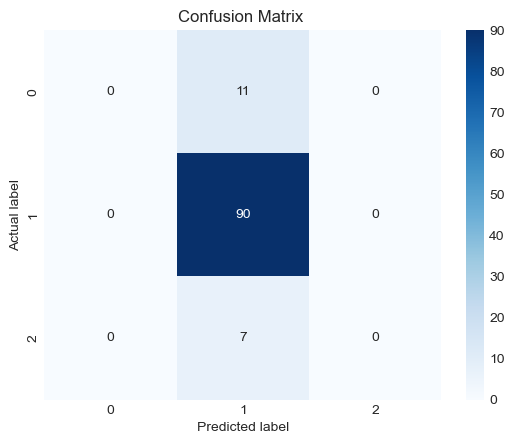

In [ ]:
conf_mat_NN = confusion_matrix(Y_valid_encoded, Y_valid_hat_NN)
sns.heatmap(conf_mat_NN, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### LSTM

In [ ]:
#print(X_train_scaled.shape)
#print(X_train_reshaped.shape)
#print(X_valid_scaled.shape)
#print(X_valid_reshaped.shape)

In [ ]:
# Reshape input data for LSTM (assuming 1 time step and input features equal to X_train_scaled.shape[1])
X_train_reshaped = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
X_valid_reshaped = X_valid_scaled.reshape(-1, 1, X_valid_scaled.shape[1]) # [batch, timesteps, feature]

# X_train_reshaped = X_train_scaled.reshape(65, 5, X_train_scaled.shape[1])
# X_valid_reshaped = X_valid_scaled.reshape(65, 5, X_valid_scaled.shape[1])

def create_LSTM_model():
    model = Sequential()
    model.add(LSTM(300, activation="relu", input_shape=(1, X_train_reshaped.shape[2])))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax"))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

LSTM_model = create_LSTM_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
LSTM_history = LSTM_model.fit(X_train_reshaped, Y_train_onehot,
                               epochs=200,
                               batch_size=15,
                               validation_data=(X_valid_reshaped, Y_valid_onehot),
                               callbacks=[early_stopping])


Epoch 1/200


2023-05-02 18:06:58.394671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 1.0960 - accuracy: 0.4000

2023-05-02 18:07:01.057513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 4s 125ms/step - loss: 1.0960 - accuracy: 0.4000 - val_loss: 1.0662 - val_accuracy: 0.8241
Epoch 2/200
22/22 [==============================] - 1s 46ms/step - loss: 1.0719 - accuracy: 0.5292 - val_loss: 1.0359 - val_accuracy: 0.8333
Epoch 3/200
22/22 [==============================] - 1s 41ms/step - loss: 1.0570 - accuracy: 0.5877 - val_loss: 1.0082 - val_accuracy: 0.8333
Epoch 4/200
22/22 [==============================] - 1s 39ms/step - loss: 1.0332 - accuracy: 0.6000 - val_loss: 0.9772 - val_accuracy: 0.8333
Epoch 5/200
22/22 [==============================] - 1s 39ms/step - loss: 1.0230 - accuracy: 0.5908 - val_loss: 0.9473 - val_accuracy: 0.8333
Epoch 6/200
22/22 [==============================] - 1s 36ms/step - loss: 1.0052 - accuracy: 0.5969 - val_loss: 0.9165 - val_accuracy: 0.8333
Epoch 7/200
22/22 [==============================] - 1s 36ms/step - loss: 0.9766 - accuracy: 0.6338 - val_loss: 0.8850 - val_accuracy: 0.8333
Epoch 8/200
22/22

In [ ]:
Y_train_hat_prob_LSTM = LSTM_model.predict(X_train_reshaped)
Y_train_hat_LSTM = np.argmax(Y_train_hat_prob_LSTM, axis=1)
train_accuracy_LSTM = accuracy_score(Y_train_encoded, Y_train_hat_LSTM) * 100
train_auc_roc_LSTM = roc_auc_score(Y_train_encoded, Y_train_hat_prob_LSTM, multi_class='ovr', average='macro') * 100

print('For in-sample train set:')

print('Accuracy: %.4f %%' % train_accuracy_LSTM)
print('AUC: %.4f %%' % train_auc_roc_LSTM)

print(classification_report(Y_train_encoded, Y_train_hat_LSTM, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_LSTM))

print('---------------------------------------------------------------')

# Validation

Y_valid_hat_prob_LSTM = LSTM_model.predict(X_valid_reshaped)
Y_valid_hat_LSTM = np.argmax(Y_valid_hat_prob_LSTM, axis=1)
valid_accuracy_LSTM = accuracy_score(Y_valid_encoded, Y_valid_hat_LSTM) * 100
valid_auc_roc_LSTM = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_LSTM, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy_LSTM)
print('AUC: %.4f %%' % valid_auc_roc_LSTM)

print(classification_report(Y_valid_encoded, Y_valid_hat_LSTM, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_LSTM))

2023-05-02 18:07:41.943242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


For in-sample train set:
Accuracy: 70.1538 %
AUC: 84.2377 %
              precision    recall  f1-score   support

           0   0.764706  0.376812  0.504854        69
           1   0.694118  0.926702  0.793722       191
           2   0.694444  0.384615  0.495050        65

    accuracy                       0.701538       325
   macro avg   0.717756  0.562710  0.597875       325
weighted avg   0.709169  0.701538  0.672659       325

0.5627095164996372
---------------------------------------------------------------
For validation set:
Accuracy: 80.5556 %
AUC: 71.2237 %
              precision    recall  f1-score   support

           0   0.333333  0.272727  0.300000        11
           1   0.848485  0.933333  0.888889        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.805556       108
   macro avg   0.393939  0.402020  0.396296       108
weighted avg   0.741021  0.805556  0.771296       108

0.402020202020202


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


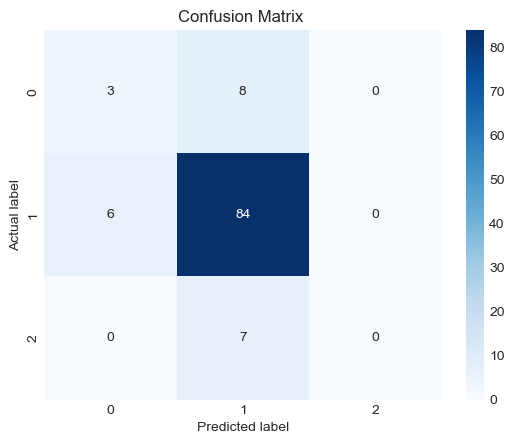

In [ ]:
conf_mat_LSTM = confusion_matrix(Y_valid_encoded, Y_valid_hat_LSTM)
sns.heatmap(conf_mat_LSTM, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

# Model Fitting With Top 10 Features:

- Linear: Logistic, LDA
- Non-Linear: QDA, SVM, KNN, LSTM, XGBOOST, Random Forest
  

In [ ]:
selected_features = zeros[:10]



X = df_concate_process1
X['lag(Y)'] = df_hist_fed_change
Y = df_Fed_change['Decision']

#6-3-1
total_length = X.shape[0]
Cut_off_train = int(total_length * 0.6)
Cut_off_valid = int(total_length * 0.8)

# Train 0 - 324
# Valid 325 - 433
# Test  433 - 542

X = X[selected_features]

# 1978-01-01 ~ 2005-01-01
X_train  = X.iloc[ :Cut_off_train, :]
Y_train  = Y.iloc[ :Cut_off_train]
print(Y_train.value_counts())


# 2005-02-01 ~ 2014-01-01
X_valid  = X.iloc[ Cut_off_train:Cut_off_valid, :]
Y_valid  = Y.iloc[Cut_off_train:Cut_off_valid]
print(Y_valid.value_counts())


# 2014-02-01 ~ 2023-02-01
X_test  = X.iloc[ Cut_off_valid:, :]
Y_test  = Y.iloc[ Cut_off_valid:]
print(Y_test.value_counts())

maintain    191
down         69
up           65
Name: Decision, dtype: int64
maintain    90
down        11
up           7
Name: Decision, dtype: int64
maintain    93
up          11
down         5
Name: Decision, dtype: int64


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)
#X_train_scaled.shape

# Create a label encoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the target variable
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_valid_encoded = label_encoder.transform(Y_valid)
Y_test_endoced = label_encoder.transform(Y_test)

#down = 0 maintain = 1, up = 2

In [ ]:
tscv = TimeSeriesSplit(n_splits=2)

### Logistic

In [ ]:
lr       = LogisticRegression( max_iter = 10000)
lr.fit(X_train_scaled,Y_train_encoded)

LogisticRegression(max_iter=10000)

In [ ]:
# Insample
Y_train_hat = lr.predict(X_train_scaled)
Y_train_hat_prob = lr.predict_proba(X_train_scaled)
train_accuracy   = accuracy_score(Y_train_encoded, Y_train_hat)*100
train_auc_roc    = roc_auc_score(Y_train_encoded, Y_train_hat_prob, multi_class='ovr', average='macro') * 100

print('For in-sample subtrain set:')

print('Accuracy: %.4f %%' % train_accuracy)
print('AUC: %.4f %%' % train_auc_roc)

print(classification_report(Y_train_encoded, Y_train_hat, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat))

print('---------------------------------------------------------------')
# Validation
Y_valid_hat = lr.predict(X_valid_scaled)
Y_valid_hat_prob = lr.predict_proba(X_valid_scaled)
valid_accuracy   = accuracy_score(Y_valid_encoded, Y_valid_hat)*100
valid_auc_roc    = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy)
print('AUC: %.4f %%' % valid_auc_roc)

print('---------------------------------------------------------------')
print(classification_report(Y_valid_encoded, Y_valid_hat, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat))

For in-sample subtrain set:
Accuracy: 70.1538 %
AUC: 82.5343 %
              precision    recall  f1-score   support

           0   0.717391  0.478261  0.573913        69
           1   0.709544  0.895288  0.791667       191
           2   0.631579  0.369231  0.466019        65

    accuracy                       0.701538       325
   macro avg   0.686171  0.580927  0.610533       325
weighted avg   0.695617  0.701538  0.680306       325

0.5809265323037233
---------------------------------------------------------------
For validation set:
Accuracy: 84.2593 %
AUC: 68.3076 %
---------------------------------------------------------------
              precision    recall  f1-score   support

           0   0.571429  0.363636  0.444444        11
           1   0.861386  0.966667  0.910995        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.842593       108
   macro avg   0.477605  0.443434  0.451813       108
weighted avg   0.776023  0.8

/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


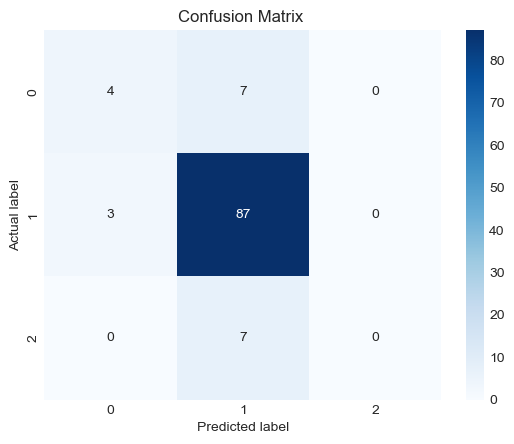

In [ ]:
conf_mat_lr = confusion_matrix(Y_valid_encoded, Y_valid_hat)
sns.heatmap(conf_mat_lr, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### LDA

In [ ]:
results = []
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

param_grid = {
    'ldasolver': ['lsqr', 'eigen'],
    'ldashrinkage': [None, 'auto', 0.1, 0.4, 0.7, 0.9]
}

for shrinkage in param_grid['ldashrinkage']:
    for solver in param_grid['ldasolver']:
        lda = LinearDiscriminantAnalysis(shrinkage=shrinkage, solver=solver)
        pipe.set_params(lda=lda)
        pipe.fit(X_train_scaled, Y_train_encoded)
        Y_pred_lda = pipe.predict(X_valid_scaled)
        accuracy = (Y_pred_lda == Y_valid_encoded).mean()
        results.append((shrinkage, solver, accuracy))



#lda = LinearDiscriminantAnalysis()
#lda.set_params(solver='svd')
#lda.fit(X_train_scaled, Y_train_encoded)
#Y_pred_lda = lda.predict(X_valid_scaled)
#accuracy = (Y_pred_lda == Y_valid_encoded).mean()
#results.append(('None', 'svd', accuracy))

In [ ]:
df = pd.DataFrame(results, columns=['shrinkage','solver', 'accuracy'])
df

,shrinkage,solver,accuracy
0,None,lsqr,0.824074
1,None,eigen,0.824074
2,auto,lsqr,0.851852
3,auto,eigen,0.851852
4,0.1,lsqr,0.842593
5,0.1,eigen,0.842593
6,0.4,lsqr,0.851852
7,0.4,eigen,0.851852
8,0.7,lsqr,0.833333
9,0.7,eigen,0.833333


In [ ]:
## Best parameters: shrinkage = None, solver = svd, accuracy = 0.842593
lda_model = LinearDiscriminantAnalysis()
lda_model.set_params(solver='svd')
lda_model.fit(X_train_scaled, Y_train_encoded)


Y_train_hat_lda = lda_model.predict(X_train_scaled)
Y_train_hat_prob_lda = lda_model.predict_proba(X_train_scaled)
train_accuracy_lda = accuracy_score(Y_train_encoded, Y_train_hat_lda) * 100
train_auc_roc_lda = roc_auc_score(Y_train_encoded, Y_train_hat_prob_lda, multi_class='ovr', average='macro') * 100
print('For in-sample subtrain set:')
print('Accuracy: %.4f %%' % train_accuracy_lda)
print('AUC: %.4f %%' % train_auc_roc_lda)

print(classification_report(Y_train_encoded, Y_train_hat_lda, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_lda))

print('---------------------------------------')
Y_valid_hat_lda = lda_model.predict(X_valid_scaled)
Y_valid_hat_prob_lda = lda_model.predict_proba(X_valid_scaled)
valid_accuracy_lda = accuracy_score(Y_valid_encoded, Y_valid_hat_lda) * 100
valid_auc_roc_lda = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_lda, multi_class='ovr', average='macro') * 100
print('For validation set:')
print('Accuracy: %.4f %%' % valid_accuracy_lda)
print('AUC: %.4f %%' % valid_auc_roc_lda)

print(classification_report(Y_valid_encoded, Y_valid_hat_lda, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_lda))


For in-sample subtrain set:
Accuracy: 69.5385 %
AUC: 82.2726 %
              precision    recall  f1-score   support

           0   0.695652  0.463768  0.556522        69
           1   0.706612  0.895288  0.789838       191
           2   0.621622  0.353846  0.450980        65

    accuracy                       0.695385       325
   macro avg   0.674628  0.570967  0.599113       325
weighted avg   0.687287  0.695385  0.672532       325

0.570967409301122
---------------------------------------
For validation set:
Accuracy: 82.4074 %
AUC: 62.8861 %
              precision    recall  f1-score   support

           0   0.500000  0.363636  0.421053        11
           1   0.858586  0.944444  0.899471        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.824074       108
   macro avg   0.452862  0.436027  0.440175       108
weighted avg   0.766414  0.824074  0.792444       108

0.436026936026936


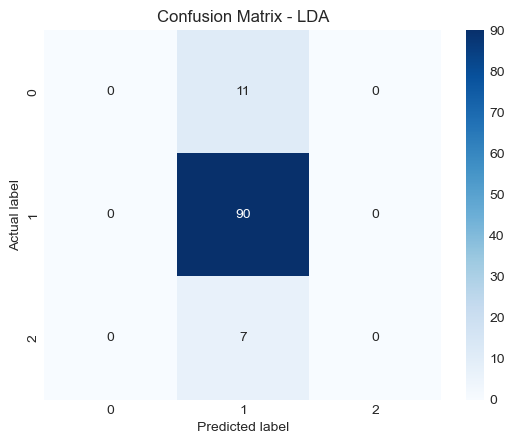

In [ ]:
conf_mat_lda = confusion_matrix(Y_valid_encoded, Y_pred_lda)
sns.heatmap(conf_mat_lda, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix - LDA')
plt.show()

### QDA

In [ ]:
model = QuadraticDiscriminantAnalysis()

tscv = TimeSeriesSplit(n_splits=2)

# Parameters
reg_param = [1 / x for x in range(1, 1000)]
#priors = [None]  # You can add custom prior probabilities for classes here, or keep it None
#store_covariance = [True, False]
#tol = [1e-4, 1e-3, 1e-2, 1e-1]
#n_features_in = [x for x in range(1, 20)]

params = {
    'reg_param': reg_param,
#    'priors': priors,
#    'store_covariance': store_covariance,
#    'tol': tol
#    'n_features_in_': n_features_in
}

grid = GridSearchCV(model, params, cv=tscv, scoring='f1_weighted')
grid.fit(X_train_scaled, Y_train_encoded)
qda_model = grid.best_estimator_


In [ ]:
qda_model.fit(X_train_scaled, Y_train_encoded)

Y_train_hat_qda = qda_model.predict(X_train_scaled)
Y_train_hat_prob_qda = qda_model.predict_proba(X_train_scaled)
train_accuracy_qda = accuracy_score(Y_train_encoded, Y_train_hat_qda) * 100
train_auc_roc_qda = roc_auc_score(Y_train_encoded, Y_train_hat_prob_qda, multi_class='ovr', average='macro') * 100
print('For in-sample subtrain set:')
print('Accuracy: %.4f %%' % train_accuracy_qda)
print('AUC: %.4f %%' % train_auc_roc_qda)

print(classification_report(Y_train_encoded, Y_train_hat_qda, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_qda))


print('---------------------------------------')
Y_valid_hat_qda = qda_model.predict(X_valid_scaled)
Y_valid_hat_prob_qda = qda_model.predict_proba(X_valid_scaled)
valid_accuracy_qda   = accuracy_score(Y_valid_encoded, Y_valid_hat_qda)*100
valid_auc_roc_qda    = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_qda, multi_class='ovr', average='macro') * 100
print('For validation set:')
print('Accuracy: %.4f %%' % valid_accuracy_qda)
print('AUC: %.4f %%' % valid_auc_roc_qda)


print(classification_report(Y_valid_encoded, Y_valid_hat_qda, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_qda))

For in-sample subtrain set:
Accuracy: 64.6154 %
AUC: 77.0861 %
              precision    recall  f1-score   support

           0   0.666667  0.289855  0.404040        69
           1   0.692641  0.837696  0.758294       191
           2   0.468750  0.461538  0.465116        65

    accuracy                       0.646154       325
   macro avg   0.609352  0.529697  0.542484       325
weighted avg   0.642348  0.646154  0.624448       325

0.5296966230269212
---------------------------------------
For validation set:
Accuracy: 83.3333 %
AUC: 59.0114 %
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        11
           1   0.833333  1.000000  0.909091        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.833333       108
   macro avg   0.277778  0.333333  0.303030       108
weighted avg   0.694444  0.833333  0.757576       108

0.3333333333333333


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


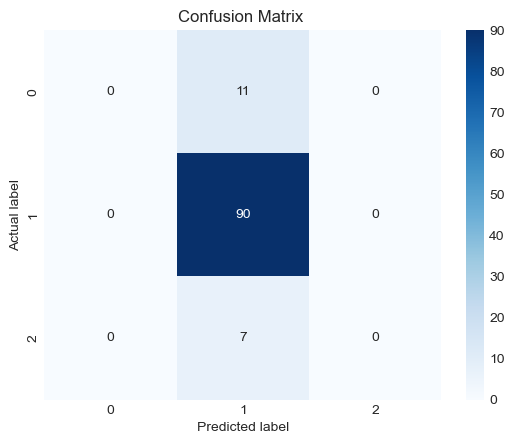

In [ ]:
conf_mat_qda = confusion_matrix(Y_valid_encoded, Y_valid_hat_qda)
sns.heatmap(conf_mat_qda, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### KNN

In [ ]:
max_k = 100
k_range = np.arange(max_k, 0, -1)
k_inverse = 1/k_range

train_error_rate = []
valid_error_rate = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train_scaled, Y_train_encoded)
  Y_train_hat_knn = knn.predict(X_train_scaled)
  Y_valid_hat_knn = knn.predict(X_valid_scaled)
  train_error = 1 - np.mean(Y_train_hat_knn == Y_train_encoded)
  valid_error = 1 - np.mean(Y_valid_hat_knn == Y_valid_encoded)
  train_error_rate.append(train_error)
  valid_error_rate.append(valid_error)


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

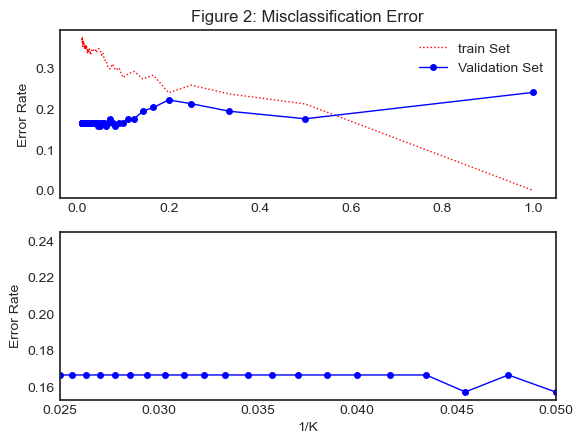

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(k_inverse, train_error_rate, color = 'red',linestyle = 'dotted', linewidth=1, markersize=4, label = 'train Set')
plt.plot(k_inverse, valid_error_rate, '-bo', linewidth=1, markersize=4, label = 'Validation Set')
plt.title('Figure 2: Misclassification Error')
plt.legend()
plt.ylabel('Error Rate')
#plt.xlabel('1/K')
plt.subplot(2, 1, 2)
plt.plot(k_inverse, valid_error_rate, '-bo', linewidth=1, markersize=4, label = 'Validation Set')
plt.ylabel('Error Rate')
plt.xlim([0.025, 0.05])
plt.xlabel("1/K")
plt.show()


In figure 2, the blue line is the KNN error rate when predicting the validation set and the red line is the KNN error rate when predicting the subtraining set. Since the red line is trival as KNN, being fitted with subtraining set, decrease the number of neighbourhood will result a perfit fit, but subject to overfit. We will focus on the blue line.

In [ ]:
min_error = np.min(valid_error_rate)
min_error_indices = np.where(valid_error_rate == min_error)[0]
min_error_K = [k_range[i] for i in min_error_indices]
print("The minimal error rate is: ", min_error)
print("Optimal K is: ", min_error_K)

The minimal error rate is:  0.15740740740740744
Optimal K is:  [22, 20, 16, 12]


The minimal error rate occurs when K = 24 and 23 with an minimal error being 0157

In [ ]:
Historical_validation_AUC = []
Historical_k = []
for k in min_error_K:
  print('')
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, Y_train_encoded)
  print(f'KNN (K={k})')
  Y_train_hat_knn = knn.predict(X_train_scaled)
  Y_train_hat_prob_knn = knn.predict_proba(X_train_scaled)
  train_accuracy_knn = accuracy_score(Y_train_encoded, Y_train_hat_knn) * 100
  train_roc_auc_knn = roc_auc_score(Y_train_encoded, Y_train_hat_prob_knn, multi_class='ovr', average='macro') * 100
#  train_cm_knn = confusion_matrix(Y_train_encoded, Y_train_hat_knn)
#  train_fpr_knn = (train_cm_knn[0, 1] / (train_cm_knn[0, 1] + train_cm_knn[0, 0])) * 100
#  train_fnr_knn = (train_cm_knn[1, 0] / (train_cm_knn[1, 0] + train_cm_knn[1, 1])) * 100
  print('For in-sample train set:')
#  print('Confusion Matrix:\n', train_cm_knn)
  print('Accuracy: %.4f %%' % train_accuracy_knn)
  print('AUC: %.4f %%' % train_roc_auc_knn)
#  print('False Positive Rate (FPR): %.4f %%' % train_fpr_knn)
#  print('False Negative Rate (FNR): %.4f %%' % train_fnr_knn)
  print('---------------------------------------')
  Y_valid_hat_knn = knn.predict(X_valid_scaled)
  Y_valid_hat_prob_knn = knn.predict_proba(X_valid_scaled)
  valid_accuracy_knn = accuracy_score(Y_valid_encoded, Y_valid_hat_knn) * 100
  valid_roc_auc_knn = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_knn, multi_class='ovr', average='macro') * 100
  Historical_validation_AUC.append(valid_roc_auc_knn)
  Historical_k.append(k)


#  valid_cm_knn = confusion_matrix(Y_valid_encoded, Y_valid_hat_knn)
#  valid_fpr_knn = (valid_cm_knn[0, 1] / (valid_cm_knn[0, 1] + valid_cm_knn[0, 0])) * 100
#  valid_fnr_knn = (valid_cm_knn[1, 0] / (valid_cm_knn[1, 0] + valid_cm_knn[1, 1])) * 100
  print('For valid set:')
#  print('Confusion Matrix:\n', valid_cm_knn)
  print('Accuracy: %.4f %%' % valid_accuracy_knn)
  print('AUC: %.4f %%' % valid_roc_auc_knn)
#  print('False Positive Rate (FPR): %.4f %%' % valid_fpr_knn)
#  print('False Negative Rate (FNR): %.4f %%' % valid_fnr_knn)



KNN (K=22)
For in-sample train set:
Accuracy: 65.2308 %
AUC: 82.0949 %
---------------------------------------
For valid set:
Accuracy: 84.2593 %
AUC: 79.4218 %

KNN (K=20)
For in-sample train set:
Accuracy: 65.5385 %
AUC: 82.9250 %
---------------------------------------
For valid set:
Accuracy: 84.2593 %
AUC: 79.3447 %

KNN (K=16)
For in-sample train set:
Accuracy: 68.0000 %
AUC: 84.0426 %
---------------------------------------
For valid set:
Accuracy: 84.2593 %
AUC: 79.9578 %

KNN (K=12)
For in-sample train set:
Accuracy: 70.4615 %
AUC: 85.9215 %
---------------------------------------
For valid set:
Accuracy: 84.2593 %
AUC: 75.8564 %


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

Therefore, we will keep K = 16

In [ ]:
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train_scaled, Y_train_encoded)
print(f'KNN (K={k})')
Y_train_hat_knn = knn.predict(X_train_scaled)
Y_train_hat_prob_knn = knn.predict_proba(X_train_scaled)
train_accuracy_knn = accuracy_score(Y_train_encoded, Y_train_hat_knn) * 100
train_roc_auc_knn = roc_auc_score(Y_train_encoded, Y_train_hat_prob_knn, multi_class='ovr', average='macro') * 100

print('For in-sample train set:')

print('Accuracy: %.4f %%' % train_accuracy_knn)
print('AUC: %.4f %%' % train_roc_auc_knn)

print(classification_report(Y_train_encoded, Y_train_hat_knn, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_knn))

print('---------------------------------------')
Y_valid_hat_knn = knn.predict(X_valid_scaled)
Y_valid_hat_prob_knn = knn.predict_proba(X_valid_scaled)
valid_accuracy_knn = accuracy_score(Y_valid_encoded, Y_valid_hat_knn) * 100
valid_roc_auc_knn = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_knn, multi_class='ovr', average='macro') * 100

print('For valid set:')

print('Accuracy: %.4f %%' % valid_accuracy_knn)
print('AUC: %.4f %%' % valid_roc_auc_knn)

print(classification_report(Y_valid_encoded, Y_valid_hat_knn, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_knn))

KNN (K=12)
For in-sample train set:
Accuracy: 68.0000 %
AUC: 84.0426 %
              precision    recall  f1-score   support

           0   0.595745  0.405797  0.482759        69
           1   0.711207  0.863874  0.780142       191
           2   0.608696  0.430769  0.504505        65

    accuracy                       0.680000       325
   macro avg   0.638549  0.566814  0.589135       325
weighted avg   0.666191  0.680000  0.661878       325

0.5668135592560815
---------------------------------------
For valid set:
Accuracy: 84.2593 %
AUC: 79.9578 %
              precision    recall  f1-score   support

           0   1.000000  0.090909  0.166667        11
           1   0.841121  1.000000  0.913706        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.842593       108
   macro avg   0.613707  0.363636  0.360124       108
weighted avg   0.802786  0.842593  0.778397       108

0.3636363636363636


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

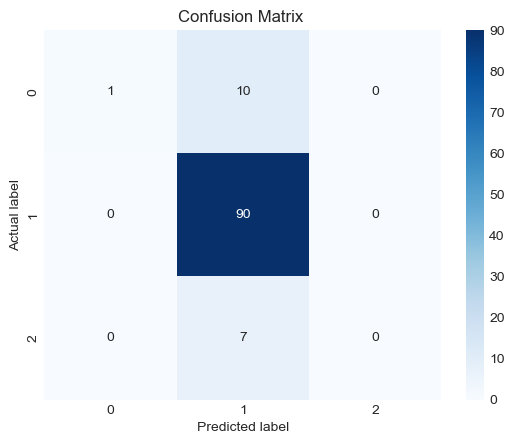

In [ ]:
conf_mat_knn = confusion_matrix(Y_valid_encoded, Y_valid_hat_knn)
sns.heatmap(conf_mat_knn, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### SVM Polynomial

In [ ]:
#X_concat = np.concatenate((X_train_scaled, X_valid_scaled), axis = 0)
#Y_concat = np.concatenate((Y_train_encoded, Y_valid_encoded), axis = 0)


tscv = TimeSeriesSplit(n_splits=2)

svm_poly = SVC(kernel='poly', probability=True)
param_grid_poly = {
    "C": np.arange(1, 11),
    "gamma": np.logspace(-3, -1, 5),
    #"gamma" : [1/x for x in range(1,100)],
    "degree": np.arange(2, 6),
    "coef0": np.linspace(-1, 1, 11)
}

grid_search_poly = GridSearchCV(svm_poly, param_grid_poly, cv=tscv, scoring='f1_weighted', n_jobs= -1)
grid_search_poly.fit(X_train_scaled, Y_train_encoded)

print(grid_search_poly.best_estimator_)
print('degree is', grid_search_poly.best_estimator_.degree)

SVC(C=7, coef0=-0.8, degree=5, gamma=0.01, kernel='poly', probability=True)
degree is 5


In [ ]:
svm_poly = grid_search_poly.best_estimator_.fit(X_train_scaled, Y_train_encoded)

Y_train_hat_poly = svm_poly.predict(X_train_scaled)
Y_train_hat_prob_poly = svm_poly.predict_proba(X_train_scaled)
train_accuracy_poly = accuracy_score(Y_train_encoded, Y_train_hat_poly) * 100
train_auc_roc_poly = roc_auc_score(Y_train_encoded, Y_train_hat_prob_poly, multi_class='ovr', average='macro') * 100
print('For in-sample subtrain set:')
print('Accuracy: %.4f %%' % train_accuracy_poly)
print('AUC: %.4f %%' % train_auc_roc_poly)

print(classification_report(Y_train_encoded, Y_train_hat_poly, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_poly))

print('---------------------------------------')
Y_valid_hat_poly = svm_poly.predict(X_valid_scaled)
Y_valid_hat_prob_poly = svm_poly.predict_proba(X_valid_scaled)
valid_accuracy_poly   = accuracy_score(Y_valid_encoded, Y_valid_hat_poly)*100
valid_auc_roc_poly    = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_poly, multi_class='ovr', average='macro') * 100
print('For validation set:')
print('Accuracy: %.4f %%' % valid_accuracy_poly)
print('AUC: %.4f %%' % valid_auc_roc_poly)


print(classification_report(Y_valid_encoded, Y_valid_hat_poly, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_poly))

For in-sample subtrain set:
Accuracy: 65.5385 %
AUC: 74.4551 %
              precision    recall  f1-score   support

           0   0.500000  0.666667  0.571429        69
           1   0.735000  0.769634  0.751918       191
           2   0.606061  0.307692  0.408163        65

    accuracy                       0.655385       325
   macro avg   0.613687  0.581331  0.577170       325
weighted avg   0.659320  0.655385  0.644848       325

0.5813308274041258
---------------------------------------
For validation set:
Accuracy: 82.4074 %
AUC: 64.2275 %
              precision    recall  f1-score   support

           0   0.473684  0.818182  0.600000        11
           1   0.898876  0.888889  0.893855        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.824074       108
   macro avg   0.457520  0.569024  0.497952       108
weighted avg   0.797309  0.824074  0.805990       108

0.5690235690235691


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


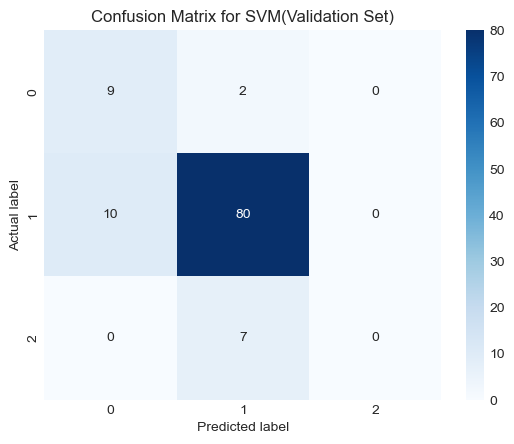

In [ ]:
conf_mat_svm = confusion_matrix(Y_valid_encoded, Y_valid_hat_poly)
sns.heatmap(conf_mat_svm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix for SVM(Validation Set)')
plt.show()

For test set:
Accuracy: 44.9541 %
AUC: 68.8923 %
              precision    recall  f1-score   support

           0   0.166667  0.200000  0.181818         5
           1   0.906977  0.419355  0.573529        93
           2   0.150000  0.818182  0.253521        11

    accuracy                       0.449541       109
   macro avg   0.407881  0.479179  0.336290       109
weighted avg   0.796625  0.449541  0.523267       109

0.47917888563049854


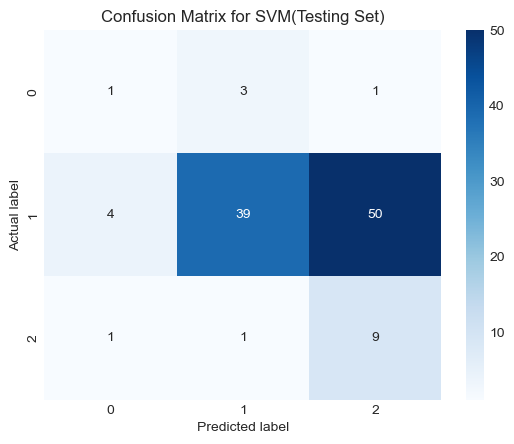

In [ ]:
Y_test_hat_poly = svm_poly.predict(X_test_scaled)
Y_test_hat_prob_poly = svm_poly.predict_proba(X_test_scaled)
test_accuracy_poly   = accuracy_score(Y_test_encoded, Y_test_hat_poly)*100
test_auc_roc_poly    = roc_auc_score(Y_test_encoded, Y_test_hat_prob_poly, multi_class='ovr', average='macro') * 100
print('For test set:')
print('Accuracy: %.4f %%' % test_accuracy_poly)
print('AUC: %.4f %%' % test_auc_roc_poly)


print(classification_report(Y_test_encoded, Y_test_hat_poly, digits=6))
print(balanced_accuracy_score(Y_test_encoded, Y_test_hat_poly))

conf_mat_svm_test = confusion_matrix(Y_test_encoded, Y_test_hat_poly)
sns.heatmap(conf_mat_svm_test, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix for SVM(Testing Set)')
plt.show()

### Randomized Forest

In [ ]:
param_dist = {
    'n_estimators': np.arange(200, 500, 100),
    'max_depth': np.arange(1, 40)
}

rf_clf = RandomForestClassifier()

# Full Features
random_search_rf = RandomizedSearchCV(
    rf_clf,
    param_distributions=param_dist,
    n_iter=50,
#    scoring=make_scorer(f1_score, average='macro'),
    cv=tscv,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train_scaled, Y_train_encoded)
best_params = random_search_rf.best_params_
print('', best_params)

 {'n_estimators': 200, 'max_depth': 4}


In [ ]:
# In-sample
Y_train_hat_rf = random_search_rf.predict(X_train_scaled)
Y_train_hat_prob_rf = random_search_rf.predict_proba(X_train_scaled)
train_accuracy_rf = accuracy_score(Y_train_encoded, Y_train_hat_rf) * 100
train_auc_roc_rf = roc_auc_score(Y_train_encoded, Y_train_hat_prob_rf, multi_class='ovr', average='macro') * 100

print('For in-sample train set:')

print('Accuracy: %.4f %%' % train_accuracy_rf)
print('AUC: %.4f %%' % train_auc_roc_rf)

print(classification_report(Y_train_encoded, Y_train_hat_rf, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_rf))

print('---------------------------------------------------------------')

# Validation
Y_valid_hat_rf = random_search_rf.predict(X_valid_scaled)
Y_valid_hat_prob_rf = random_search_rf.predict_proba(X_valid_scaled)
valid_accuracy_rf = accuracy_score(Y_valid_encoded, Y_valid_hat_rf) * 100
valid_auc_roc_rf = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_rf, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy_rf)
print('AUC: %.4f %%' % valid_auc_roc_rf)


print(classification_report(Y_valid_encoded, Y_valid_hat_rf, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_rf))

For in-sample train set:
Accuracy: 78.4615 %
AUC: 91.9363 %
              precision    recall  f1-score   support

           0   0.895833  0.623188  0.735043        69
           1   0.758333  0.952880  0.844548       191
           2   0.810811  0.461538  0.588235        65

    accuracy                       0.784615       325
   macro avg   0.821659  0.679202  0.722609       325
weighted avg   0.798021  0.784615  0.770036       325

0.6792021494957985
---------------------------------------------------------------
For validation set:
Accuracy: 87.9630 %
AUC: 60.9647 %
              precision    recall  f1-score   support

           0   0.857143  0.545455  0.666667        11
           1   0.881188  0.988889  0.931937        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.879630       108
   macro avg   0.579444  0.511448  0.532868       108
weighted avg   0.821625  0.879630  0.844516       108

0.5114478114478115


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


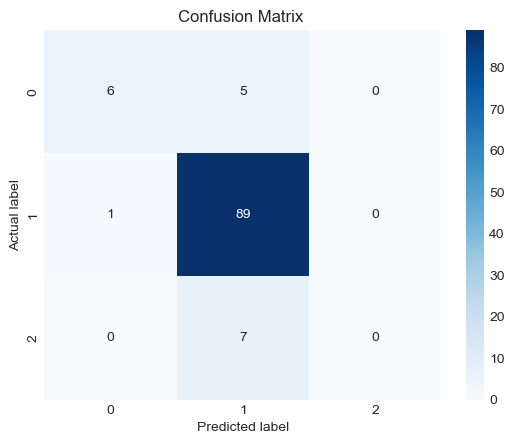

In [ ]:
conf_mat_rf = confusion_matrix(Y_valid_encoded, Y_valid_hat_rf)
sns.heatmap(conf_mat_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### XGBOOSTING

In [ ]:
param_dist_xgb = {
    'n_estimators': np.arange(200, 500, 100),
    'max_depth': np.arange(1, 40),
    'gamma': [x for x in range(1,10)],
    'alpha': [1/x for x in range(1,1000)],
    'lambda':[1/x for x in range(1,1000)],
    'min_child_weight': [x for x in range(1,10)]
}

xgb_classifier = xgb.XGBClassifier(learning_rate = 0.1)


random_search_xgb = RandomizedSearchCV(
    xgb_classifier,
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring= 'f1_weighted',
    cv=tscv,
    n_jobs=-1,
    random_state=42
)


random_search_xgb.fit(X_train_scaled, Y_train_encoded)
best_params_xgb = random_search_xgb.best_params_
print('For full predictors:', best_params_xgb)

For full predictors: {'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'lambda': 0.002898550724637681, 'gamma': 1, 'alpha': 0.002288329519450801}


In [ ]:
# In-sample
Y_train_hat_xgb = random_search_xgb.predict(X_train_scaled)
Y_train_hat_prob_xgb = random_search_xgb.predict_proba(X_train_scaled)
train_accuracy_xgb = accuracy_score(Y_train_encoded, Y_train_hat_xgb) * 100
train_auc_roc_xgb = roc_auc_score(Y_train_encoded, Y_train_hat_prob_xgb, multi_class='ovr', average='macro') * 100

print('For in-sample subtrain set:')
print('Accuracy: %.4f %%' % train_accuracy_xgb)
print('AUC: %.4f %%' % train_auc_roc_xgb)

print(classification_report(Y_train_encoded, Y_train_hat_xgb, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_xgb))

print('---------------------------------------------------------------')

# Validation
Y_valid_hat_xgb = random_search_xgb.predict(X_valid_scaled)
Y_valid_hat_prob_xgb = random_search_xgb.predict_proba(X_valid_scaled)
valid_accuracy_xgb = accuracy_score(Y_valid_encoded, Y_valid_hat_xgb) * 100
valid_auc_roc_xgb = roc_auc_score(Y_valid, Y_valid_hat_prob_xgb, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy_xgb)
print('AUC: %.4f %%' % valid_auc_roc_xgb)


print(classification_report(Y_valid_encoded, Y_valid_hat_xgb, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_xgb))

For in-sample subtrain set:
Accuracy: 96.9231 %
AUC: 99.6737 %
              precision    recall  f1-score   support

           0   0.970149  0.942029  0.955882        69
           1   0.964286  0.989529  0.976744       191
           2   0.983871  0.938462  0.960630        65

    accuracy                       0.969231       325
   macro avg   0.972769  0.956673  0.964419       325
weighted avg   0.969448  0.969231  0.969092       325

0.9566731065934343
---------------------------------------------------------------
For validation set:
Accuracy: 80.5556 %
AUC: 63.8828 %
              precision    recall  f1-score   support

           0   0.500000  0.545455  0.521739        11
           1   0.870968  0.900000  0.885246        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.805556       108
   macro avg   0.456989  0.481818  0.468995       108
weighted avg   0.776732  0.805556  0.790845       108

0.48181818181818176


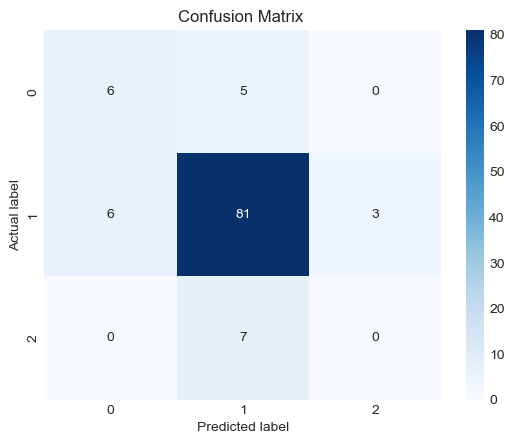

In [ ]:
conf_mat_xgb = confusion_matrix(Y_valid_encoded, Y_valid_hat_xgb)
sns.heatmap(conf_mat_xgb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### Neural Net Work

In [ ]:
Y_train_onehot   = to_categorical(Y_train_encoded,   num_classes=3)
Y_valid_onehot   = to_categorical(Y_valid_encoded, num_classes=3)

In [ ]:
#def create_NN_model():
#  NN = Sequential()#
#
#  NN.add(Dense(300, activation="relu", input_shape = X_train_scaled.shape[1:]))
#  NN.add(Dropout(0.5))
#  NN.add(Dense(100, activation="relu"))
#  NN.add(Dropout(0.5))
#  NN.add(Dense(3, activation="softmax"))
#  optimizer = Adam(learning_rate=0.0001)
#  NN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#
#  return NN
#
#NN_model = create_NN_model()
#
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)
#
#NN_history = NN_model.fit(X_train_scaled, Y_train_onehot,
#                            epochs=200,
#                            batch_size=15,
#                            validation_data=(X_valid_scaled, Y_valid_onehot),
#                            callbacks=[early_stopping])
#
#
#
#
def build_network(hidden=2, neurons=25, shape=[10], rate=0.001, drop=0.5):
  model = Sequential()
  model.add(keras.layers.InputLayer(input_shape=shape))

  for i in range(hidden):
    model.add(Dense(neurons, activation = 'relu'))
    model.add(Dropout(drop))

  model.add(Dense(3,activation='softmax'))
  opt = keras.optimizers.Adam(learning_rate=rate)
  model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

params = {'hidden': [2,3,4,5],
          'neurons':[50, 100, 150, 200, 250, 300],
          'rate':reciprocal(3e-4,3e-1),
          'drop':uniform(0.1,0.5)}

cl = keras.wrappers.scikit_learn.KerasClassifier(build_network)
cl.fit(X_train_scaled, Y_train_onehot, epochs = 50, validation_data=(X_valid_scaled, Y_valid_onehot), batch_size=16, callbacks=[EarlyStopping(monitor='val_loss', patience=9)])

NN_model = RandomizedSearchCV(cl, params, n_iter=20, cv=tscv, verbose=2)
NN_model.fit(X_train_scaled, Y_train_onehot, epochs=50,  validation_data=(X_valid_scaled, Y_valid_onehot), callbacks=[EarlyStopping(monitor='val_loss', patience=9)], batch_size=20)

Epoch 1/50


/var/folders/lk/r1pv7gcs7zv2103vh2sw8j840000gn/T/ipykernel_95462/198466851.py:45: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cl = keras.wrappers.scikit_learn.KerasClassifier(build_network)
2023-05-02 18:07:55.645035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.2341 - accuracy: 0.3785

2023-05-02 18:07:57.101878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 71ms/step - loss: 1.2341 - accuracy: 0.3785 - val_loss: 1.0399 - val_accuracy: 0.3241
Epoch 2/50
21/21 [==============================] - 1s 36ms/step - loss: 1.1429 - accuracy: 0.4123 - val_loss: 0.9038 - val_accuracy: 0.7593
Epoch 3/50
21/21 [==============================] - 1s 29ms/step - loss: 1.0996 - accuracy: 0.4923 - val_loss: 0.8344 - val_accuracy: 0.8056
Epoch 4/50
21/21 [==============================] - 1s 28ms/step - loss: 1.0153 - accuracy: 0.5262 - val_loss: 0.7461 - val_accuracy: 0.8333
Epoch 5/50
21/21 [==============================] - 1s 29ms/step - loss: 1.0261 - accuracy: 0.5508 - val_loss: 0.7123 - val_accuracy: 0.8333
Epoch 6/50
21/21 [==============================] - 1s 28ms/step - loss: 1.0593 - accuracy: 0.5200 - val_loss: 0.6964 - val_accuracy: 0.8333
Epoch 7/50
21/21 [==============================] - 1s 26ms/step - loss: 0.9766 - accuracy: 0.5723 - val_loss: 0.6896 - val_accuracy: 0.8333
Epoch 8/50
21/21 [======

2023-05-02 18:08:16.197750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 398.7607 - accuracy: 0.3945

2023-05-02 18:08:17.595945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 243ms/step - loss: 398.7607 - accuracy: 0.3945 - val_loss: 8.7524 - val_accuracy: 0.8148
Epoch 2/50
6/6 [==============================] - 1s 103ms/step - loss: 88.9962 - accuracy: 0.3028 - val_loss: 17.6462 - val_accuracy: 0.1481
Epoch 3/50
6/6 [==============================] - 0s 78ms/step - loss: 66.1173 - accuracy: 0.3486 - val_loss: 15.0581 - val_accuracy: 0.2130
Epoch 4/50
6/6 [==============================] - 1s 105ms/step - loss: 109.2874 - accuracy: 0.3119 - val_loss: 17.8465 - val_accuracy: 0.4259
Epoch 5/50
6/6 [==============================] - 0s 59ms/step - loss: 143.6631 - accuracy: 0.3119 - val_loss: 19.5274 - val_accuracy: 0.1296
Epoch 6/50
6/6 [==============================] - 0s 48ms/step - loss: 140.6477 - accuracy: 0.3303 - val_loss: 10.7304 - val_accuracy: 0.0370
Epoch 7/50
6/6 [==============================] - 0s 52ms/step - loss: 188.1275 - accuracy: 0.3670 - val_loss: 34.0509 - val_accuracy: 0.0648
Epoch 8/50
6/6 [=

2023-05-02 18:08:24.691022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 76ms/step - loss: 234.3288 - accuracy: 0.6111
[CV] END drop=0.3957984764424869, hidden=4, neurons=100, rate=0.2462849762925233; total time=   9.2s
Epoch 1/50


2023-05-02 18:08:25.367939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 154.1762 - accuracy: 0.3180

2023-05-02 18:08:27.148195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 160ms/step - loss: 154.1762 - accuracy: 0.3180 - val_loss: 16.2438 - val_accuracy: 0.2500
Epoch 2/50
11/11 [==============================] - 1s 49ms/step - loss: 238.1947 - accuracy: 0.3687 - val_loss: 15.1344 - val_accuracy: 0.1759
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 219.2077 - accuracy: 0.4194 - val_loss: 0.9057 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 35ms/step - loss: 181.4962 - accuracy: 0.4470 - val_loss: 0.7551 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 1s 51ms/step - loss: 183.9113 - accuracy: 0.4885 - val_loss: 0.8819 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 41ms/step - loss: 65.4599 - accuracy: 0.4424 - val_loss: 0.7682 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 34ms/step - loss: 58.2398 - accuracy: 0.4885 - val_loss: 0.7601 - val_accuracy: 0.8333
Epoch 8/5

2023-05-02 18:08:32.563310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 74ms/step - loss: 0.8587 - accuracy: 0.7963
[CV] END drop=0.3957984764424869, hidden=4, neurons=100, rate=0.2462849762925233; total time=   7.9s
Epoch 1/50


2023-05-02 18:08:33.209721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1769 - accuracy: 0.3119

2023-05-02 18:08:34.249910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 204ms/step - loss: 1.1769 - accuracy: 0.3119 - val_loss: 0.9810 - val_accuracy: 0.7685
Epoch 2/50
6/6 [==============================] - 0s 79ms/step - loss: 1.1323 - accuracy: 0.2936 - val_loss: 0.9634 - val_accuracy: 0.7778
Epoch 3/50
6/6 [==============================] - 0s 56ms/step - loss: 1.0752 - accuracy: 0.3853 - val_loss: 0.9473 - val_accuracy: 0.7963
Epoch 4/50
6/6 [==============================] - 0s 55ms/step - loss: 1.0887 - accuracy: 0.4037 - val_loss: 0.9302 - val_accuracy: 0.8056
Epoch 5/50
6/6 [==============================] - 0s 63ms/step - loss: 1.0697 - accuracy: 0.3670 - val_loss: 0.9155 - val_accuracy: 0.8241
Epoch 6/50
6/6 [==============================] - 0s 49ms/step - loss: 1.0529 - accuracy: 0.4220 - val_loss: 0.8995 - val_accuracy: 0.8333
Epoch 7/50
6/6 [==============================] - 0s 44ms/step - loss: 1.0307 - accuracy: 0.4862 - val_loss: 0.8851 - val_accuracy: 0.8333
Epoch 8/50
6/6 [=====================

2023-05-02 18:08:47.193911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 60ms/step - loss: 0.9730 - accuracy: 0.5648
[CV] END drop=0.1631623501239811, hidden=2, neurons=50, rate=0.00032335164449139964; total time=  14.6s
Epoch 1/50


2023-05-02 18:08:47.762998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.1375 - accuracy: 0.4424

2023-05-02 18:08:49.087802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 125ms/step - loss: 1.1375 - accuracy: 0.4424 - val_loss: 0.9345 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 53ms/step - loss: 1.0734 - accuracy: 0.4747 - val_loss: 0.8771 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 1.0558 - accuracy: 0.4885 - val_loss: 0.8221 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 46ms/step - loss: 1.0241 - accuracy: 0.5161 - val_loss: 0.7811 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 38ms/step - loss: 0.9882 - accuracy: 0.5300 - val_loss: 0.7434 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 38ms/step - loss: 1.0229 - accuracy: 0.4885 - val_loss: 0.7170 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 33ms/step - loss: 0.9910 - accuracy: 0.5161 - val_loss: 0.6937 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:09:06.157898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 54ms/step - loss: 0.6308 - accuracy: 0.7963
[CV] END drop=0.1631623501239811, hidden=2, neurons=50, rate=0.00032335164449139964; total time=  18.9s
Epoch 1/50


2023-05-02 18:09:06.699487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.3474 - accuracy: 0.3670

2023-05-02 18:09:07.703352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 187ms/step - loss: 1.3474 - accuracy: 0.3670 - val_loss: 0.6669 - val_accuracy: 0.8333
Epoch 2/50
6/6 [==============================] - 0s 70ms/step - loss: 1.0354 - accuracy: 0.5046 - val_loss: 0.9002 - val_accuracy: 0.8333
Epoch 3/50
6/6 [==============================] - 0s 69ms/step - loss: 0.9709 - accuracy: 0.5138 - val_loss: 0.9018 - val_accuracy: 0.5833
Epoch 4/50
6/6 [==============================] - 0s 52ms/step - loss: 0.8781 - accuracy: 0.6330 - val_loss: 0.9399 - val_accuracy: 0.5741
Epoch 5/50
6/6 [==============================] - 0s 48ms/step - loss: 0.8554 - accuracy: 0.6514 - val_loss: 0.8940 - val_accuracy: 0.6389
Epoch 6/50
6/6 [==============================] - 0s 45ms/step - loss: 0.8697 - accuracy: 0.6147 - val_loss: 0.9265 - val_accuracy: 0.4815
Epoch 7/50
6/6 [==============================] - 0s 46ms/step - loss: 0.8265 - accuracy: 0.6697 - val_loss: 1.0676 - val_accuracy: 0.3241
Epoch 8/50
6/6 [=====================

2023-05-02 18:09:10.849277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 60ms/step - loss: 1.0989 - accuracy: 0.3611
[CV] END drop=0.13876057583930282, hidden=2, neurons=50, rate=0.04471490448278493; total time=   4.7s
Epoch 1/50


2023-05-02 18:09:11.402191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.1741 - accuracy: 0.5069

2023-05-02 18:09:12.632615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 118ms/step - loss: 1.1741 - accuracy: 0.5069 - val_loss: 0.8241 - val_accuracy: 0.6204
Epoch 2/50
11/11 [==============================] - 1s 52ms/step - loss: 0.9291 - accuracy: 0.5991 - val_loss: 0.7896 - val_accuracy: 0.6204
Epoch 3/50
11/11 [==============================] - 0s 46ms/step - loss: 0.8908 - accuracy: 0.5760 - val_loss: 1.0861 - val_accuracy: 0.3796
Epoch 4/50
11/11 [==============================] - 0s 33ms/step - loss: 0.8235 - accuracy: 0.6129 - val_loss: 0.6049 - val_accuracy: 0.7685
Epoch 5/50
11/11 [==============================] - 0s 34ms/step - loss: 0.8953 - accuracy: 0.5945 - val_loss: 0.7302 - val_accuracy: 0.7593
Epoch 6/50
11/11 [==============================] - 0s 34ms/step - loss: 0.8492 - accuracy: 0.5668 - val_loss: 0.5567 - val_accuracy: 0.8241
Epoch 7/50
11/11 [==============================] - 0s 32ms/step - loss: 0.8271 - accuracy: 0.6175 - val_loss: 0.4308 - val_accuracy: 0.8704
Epoch 8/50
11/11 [=====

2023-05-02 18:09:19.999221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 59ms/step - loss: 0.8754 - accuracy: 0.5556
[CV] END drop=0.13876057583930282, hidden=2, neurons=50, rate=0.04471490448278493; total time=   9.1s
Epoch 1/50


2023-05-02 18:09:20.564117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 3.1965 - accuracy: 0.3578

2023-05-02 18:09:21.904302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 237ms/step - loss: 3.1965 - accuracy: 0.3578 - val_loss: 1.9124 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 0s 93ms/step - loss: 1.4928 - accuracy: 0.3119 - val_loss: 0.6516 - val_accuracy: 0.8333
Epoch 3/50
6/6 [==============================] - 0s 72ms/step - loss: 1.4089 - accuracy: 0.3303 - val_loss: 1.0433 - val_accuracy: 0.3611
Epoch 4/50
6/6 [==============================] - 0s 65ms/step - loss: 1.1695 - accuracy: 0.4220 - val_loss: 0.9274 - val_accuracy: 0.6852
Epoch 5/50
6/6 [==============================] - 0s 62ms/step - loss: 1.5382 - accuracy: 0.3945 - val_loss: 0.9109 - val_accuracy: 0.7778
Epoch 6/50
6/6 [==============================] - 0s 49ms/step - loss: 1.5608 - accuracy: 0.3945 - val_loss: 1.0279 - val_accuracy: 0.5926
Epoch 7/50
6/6 [==============================] - 0s 50ms/step - loss: 1.4110 - accuracy: 0.3394 - val_loss: 0.9881 - val_accuracy: 0.6944
Epoch 8/50
6/6 [=====================

2023-05-02 18:09:25.581287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 65ms/step - loss: 1.1061 - accuracy: 0.2685
[CV] END drop=0.5614311797938968, hidden=3, neurons=150, rate=0.04625891202016145; total time=   5.6s
Epoch 1/50


2023-05-02 18:09:27.272206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 2.5490 - accuracy: 0.3871

2023-05-02 18:09:28.810540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 140ms/step - loss: 2.5490 - accuracy: 0.3871 - val_loss: 1.0714 - val_accuracy: 0.0648
Epoch 2/50
11/11 [==============================] - 1s 58ms/step - loss: 1.2652 - accuracy: 0.4332 - val_loss: 0.8207 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 37ms/step - loss: 1.5287 - accuracy: 0.4700 - val_loss: 0.7335 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 39ms/step - loss: 1.4774 - accuracy: 0.4470 - val_loss: 0.8195 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 40ms/step - loss: 2.1996 - accuracy: 0.4839 - val_loss: 0.8804 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 36ms/step - loss: 1.4812 - accuracy: 0.4608 - val_loss: 0.8596 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 31ms/step - loss: 1.7109 - accuracy: 0.4470 - val_loss: 0.8227 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:09:33.853810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 62ms/step - loss: 0.8179 - accuracy: 0.7963
[CV] END drop=0.5614311797938968, hidden=3, neurons=150, rate=0.04625891202016145; total time=   8.3s
Epoch 1/50


2023-05-02 18:09:34.514913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1229 - accuracy: 0.3945

2023-05-02 18:09:36.245611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 272ms/step - loss: 1.1229 - accuracy: 0.3945 - val_loss: 0.9983 - val_accuracy: 0.8241
Epoch 2/50
6/6 [==============================] - 0s 77ms/step - loss: 1.0274 - accuracy: 0.5046 - val_loss: 0.9504 - val_accuracy: 0.8241
Epoch 3/50
6/6 [==============================] - 1s 112ms/step - loss: 1.0738 - accuracy: 0.4312 - val_loss: 0.9491 - val_accuracy: 0.8333
Epoch 4/50
6/6 [==============================] - 0s 81ms/step - loss: 1.0236 - accuracy: 0.4771 - val_loss: 0.9962 - val_accuracy: 0.5278
Epoch 5/50
6/6 [==============================] - 0s 68ms/step - loss: 0.9371 - accuracy: 0.4954 - val_loss: 0.9972 - val_accuracy: 0.4352
Epoch 6/50
6/6 [==============================] - 0s 58ms/step - loss: 0.9447 - accuracy: 0.5596 - val_loss: 0.9387 - val_accuracy: 0.6759
Epoch 7/50
6/6 [==============================] - 0s 50ms/step - loss: 0.9370 - accuracy: 0.6239 - val_loss: 0.8814 - val_accuracy: 0.7963
Epoch 8/50
6/6 [====================

2023-05-02 18:09:44.420457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 79ms/step - loss: 1.0630 - accuracy: 0.4722
[CV] END drop=0.24702323935333867, hidden=5, neurons=100, rate=0.0019742819658875024; total time=  10.7s
Epoch 1/50


2023-05-02 18:09:45.160304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.1304 - accuracy: 0.4194

2023-05-02 18:09:47.362983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 194ms/step - loss: 1.1304 - accuracy: 0.4194 - val_loss: 0.8921 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 62ms/step - loss: 1.0325 - accuracy: 0.5253 - val_loss: 0.7121 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 48ms/step - loss: 1.0016 - accuracy: 0.5300 - val_loss: 0.6285 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 43ms/step - loss: 0.9319 - accuracy: 0.5760 - val_loss: 0.5236 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 45ms/step - loss: 0.9894 - accuracy: 0.5714 - val_loss: 0.5278 - val_accuracy: 0.8704
Epoch 6/50
11/11 [==============================] - 0s 35ms/step - loss: 0.8786 - accuracy: 0.6221 - val_loss: 0.4819 - val_accuracy: 0.8704
Epoch 7/50
11/11 [==============================] - 0s 41ms/step - loss: 0.8382 - accuracy: 0.6037 - val_loss: 0.4703 - val_accuracy: 0.8704
Epoch 8/50
11/11 [=====

2023-05-02 18:10:00.011511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 86ms/step - loss: 0.7166 - accuracy: 0.5556
[CV] END drop=0.24702323935333867, hidden=5, neurons=100, rate=0.0019742819658875024; total time=  15.6s
Epoch 1/50


2023-05-02 18:10:00.730481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.0890 - accuracy: 0.3945

2023-05-02 18:10:01.741123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 183ms/step - loss: 1.0890 - accuracy: 0.3945 - val_loss: 0.9957 - val_accuracy: 0.6481
Epoch 2/50
6/6 [==============================] - 0s 77ms/step - loss: 1.0125 - accuracy: 0.5505 - val_loss: 0.9950 - val_accuracy: 0.7407
Epoch 3/50
6/6 [==============================] - 0s 75ms/step - loss: 0.9579 - accuracy: 0.5872 - val_loss: 0.9586 - val_accuracy: 0.8426
Epoch 4/50
6/6 [==============================] - 0s 66ms/step - loss: 0.9122 - accuracy: 0.5780 - val_loss: 0.9290 - val_accuracy: 0.8519
Epoch 5/50
6/6 [==============================] - 0s 86ms/step - loss: 0.8834 - accuracy: 0.6881 - val_loss: 0.8925 - val_accuracy: 0.8519
Epoch 6/50
6/6 [==============================] - 0s 50ms/step - loss: 0.8546 - accuracy: 0.6239 - val_loss: 0.8508 - val_accuracy: 0.8796
Epoch 7/50
6/6 [==============================] - 0s 53ms/step - loss: 0.8630 - accuracy: 0.6147 - val_loss: 0.8231 - val_accuracy: 0.8704
Epoch 8/50
6/6 [=====================

2023-05-02 18:10:14.307182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 56ms/step - loss: 1.1125 - accuracy: 0.4444
[CV] END drop=0.12735971878512195, hidden=2, neurons=200, rate=0.0005649421246365865; total time=  14.1s
Epoch 1/50


2023-05-02 18:10:14.831259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0607 - accuracy: 0.4700

2023-05-02 18:10:16.091923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 120ms/step - loss: 1.0607 - accuracy: 0.4700 - val_loss: 0.8166 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 0s 45ms/step - loss: 0.9411 - accuracy: 0.6221 - val_loss: 0.6549 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 0.8810 - accuracy: 0.6083 - val_loss: 0.5771 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 36ms/step - loss: 0.8436 - accuracy: 0.6083 - val_loss: 0.5412 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 32ms/step - loss: 0.8359 - accuracy: 0.6221 - val_loss: 0.5171 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 36ms/step - loss: 0.8249 - accuracy: 0.6359 - val_loss: 0.5097 - val_accuracy: 0.8611
Epoch 7/50
11/11 [==============================] - 0s 33ms/step - loss: 0.8135 - accuracy: 0.6267 - val_loss: 0.5039 - val_accuracy: 0.8704
Epoch 8/50
11/11 [=====

2023-05-02 18:10:25.901435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 67ms/step - loss: 0.8155 - accuracy: 0.5278
[CV] END drop=0.12735971878512195, hidden=2, neurons=200, rate=0.0005649421246365865; total time=  11.6s
Epoch 1/50


2023-05-02 18:10:26.515962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.3096 - accuracy: 0.2477

2023-05-02 18:10:27.941331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 240ms/step - loss: 1.3096 - accuracy: 0.2477 - val_loss: 0.9722 - val_accuracy: 0.8333
Epoch 2/50
6/6 [==============================] - 1s 131ms/step - loss: 1.1075 - accuracy: 0.4037 - val_loss: 1.0184 - val_accuracy: 0.8148
Epoch 3/50
6/6 [==============================] - 0s 72ms/step - loss: 1.0500 - accuracy: 0.4587 - val_loss: 1.0757 - val_accuracy: 0.4630
Epoch 4/50
6/6 [==============================] - 0s 92ms/step - loss: 1.0202 - accuracy: 0.4587 - val_loss: 1.0990 - val_accuracy: 0.2315
Epoch 5/50
6/6 [==============================] - 0s 62ms/step - loss: 1.0216 - accuracy: 0.4587 - val_loss: 1.0731 - val_accuracy: 0.4815
Epoch 6/50
6/6 [==============================] - 0s 46ms/step - loss: 0.9895 - accuracy: 0.5229 - val_loss: 0.9828 - val_accuracy: 0.6667
Epoch 7/50
6/6 [==============================] - 0s 60ms/step - loss: 1.0462 - accuracy: 0.5321 - val_loss: 0.9442 - val_accuracy: 0.8611
Epoch 8/50
6/6 [====================

2023-05-02 18:10:35.201057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 64ms/step - loss: 1.0722 - accuracy: 0.3519
[CV] END drop=0.3943304573495702, hidden=4, neurons=100, rate=0.005233001433577592; total time=   9.3s
Epoch 1/50


2023-05-02 18:10:35.827322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.2045 - accuracy: 0.4147

2023-05-02 18:10:37.468942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 141ms/step - loss: 1.2045 - accuracy: 0.4147 - val_loss: 0.7659 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 55ms/step - loss: 1.0739 - accuracy: 0.5023 - val_loss: 0.7770 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 60ms/step - loss: 0.9738 - accuracy: 0.5346 - val_loss: 0.5666 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 44ms/step - loss: 0.9521 - accuracy: 0.5576 - val_loss: 0.6107 - val_accuracy: 0.8426
Epoch 5/50
11/11 [==============================] - 0s 41ms/step - loss: 0.8830 - accuracy: 0.5899 - val_loss: 0.6569 - val_accuracy: 0.8611
Epoch 6/50
11/11 [==============================] - 0s 34ms/step - loss: 0.9607 - accuracy: 0.5853 - val_loss: 0.6229 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 36ms/step - loss: 0.8943 - accuracy: 0.5991 - val_loss: 0.6427 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:10:42.746468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 70ms/step - loss: 0.7442 - accuracy: 0.5741
[CV] END drop=0.3943304573495702, hidden=4, neurons=100, rate=0.005233001433577592; total time=   7.6s
Epoch 1/50


2023-05-02 18:10:43.416420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1646 - accuracy: 0.3119

2023-05-02 18:10:45.076580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 268ms/step - loss: 1.1646 - accuracy: 0.3119 - val_loss: 1.1425 - val_accuracy: 0.1574
Epoch 2/50
6/6 [==============================] - 1s 88ms/step - loss: 1.1240 - accuracy: 0.3486 - val_loss: 1.0900 - val_accuracy: 0.1204
Epoch 3/50
6/6 [==============================] - 1s 85ms/step - loss: 1.1006 - accuracy: 0.4587 - val_loss: 1.0507 - val_accuracy: 0.0833
Epoch 4/50
6/6 [==============================] - 0s 80ms/step - loss: 1.0107 - accuracy: 0.5229 - val_loss: 0.9832 - val_accuracy: 0.5926
Epoch 5/50
6/6 [==============================] - 0s 56ms/step - loss: 1.0167 - accuracy: 0.5321 - val_loss: 0.9307 - val_accuracy: 0.8148
Epoch 6/50
6/6 [==============================] - 0s 77ms/step - loss: 0.9399 - accuracy: 0.5046 - val_loss: 0.9354 - val_accuracy: 0.4167
Epoch 7/50
6/6 [==============================] - 0s 74ms/step - loss: 0.9703 - accuracy: 0.5505 - val_loss: 0.9369 - val_accuracy: 0.5093
Epoch 8/50
6/6 [=====================

2023-05-02 18:10:53.783759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 76ms/step - loss: 1.2916 - accuracy: 0.4167
[CV] END drop=0.25087228956569907, hidden=5, neurons=50, rate=0.016248431126456825; total time=  11.1s
Epoch 1/50


2023-05-02 18:10:54.493146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.1182 - accuracy: 0.4562

2023-05-02 18:10:56.593424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 181ms/step - loss: 1.1182 - accuracy: 0.4562 - val_loss: 0.6563 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 54ms/step - loss: 1.0555 - accuracy: 0.4931 - val_loss: 0.9017 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 75ms/step - loss: 1.0324 - accuracy: 0.4516 - val_loss: 0.7695 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 1s 56ms/step - loss: 1.0250 - accuracy: 0.5300 - val_loss: 0.7298 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 42ms/step - loss: 1.0056 - accuracy: 0.5392 - val_loss: 0.7004 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 40ms/step - loss: 0.9438 - accuracy: 0.5576 - val_loss: 0.6355 - val_accuracy: 0.8426
Epoch 7/50
11/11 [==============================] - 0s 34ms/step - loss: 0.9347 - accuracy: 0.5576 - val_loss: 0.6019 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:11:05.161414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 83ms/step - loss: 0.8023 - accuracy: 0.5648
[CV] END drop=0.25087228956569907, hidden=5, neurons=50, rate=0.016248431126456825; total time=  11.4s
Epoch 1/50


2023-05-02 18:11:05.894993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 2.2498 - accuracy: 0.3394

2023-05-02 18:11:07.377899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 247ms/step - loss: 2.2498 - accuracy: 0.3394 - val_loss: 1.0101 - val_accuracy: 0.8333
Epoch 2/50
6/6 [==============================] - 1s 102ms/step - loss: 1.0699 - accuracy: 0.4128 - val_loss: 0.5828 - val_accuracy: 0.8333
Epoch 3/50
6/6 [==============================] - 0s 88ms/step - loss: 1.1114 - accuracy: 0.4404 - val_loss: 1.1341 - val_accuracy: 0.1111
Epoch 4/50
6/6 [==============================] - 0s 73ms/step - loss: 1.0357 - accuracy: 0.4862 - val_loss: 1.0156 - val_accuracy: 0.1389
Epoch 5/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0331 - accuracy: 0.3761 - val_loss: 1.0386 - val_accuracy: 0.2222
Epoch 6/50
6/6 [==============================] - 0s 46ms/step - loss: 0.9775 - accuracy: 0.4862 - val_loss: 0.7439 - val_accuracy: 0.8333
Epoch 7/50
6/6 [==============================] - 0s 49ms/step - loss: 1.0569 - accuracy: 0.4771 - val_loss: 0.9805 - val_accuracy: 0.5000
Epoch 8/50
6/6 [====================

2023-05-02 18:11:13.310481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 72ms/step - loss: 1.4430 - accuracy: 0.2500
[CV] END drop=0.17160746643032473, hidden=4, neurons=250, rate=0.019789275094924712; total time=   8.1s
Epoch 1/50


2023-05-02 18:11:14.017654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.9480 - accuracy: 0.3594

2023-05-02 18:11:15.774719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 152ms/step - loss: 1.9480 - accuracy: 0.3594 - val_loss: 0.6917 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 48ms/step - loss: 1.1430 - accuracy: 0.5484 - val_loss: 0.8058 - val_accuracy: 0.5556
Epoch 3/50
11/11 [==============================] - 1s 63ms/step - loss: 0.9039 - accuracy: 0.6037 - val_loss: 0.4541 - val_accuracy: 0.8426
Epoch 4/50
11/11 [==============================] - 1s 53ms/step - loss: 0.9490 - accuracy: 0.5622 - val_loss: 0.4430 - val_accuracy: 0.8056
Epoch 5/50
11/11 [==============================] - 0s 42ms/step - loss: 0.9048 - accuracy: 0.5484 - val_loss: 0.4370 - val_accuracy: 0.8519
Epoch 6/50
11/11 [==============================] - 0s 38ms/step - loss: 0.9013 - accuracy: 0.5622 - val_loss: 0.9531 - val_accuracy: 0.4444
Epoch 7/50
11/11 [==============================] - 0s 38ms/step - loss: 0.8677 - accuracy: 0.5668 - val_loss: 1.0751 - val_accuracy: 0.4074
Epoch 8/50
11/11 [=====

2023-05-02 18:11:22.017044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 86ms/step - loss: 0.7951 - accuracy: 0.8148
[CV] END drop=0.17160746643032473, hidden=4, neurons=250, rate=0.019789275094924712; total time=   8.7s
Epoch 1/50


2023-05-02 18:11:22.757806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1020 - accuracy: 0.3119

2023-05-02 18:11:24.236243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 245ms/step - loss: 1.1020 - accuracy: 0.3119 - val_loss: 1.1440 - val_accuracy: 0.0556
Epoch 2/50
6/6 [==============================] - 1s 115ms/step - loss: 1.0377 - accuracy: 0.5963 - val_loss: 1.1301 - val_accuracy: 0.1759
Epoch 3/50
6/6 [==============================] - 0s 91ms/step - loss: 0.9928 - accuracy: 0.5963 - val_loss: 1.1160 - val_accuracy: 0.1944
Epoch 4/50
6/6 [==============================] - 0s 65ms/step - loss: 0.9595 - accuracy: 0.6147 - val_loss: 1.1188 - val_accuracy: 0.1852
Epoch 5/50
6/6 [==============================] - 0s 75ms/step - loss: 0.9251 - accuracy: 0.5963 - val_loss: 1.1031 - val_accuracy: 0.2315
Epoch 6/50
6/6 [==============================] - 0s 70ms/step - loss: 0.9114 - accuracy: 0.6239 - val_loss: 1.0568 - val_accuracy: 0.4074
Epoch 7/50
6/6 [==============================] - 0s 58ms/step - loss: 0.8930 - accuracy: 0.6055 - val_loss: 1.0277 - val_accuracy: 0.5556
Epoch 8/50
6/6 [====================

2023-05-02 18:11:38.170476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 76ms/step - loss: 1.2304 - accuracy: 0.5185
[CV] END drop=0.10683451749802783, hidden=4, neurons=200, rate=0.0004029953584915638; total time=  16.1s
Epoch 1/50


2023-05-02 18:11:38.878291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0757 - accuracy: 0.4562

2023-05-02 18:11:40.754837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 163ms/step - loss: 1.0757 - accuracy: 0.4562 - val_loss: 0.9585 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 77ms/step - loss: 0.9900 - accuracy: 0.5484 - val_loss: 0.7839 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 51ms/step - loss: 0.9164 - accuracy: 0.6175 - val_loss: 0.6828 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 1s 51ms/step - loss: 0.8740 - accuracy: 0.6037 - val_loss: 0.6104 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 45ms/step - loss: 0.8559 - accuracy: 0.6175 - val_loss: 0.5876 - val_accuracy: 0.8611
Epoch 6/50
11/11 [==============================] - 0s 37ms/step - loss: 0.8213 - accuracy: 0.6452 - val_loss: 0.6607 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 35ms/step - loss: 0.8052 - accuracy: 0.6498 - val_loss: 0.5637 - val_accuracy: 0.8426
Epoch 8/50
11/11 [=====

2023-05-02 18:11:52.083231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 75ms/step - loss: 0.9324 - accuracy: 0.4815
[CV] END drop=0.10683451749802783, hidden=4, neurons=200, rate=0.0004029953584915638; total time=  13.9s
Epoch 1/50


2023-05-02 18:11:52.806495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.5236 - accuracy: 0.3303

2023-05-02 18:11:55.858081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 4s 512ms/step - loss: 1.5236 - accuracy: 0.3303 - val_loss: 1.0508 - val_accuracy: 0.8333
Epoch 2/50
6/6 [==============================] - 1s 105ms/step - loss: 1.1397 - accuracy: 0.4037 - val_loss: 1.0546 - val_accuracy: 0.3704
Epoch 3/50
6/6 [==============================] - 1s 98ms/step - loss: 1.2161 - accuracy: 0.3945 - val_loss: 1.1383 - val_accuracy: 0.1481
Epoch 4/50
6/6 [==============================] - 0s 90ms/step - loss: 1.3391 - accuracy: 0.3761 - val_loss: 1.0546 - val_accuracy: 0.7500
Epoch 5/50
6/6 [==============================] - 0s 58ms/step - loss: 1.1178 - accuracy: 0.5138 - val_loss: 1.0318 - val_accuracy: 0.8241
Epoch 6/50
6/6 [==============================] - 0s 63ms/step - loss: 1.0953 - accuracy: 0.3761 - val_loss: 1.0142 - val_accuracy: 0.8333
Epoch 7/50
6/6 [==============================] - 0s 56ms/step - loss: 1.1059 - accuracy: 0.3486 - val_loss: 1.0099 - val_accuracy: 0.8333
Epoch 8/50
6/6 [====================

2023-05-02 18:12:03.737246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 78ms/step - loss: 1.0441 - accuracy: 0.6019
[CV] END drop=0.5775367169618951, hidden=5, neurons=50, rate=0.017206253901870056; total time=  11.6s
Epoch 1/50


2023-05-02 18:12:04.440944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.3742 - accuracy: 0.4240

2023-05-02 18:12:06.375532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 168ms/step - loss: 1.3742 - accuracy: 0.4240 - val_loss: 0.9937 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 63ms/step - loss: 1.0741 - accuracy: 0.4608 - val_loss: 0.9305 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 56ms/step - loss: 1.0994 - accuracy: 0.4562 - val_loss: 0.9122 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 37ms/step - loss: 1.1245 - accuracy: 0.4608 - val_loss: 0.8866 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 45ms/step - loss: 1.0536 - accuracy: 0.4931 - val_loss: 0.8567 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 1s 54ms/step - loss: 1.0439 - accuracy: 0.4931 - val_loss: 0.8330 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 35ms/step - loss: 1.0159 - accuracy: 0.5161 - val_loss: 0.8034 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:12:14.093533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 68ms/step - loss: 0.8577 - accuracy: 0.7963
[CV] END drop=0.5775367169618951, hidden=5, neurons=50, rate=0.017206253901870056; total time=  10.3s
Epoch 1/50


2023-05-02 18:12:14.766926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 2652.6792 - accuracy: 0.2752

2023-05-02 18:12:16.082301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 223ms/step - loss: 2652.6792 - accuracy: 0.2752 - val_loss: 80.1809 - val_accuracy: 0.6574
Epoch 2/50
6/6 [==============================] - 1s 117ms/step - loss: 239.0696 - accuracy: 0.4312 - val_loss: 428.1884 - val_accuracy: 0.1019
Epoch 3/50
6/6 [==============================] - 0s 78ms/step - loss: 113.5032 - accuracy: 0.4037 - val_loss: 874.2730 - val_accuracy: 0.8333
Epoch 4/50
6/6 [==============================] - 0s 80ms/step - loss: 124.3629 - accuracy: 0.2844 - val_loss: 121.3564 - val_accuracy: 0.3796
Epoch 5/50
6/6 [==============================] - 0s 53ms/step - loss: 132.8984 - accuracy: 0.2936 - val_loss: 94.6324 - val_accuracy: 0.0370
Epoch 6/50
6/6 [==============================] - 0s 52ms/step - loss: 52.2115 - accuracy: 0.3119 - val_loss: 100.8794 - val_accuracy: 0.7037
Epoch 7/50
6/6 [==============================] - 0s 42ms/step - loss: 216.6038 - accuracy: 0.3211 - val_loss: 8.4017 - val_accuracy: 0.1019
Epoch 8/50
6

2023-05-02 18:12:25.936848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 79ms/step - loss: 1.0546 - accuracy: 0.6204
[CV] END drop=0.16936990838654134, hidden=4, neurons=150, rate=0.27905240366777123; total time=  11.9s
Epoch 1/50


2023-05-02 18:12:26.608693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 3651.4053 - accuracy: 0.4194

2023-05-02 18:12:28.239717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 143ms/step - loss: 3651.4053 - accuracy: 0.4194 - val_loss: 9.8026 - val_accuracy: 0.6944
Epoch 2/50
11/11 [==============================] - 1s 70ms/step - loss: 274.0126 - accuracy: 0.4009 - val_loss: 34.2109 - val_accuracy: 0.4537
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 303.9001 - accuracy: 0.3594 - val_loss: 0.9235 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 1s 57ms/step - loss: 372.2027 - accuracy: 0.4332 - val_loss: 0.8272 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 33ms/step - loss: 29.5451 - accuracy: 0.4747 - val_loss: 0.6128 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 34ms/step - loss: 13.1706 - accuracy: 0.4747 - val_loss: 0.9313 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 32ms/step - loss: 16.0471 - accuracy: 0.4931 - val_loss: 0.8351 - val_accuracy: 0.8333
Epoch 8/50

2023-05-02 18:12:34.433586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 67ms/step - loss: 0.8768 - accuracy: 0.7963
[CV] END drop=0.16936990838654134, hidden=4, neurons=150, rate=0.27905240366777123; total time=   8.5s
Epoch 1/50


2023-05-02 18:12:35.094538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.7110 - accuracy: 0.3119

2023-05-02 18:12:36.816665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 295ms/step - loss: 1.7110 - accuracy: 0.3119 - val_loss: 1.0469 - val_accuracy: 0.1574
Epoch 2/50
6/6 [==============================] - 1s 128ms/step - loss: 1.3424 - accuracy: 0.3486 - val_loss: 1.0754 - val_accuracy: 0.0648
Epoch 3/50
6/6 [==============================] - 1s 88ms/step - loss: 1.1664 - accuracy: 0.3119 - val_loss: 1.1110 - val_accuracy: 0.0648
Epoch 4/50
6/6 [==============================] - 0s 79ms/step - loss: 1.1640 - accuracy: 0.3486 - val_loss: 1.0946 - val_accuracy: 0.0648
Epoch 5/50
6/6 [==============================] - 0s 74ms/step - loss: 1.0693 - accuracy: 0.5046 - val_loss: 1.0689 - val_accuracy: 0.7963
Epoch 6/50
6/6 [==============================] - 0s 52ms/step - loss: 1.0753 - accuracy: 0.4312 - val_loss: 1.0501 - val_accuracy: 0.8333
Epoch 7/50
6/6 [==============================] - 0s 49ms/step - loss: 1.0583 - accuracy: 0.5046 - val_loss: 1.0404 - val_accuracy: 0.8333
Epoch 8/50
6/6 [====================

2023-05-02 18:12:43.913013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 75ms/step - loss: 1.0759 - accuracy: 0.1944
[CV] END drop=0.5904162058615997, hidden=5, neurons=100, rate=0.007796092163181054; total time=   9.5s
Epoch 1/50


2023-05-02 18:12:44.623527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.4592 - accuracy: 0.3917

2023-05-02 18:12:46.431251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 150ms/step - loss: 1.4592 - accuracy: 0.3917 - val_loss: 0.9405 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 84ms/step - loss: 1.1222 - accuracy: 0.5161 - val_loss: 0.9868 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 58ms/step - loss: 1.0730 - accuracy: 0.4654 - val_loss: 0.9748 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 1s 48ms/step - loss: 1.1088 - accuracy: 0.4516 - val_loss: 0.9394 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 1s 54ms/step - loss: 0.9945 - accuracy: 0.5023 - val_loss: 0.8821 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 38ms/step - loss: 1.0523 - accuracy: 0.4654 - val_loss: 0.9128 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 38ms/step - loss: 1.0271 - accuracy: 0.4747 - val_loss: 0.9302 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:12:53.163616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 80ms/step - loss: 0.9417 - accuracy: 0.7963
[CV] END drop=0.5904162058615997, hidden=5, neurons=100, rate=0.007796092163181054; total time=   9.3s
Epoch 1/50


2023-05-02 18:12:53.824658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.3234 - accuracy: 0.3945

2023-05-02 18:12:54.864786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 202ms/step - loss: 1.3234 - accuracy: 0.3945 - val_loss: 0.6870 - val_accuracy: 0.8611
Epoch 2/50
6/6 [==============================] - 0s 71ms/step - loss: 0.9357 - accuracy: 0.5505 - val_loss: 1.1051 - val_accuracy: 0.2130
Epoch 3/50
6/6 [==============================] - 0s 55ms/step - loss: 0.9135 - accuracy: 0.5688 - val_loss: 0.8095 - val_accuracy: 0.6759
Epoch 4/50
6/6 [==============================] - 0s 52ms/step - loss: 0.8531 - accuracy: 0.6330 - val_loss: 0.6520 - val_accuracy: 0.7500
Epoch 5/50
6/6 [==============================] - 0s 56ms/step - loss: 0.8128 - accuracy: 0.6330 - val_loss: 0.7185 - val_accuracy: 0.6667
Epoch 6/50
6/6 [==============================] - 0s 40ms/step - loss: 0.8143 - accuracy: 0.6606 - val_loss: 0.6863 - val_accuracy: 0.6389
Epoch 7/50
6/6 [==============================] - 0s 55ms/step - loss: 0.7612 - accuracy: 0.6881 - val_loss: 0.6359 - val_accuracy: 0.6574
Epoch 8/50
6/6 [=====================

2023-05-02 18:13:00.457159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 56ms/step - loss: 2.2057 - accuracy: 0.3889
[CV] END drop=0.1215543587882306, hidden=2, neurons=200, rate=0.012906803038669144; total time=   7.2s
Epoch 1/50


2023-05-02 18:13:00.987612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.1564 - accuracy: 0.4562

2023-05-02 18:13:02.168130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 110ms/step - loss: 1.1564 - accuracy: 0.4562 - val_loss: 0.8117 - val_accuracy: 0.5370
Epoch 2/50
11/11 [==============================] - 1s 52ms/step - loss: 0.8097 - accuracy: 0.6037 - val_loss: 0.4109 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 48ms/step - loss: 0.7988 - accuracy: 0.6452 - val_loss: 0.4434 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 36ms/step - loss: 0.8074 - accuracy: 0.6544 - val_loss: 0.5331 - val_accuracy: 0.8241
Epoch 5/50
11/11 [==============================] - 0s 43ms/step - loss: 0.7420 - accuracy: 0.6498 - val_loss: 0.4398 - val_accuracy: 0.8148
Epoch 6/50
11/11 [==============================] - 0s 36ms/step - loss: 0.8057 - accuracy: 0.6406 - val_loss: 0.4207 - val_accuracy: 0.8056
Epoch 7/50
11/11 [==============================] - 0s 36ms/step - loss: 0.7476 - accuracy: 0.6544 - val_loss: 0.5129 - val_accuracy: 0.7870
Epoch 8/50
11/11 [=====

2023-05-02 18:13:11.171352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 64ms/step - loss: 1.4102 - accuracy: 0.3889
[CV] END drop=0.1215543587882306, hidden=2, neurons=200, rate=0.012906803038669144; total time=  10.7s
Epoch 1/50


2023-05-02 18:13:11.733477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.2284 - accuracy: 0.4312

2023-05-02 18:13:12.754453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 193ms/step - loss: 1.2284 - accuracy: 0.4312 - val_loss: 1.0353 - val_accuracy: 0.5093
Epoch 2/50
6/6 [==============================] - 0s 82ms/step - loss: 1.1139 - accuracy: 0.5505 - val_loss: 0.7762 - val_accuracy: 0.8241
Epoch 3/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0289 - accuracy: 0.5505 - val_loss: 0.8402 - val_accuracy: 0.7778
Epoch 4/50
6/6 [==============================] - 0s 63ms/step - loss: 0.9273 - accuracy: 0.5872 - val_loss: 0.9443 - val_accuracy: 0.4630
Epoch 5/50
6/6 [==============================] - 0s 67ms/step - loss: 0.8537 - accuracy: 0.6330 - val_loss: 0.8398 - val_accuracy: 0.7500
Epoch 6/50
6/6 [==============================] - 0s 45ms/step - loss: 0.8428 - accuracy: 0.6239 - val_loss: 0.7710 - val_accuracy: 0.7778
Epoch 7/50
6/6 [==============================] - 0s 52ms/step - loss: 0.9048 - accuracy: 0.6147 - val_loss: 0.7990 - val_accuracy: 0.7222
Epoch 8/50
6/6 [=====================

2023-05-02 18:13:18.988465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 64ms/step - loss: 1.2107 - accuracy: 0.3148
[CV] END drop=0.4283409580280726, hidden=2, neurons=150, rate=0.011968329807374247; total time=   7.8s
Epoch 1/50


2023-05-02 18:13:19.548754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.1738 - accuracy: 0.4516

2023-05-02 18:13:20.903075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 132ms/step - loss: 1.1738 - accuracy: 0.4516 - val_loss: 0.7434 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 47ms/step - loss: 0.8834 - accuracy: 0.6359 - val_loss: 0.4553 - val_accuracy: 0.8519
Epoch 3/50
11/11 [==============================] - 0s 41ms/step - loss: 1.0097 - accuracy: 0.6037 - val_loss: 0.6127 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 41ms/step - loss: 0.9355 - accuracy: 0.5899 - val_loss: 0.6613 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 38ms/step - loss: 0.7954 - accuracy: 0.6359 - val_loss: 0.5578 - val_accuracy: 0.8241
Epoch 6/50
11/11 [==============================] - 0s 34ms/step - loss: 0.8103 - accuracy: 0.6452 - val_loss: 0.4702 - val_accuracy: 0.7963
Epoch 7/50
11/11 [==============================] - 0s 33ms/step - loss: 0.7973 - accuracy: 0.6406 - val_loss: 0.5010 - val_accuracy: 0.8333
Epoch 8/50
11/11 [=====

2023-05-02 18:13:31.773720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 62ms/step - loss: 0.7318 - accuracy: 0.6111
[CV] END drop=0.4283409580280726, hidden=2, neurons=150, rate=0.011968329807374247; total time=  12.8s
Epoch 1/50


2023-05-02 18:13:32.361854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.0891 - accuracy: 0.4037

2023-05-02 18:13:33.759765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 240ms/step - loss: 1.0891 - accuracy: 0.4037 - val_loss: 1.0550 - val_accuracy: 0.5278
Epoch 2/50
6/6 [==============================] - 1s 97ms/step - loss: 1.0174 - accuracy: 0.5413 - val_loss: 0.9676 - val_accuracy: 0.8611
Epoch 3/50
6/6 [==============================] - 1s 101ms/step - loss: 0.9630 - accuracy: 0.5505 - val_loss: 0.9053 - val_accuracy: 0.8889
Epoch 4/50
6/6 [==============================] - 0s 62ms/step - loss: 0.9904 - accuracy: 0.4954 - val_loss: 0.9103 - val_accuracy: 0.8796
Epoch 5/50
6/6 [==============================] - 0s 69ms/step - loss: 0.9112 - accuracy: 0.5413 - val_loss: 0.9170 - val_accuracy: 0.8333
Epoch 6/50
6/6 [==============================] - 0s 53ms/step - loss: 0.9032 - accuracy: 0.6239 - val_loss: 0.8820 - val_accuracy: 0.8519
Epoch 7/50
6/6 [==============================] - 0s 43ms/step - loss: 0.8945 - accuracy: 0.5872 - val_loss: 0.8523 - val_accuracy: 0.8333
Epoch 8/50
6/6 [====================

2023-05-02 18:13:43.072435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 65ms/step - loss: 1.2925 - accuracy: 0.3241
[CV] END drop=0.16085060323423303, hidden=4, neurons=100, rate=0.00110022312196373; total time=  11.3s
Epoch 1/50


2023-05-02 18:13:43.702111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0934 - accuracy: 0.3825

2023-05-02 18:13:45.482079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 155ms/step - loss: 1.0934 - accuracy: 0.3825 - val_loss: 0.8624 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 65ms/step - loss: 0.9954 - accuracy: 0.5530 - val_loss: 0.7643 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 0s 45ms/step - loss: 0.9602 - accuracy: 0.5438 - val_loss: 0.6217 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 45ms/step - loss: 0.8978 - accuracy: 0.6129 - val_loss: 0.5406 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 1s 53ms/step - loss: 0.8794 - accuracy: 0.6129 - val_loss: 0.5624 - val_accuracy: 0.8426
Epoch 6/50
11/11 [==============================] - 0s 41ms/step - loss: 0.8397 - accuracy: 0.6267 - val_loss: 0.5078 - val_accuracy: 0.8519
Epoch 7/50
11/11 [==============================] - 0s 42ms/step - loss: 0.8485 - accuracy: 0.6359 - val_loss: 0.5075 - val_accuracy: 0.8796
Epoch 8/50
11/11 [=====

2023-05-02 18:13:59.272955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 71ms/step - loss: 0.7428 - accuracy: 0.6111
[CV] END drop=0.16085060323423303, hidden=4, neurons=100, rate=0.00110022312196373; total time=  16.2s
Epoch 1/50


2023-05-02 18:13:59.908491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1219 - accuracy: 0.4220

2023-05-02 18:14:00.934915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 191ms/step - loss: 1.1219 - accuracy: 0.4220 - val_loss: 1.0642 - val_accuracy: 0.4352
Epoch 2/50
6/6 [==============================] - 0s 74ms/step - loss: 0.9536 - accuracy: 0.5872 - val_loss: 1.0058 - val_accuracy: 0.7315
Epoch 3/50
6/6 [==============================] - 0s 53ms/step - loss: 0.8752 - accuracy: 0.6147 - val_loss: 0.9950 - val_accuracy: 0.6852
Epoch 4/50
6/6 [==============================] - 0s 65ms/step - loss: 0.9444 - accuracy: 0.5688 - val_loss: 0.9392 - val_accuracy: 0.7130
Epoch 5/50
6/6 [==============================] - 0s 56ms/step - loss: 0.8680 - accuracy: 0.6422 - val_loss: 0.9655 - val_accuracy: 0.6759
Epoch 6/50
6/6 [==============================] - 0s 45ms/step - loss: 0.9002 - accuracy: 0.6055 - val_loss: 0.9402 - val_accuracy: 0.6944
Epoch 7/50
6/6 [==============================] - 0s 43ms/step - loss: 0.8576 - accuracy: 0.6514 - val_loss: 0.8667 - val_accuracy: 0.7778
Epoch 8/50
6/6 [=====================

2023-05-02 18:14:06.746971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 57ms/step - loss: 1.1199 - accuracy: 0.2500
[CV] END drop=0.42211872805424244, hidden=2, neurons=300, rate=0.00139398097249814; total time=   7.4s
Epoch 1/50


2023-05-02 18:14:07.278365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.5023

2023-05-02 18:14:08.606364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 124ms/step - loss: 1.0962 - accuracy: 0.5023 - val_loss: 0.6142 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 48ms/step - loss: 0.9663 - accuracy: 0.5714 - val_loss: 0.5814 - val_accuracy: 0.8333
Epoch 3/50
11/11 [==============================] - 1s 52ms/step - loss: 0.8874 - accuracy: 0.6175 - val_loss: 0.5143 - val_accuracy: 0.8519
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 0.8471 - accuracy: 0.6267 - val_loss: 0.4634 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 34ms/step - loss: 0.8353 - accuracy: 0.6682 - val_loss: 0.5097 - val_accuracy: 0.8704
Epoch 6/50
11/11 [==============================] - 0s 36ms/step - loss: 0.7986 - accuracy: 0.6728 - val_loss: 0.4939 - val_accuracy: 0.8796
Epoch 7/50
11/11 [==============================] - 0s 37ms/step - loss: 0.7881 - accuracy: 0.6452 - val_loss: 0.4541 - val_accuracy: 0.8796
Epoch 8/50
11/11 [=====

2023-05-02 18:14:16.736772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 65ms/step - loss: 0.7180 - accuracy: 0.6204
[CV] END drop=0.42211872805424244, hidden=2, neurons=300, rate=0.00139398097249814; total time=  10.0s
Epoch 1/50


2023-05-02 18:14:17.356320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 2.6033 - accuracy: 0.3303

2023-05-02 18:14:18.761941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 250ms/step - loss: 2.6033 - accuracy: 0.3303 - val_loss: 0.9617 - val_accuracy: 0.6481
Epoch 2/50
6/6 [==============================] - 0s 81ms/step - loss: 1.1428 - accuracy: 0.3853 - val_loss: 0.6268 - val_accuracy: 0.8333
Epoch 3/50
6/6 [==============================] - 0s 62ms/step - loss: 1.1500 - accuracy: 0.3853 - val_loss: 0.9056 - val_accuracy: 0.6481
Epoch 4/50
6/6 [==============================] - 0s 84ms/step - loss: 1.1352 - accuracy: 0.4037 - val_loss: 1.0776 - val_accuracy: 0.4259
Epoch 5/50
6/6 [==============================] - 0s 57ms/step - loss: 1.0773 - accuracy: 0.4862 - val_loss: 1.2857 - val_accuracy: 0.1111
Epoch 6/50
6/6 [==============================] - 0s 47ms/step - loss: 1.1182 - accuracy: 0.4771 - val_loss: 1.1564 - val_accuracy: 0.2037
Epoch 7/50
6/6 [==============================] - 0s 65ms/step - loss: 1.1105 - accuracy: 0.4128 - val_loss: 1.1302 - val_accuracy: 0.3241
Epoch 8/50
6/6 [=====================

2023-05-02 18:14:22.692155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 67ms/step - loss: 1.1631 - accuracy: 0.4815
[CV] END drop=0.17955287243191118, hidden=3, neurons=50, rate=0.08660553196829447; total time=   6.0s
Epoch 1/50


2023-05-02 18:14:24.560045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.4772 - accuracy: 0.4424

2023-05-02 18:14:26.299604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 162ms/step - loss: 1.4772 - accuracy: 0.4424 - val_loss: 0.7486 - val_accuracy: 0.8333
Epoch 2/50
11/11 [==============================] - 1s 74ms/step - loss: 1.0966 - accuracy: 0.4885 - val_loss: 0.8815 - val_accuracy: 0.5833
Epoch 3/50
11/11 [==============================] - 0s 42ms/step - loss: 1.2762 - accuracy: 0.5300 - val_loss: 0.7351 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 0s 37ms/step - loss: 0.9979 - accuracy: 0.5069 - val_loss: 0.7705 - val_accuracy: 0.8333
Epoch 5/50
11/11 [==============================] - 0s 35ms/step - loss: 1.1010 - accuracy: 0.4931 - val_loss: 0.8987 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 38ms/step - loss: 1.0454 - accuracy: 0.4885 - val_loss: 0.8251 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 0s 33ms/step - loss: 1.0336 - accuracy: 0.5115 - val_loss: 0.8040 - val_accuracy: 0.8426
Epoch 8/50
11/11 [=====

2023-05-02 18:14:33.908176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 69ms/step - loss: 0.8499 - accuracy: 0.7963
[CV] END drop=0.17955287243191118, hidden=3, neurons=50, rate=0.08660553196829447; total time=  11.2s
Epoch 1/50


2023-05-02 18:14:34.522456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 6.9244 - accuracy: 0.4220

2023-05-02 18:14:35.563691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 193ms/step - loss: 6.9244 - accuracy: 0.4220 - val_loss: 6.8434 - val_accuracy: 0.0833
Epoch 2/50
6/6 [==============================] - 1s 103ms/step - loss: 2.0931 - accuracy: 0.4404 - val_loss: 1.2264 - val_accuracy: 0.5463
Epoch 3/50
6/6 [==============================] - 0s 61ms/step - loss: 1.5135 - accuracy: 0.4862 - val_loss: 0.6611 - val_accuracy: 0.7500
Epoch 4/50
6/6 [==============================] - 0s 70ms/step - loss: 1.5982 - accuracy: 0.4495 - val_loss: 1.9789 - val_accuracy: 0.2963
Epoch 5/50
6/6 [==============================] - 0s 57ms/step - loss: 1.4042 - accuracy: 0.4220 - val_loss: 2.5387 - val_accuracy: 0.2685
Epoch 6/50
6/6 [==============================] - 0s 55ms/step - loss: 1.5151 - accuracy: 0.4587 - val_loss: 5.6855 - val_accuracy: 0.1204
Epoch 7/50
6/6 [==============================] - 0s 60ms/step - loss: 1.5493 - accuracy: 0.4312 - val_loss: 4.5391 - val_accuracy: 0.2037
Epoch 8/50
6/6 [====================

2023-05-02 18:14:39.474593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 66ms/step - loss: 7.7374 - accuracy: 0.3704
[CV] END drop=0.43302540673162515, hidden=2, neurons=250, rate=0.06770644099423026; total time=   5.5s
Epoch 1/50


2023-05-02 18:14:40.058062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 4.5002 - accuracy: 0.4562

2023-05-02 18:14:41.222385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 108ms/step - loss: 4.5002 - accuracy: 0.4562 - val_loss: 0.3294 - val_accuracy: 0.8611
Epoch 2/50
11/11 [==============================] - 1s 63ms/step - loss: 2.3526 - accuracy: 0.4977 - val_loss: 0.7598 - val_accuracy: 0.7500
Epoch 3/50
11/11 [==============================] - 0s 42ms/step - loss: 2.3342 - accuracy: 0.4240 - val_loss: 0.9173 - val_accuracy: 0.5278
Epoch 4/50
11/11 [==============================] - 0s 46ms/step - loss: 1.4629 - accuracy: 0.5346 - val_loss: 0.8041 - val_accuracy: 0.7130
Epoch 5/50
11/11 [==============================] - 0s 42ms/step - loss: 2.4913 - accuracy: 0.4516 - val_loss: 0.6314 - val_accuracy: 0.8611
Epoch 6/50
11/11 [==============================] - 0s 37ms/step - loss: 1.7348 - accuracy: 0.5438 - val_loss: 1.0715 - val_accuracy: 0.3981
Epoch 7/50
11/11 [==============================] - 0s 33ms/step - loss: 1.9841 - accuracy: 0.4516 - val_loss: 0.6606 - val_accuracy: 0.8241
Epoch 8/50
11/11 [=====

2023-05-02 18:14:45.527793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 62ms/step - loss: 0.8567 - accuracy: 0.8056
[CV] END drop=0.43302540673162515, hidden=2, neurons=250, rate=0.06770644099423026; total time=   6.0s
Epoch 1/50


2023-05-02 18:14:46.144289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 350.8835 - accuracy: 0.3119

2023-05-02 18:14:47.990243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 310ms/step - loss: 350.8835 - accuracy: 0.3119 - val_loss: 13.1759 - val_accuracy: 0.1019
Epoch 2/50
6/6 [==============================] - 1s 157ms/step - loss: 61.2385 - accuracy: 0.3853 - val_loss: 28.1964 - val_accuracy: 0.0926
Epoch 3/50
6/6 [==============================] - 1s 112ms/step - loss: 168.4981 - accuracy: 0.4037 - val_loss: 51.6143 - val_accuracy: 0.0926
Epoch 4/50
6/6 [==============================] - 0s 52ms/step - loss: 463.9007 - accuracy: 0.3119 - val_loss: 21.2189 - val_accuracy: 0.1389
Epoch 5/50
6/6 [==============================] - 0s 65ms/step - loss: 236.2100 - accuracy: 0.3211 - val_loss: 7.8877 - val_accuracy: 0.6667
Epoch 6/50
6/6 [==============================] - 0s 59ms/step - loss: 321.4368 - accuracy: 0.4128 - val_loss: 10.3355 - val_accuracy: 0.6296
Epoch 7/50
6/6 [==============================] - 0s 49ms/step - loss: 430.9944 - accuracy: 0.3211 - val_loss: 25.7698 - val_accuracy: 0.5556
Epoch 8/50
6/6 [

2023-05-02 18:14:56.073157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 87ms/step - loss: 193.9875 - accuracy: 0.4722
[CV] END drop=0.47004465707951126, hidden=5, neurons=200, rate=0.1183891925309362; total time=  10.7s
Epoch 1/50


2023-05-02 18:14:56.861540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 212.7503 - accuracy: 0.3456

2023-05-02 18:14:58.885268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 172ms/step - loss: 212.7503 - accuracy: 0.3456 - val_loss: 3.4667 - val_accuracy: 0.8241
Epoch 2/50
11/11 [==============================] - 1s 72ms/step - loss: 182.1163 - accuracy: 0.3641 - val_loss: 11.8711 - val_accuracy: 0.1481
Epoch 3/50
11/11 [==============================] - 1s 52ms/step - loss: 276.4315 - accuracy: 0.3825 - val_loss: 6.2489 - val_accuracy: 0.6944
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 255.7751 - accuracy: 0.4009 - val_loss: 0.8791 - val_accuracy: 0.5741
Epoch 5/50
11/11 [==============================] - 1s 43ms/step - loss: 304.8076 - accuracy: 0.3963 - val_loss: 0.7661 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 0s 46ms/step - loss: 205.0056 - accuracy: 0.4562 - val_loss: 0.7757 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 1s 48ms/step - loss: 252.2104 - accuracy: 0.4654 - val_loss: 0.8489 - val_accuracy: 0.8333
Epoch 8/

2023-05-02 18:15:05.787476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 81ms/step - loss: 0.8117 - accuracy: 0.7963
[CV] END drop=0.47004465707951126, hidden=5, neurons=200, rate=0.1183891925309362; total time=   9.7s
Epoch 1/50


2023-05-02 18:15:06.503052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1519.8118 - accuracy: 0.4246

2023-05-02 18:15:08.657143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 3s 119ms/step - loss: 1519.8118 - accuracy: 0.4246 - val_loss: 35.0687 - val_accuracy: 0.6481
Epoch 2/50
17/17 [==============================] - 1s 55ms/step - loss: 123.0286 - accuracy: 0.5108 - val_loss: 34.0051 - val_accuracy: 0.7778
Epoch 3/50
17/17 [==============================] - 1s 44ms/step - loss: 20.1970 - accuracy: 0.5692 - val_loss: 0.7223 - val_accuracy: 0.8333
Epoch 4/50
17/17 [==============================] - 1s 34ms/step - loss: 2.2294 - accuracy: 0.5908 - val_loss: 0.6794 - val_accuracy: 0.8333
Epoch 5/50
17/17 [==============================] - 1s 31ms/step - loss: 6.3484 - accuracy: 0.5846 - val_loss: 0.7774 - val_accuracy: 0.8333
Epoch 6/50
17/17 [==============================] - 1s 34ms/step - loss: 0.9753 - accuracy: 0.5877 - val_loss: 0.6681 - val_accuracy: 0.8333
Epoch 7/50
17/17 [==============================] - 1s 43ms/step - loss: 0.9797 - accuracy: 0.5877 - val_loss: 0.8045 - val_accuracy: 0.8333
Epoch 8/50
17/1

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x291da0400>,
                   n_iter=20,
                   param_distributions={'drop': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x365397fd0>,
                                        'hidden': [2, 3, 4, 5],
                                        'neurons': [50, 100, 150, 200, 250,
                                                    300],
                                        'rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x291da0340>},
                   verbose=2)

In [ ]:
Y_train_hat_NN = NN_model.predict(X_train_scaled)
Y_train_hat_prob_NN = NN_model.predict_proba(X_train_scaled)
#Y_train_hat_NN = np.argmax(Y_train_hat_prob_NN, axis=1)
train_accuracy_NN = accuracy_score(Y_train_encoded, Y_train_hat_NN) * 100
train_auc_roc_NN = roc_auc_score(Y_train_encoded, Y_train_hat_prob_NN, multi_class='ovr', average='macro') * 100

print('For in-sample train set:')

print('Accuracy: %.4f %%' % train_accuracy_NN)
print('AUC: %.4f %%' % train_auc_roc_NN)

print(classification_report(Y_train_encoded, Y_train_hat_NN, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_NN))

print('---------------------------------------------------------------')

# Validation
Y_valid_hat_NN = NN_model.predict(X_valid_scaled)
Y_valid_hat_prob_NN = NN_model.predict_proba(X_valid_scaled)
valid_accuracy_NN = accuracy_score(Y_valid_encoded, Y_valid_hat_NN) * 100
valid_auc_roc_NN = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_NN, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy_NN)
print('AUC: %.4f %%' % valid_auc_roc_NN)

print(classification_report(Y_valid_encoded, Y_valid_hat_NN, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_NN))

2023-05-02 18:15:22.532590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


For in-sample train set:
Accuracy: 58.7692 %
AUC: 50.0000 %
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        69
           1   0.587692  1.000000  0.740310       191
           2   0.000000  0.000000  0.000000        65

    accuracy                       0.587692       325
   macro avg   0.195897  0.333333  0.246770       325
weighted avg   0.345382  0.587692  0.435075       325

0.3333333333333333
---------------------------------------------------------------
For validation set:
Accuracy: 83.3333 %
AUC: 51.5661 %
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        11
           1   0.833333  1.000000  0.909091        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.833333       108
   macro avg   0.277778  0.333333  0.303030       108
weighted avg   0.694444  0.833333  0.757576       108

0.3333333333333333


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/si

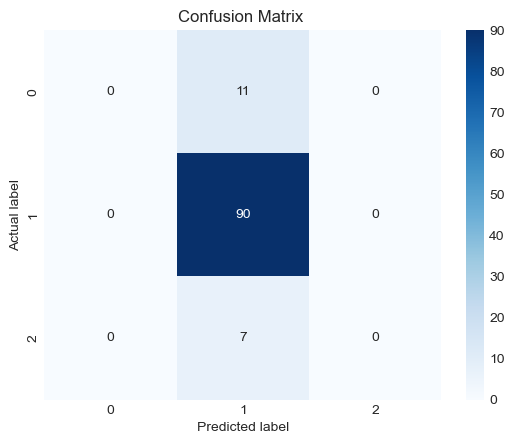

In [ ]:
conf_mat_NN = confusion_matrix(Y_valid_encoded, Y_valid_hat_NN)
sns.heatmap(conf_mat_NN, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

### LSTM

In [ ]:
# Reshape input data for LSTM (assuming 1 time step and input features equal to X_train_scaled.shape[1])
X_train_reshaped = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
X_valid_reshaped = X_valid_scaled.reshape(-1, 1, X_valid_scaled.shape[1])

def create_LSTM_model():
    model = Sequential()
    model.add(LSTM(300, activation="relu", input_shape=(1, X_train_reshaped.shape[2])))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax"))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

LSTM_model = create_LSTM_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
LSTM_history = LSTM_model.fit(X_train_reshaped, Y_train_onehot,
                               epochs=200,
                               batch_size=15,
                               validation_data=(X_valid_reshaped, Y_valid_onehot),
                               callbacks=[early_stopping])


Epoch 1/200


2023-05-02 18:15:23.653240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.2800

2023-05-02 18:15:26.546972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 4s 132ms/step - loss: 1.0986 - accuracy: 0.2800 - val_loss: 1.0790 - val_accuracy: 0.8333
Epoch 2/200
22/22 [==============================] - 1s 49ms/step - loss: 1.0854 - accuracy: 0.4000 - val_loss: 1.0608 - val_accuracy: 0.8333
Epoch 3/200
22/22 [==============================] - 1s 44ms/step - loss: 1.0732 - accuracy: 0.5015 - val_loss: 1.0434 - val_accuracy: 0.8333
Epoch 4/200
22/22 [==============================] - 1s 39ms/step - loss: 1.0605 - accuracy: 0.5569 - val_loss: 1.0250 - val_accuracy: 0.8333
Epoch 5/200
22/22 [==============================] - 1s 39ms/step - loss: 1.0510 - accuracy: 0.5938 - val_loss: 1.0068 - val_accuracy: 0.8333
Epoch 6/200
22/22 [==============================] - 1s 38ms/step - loss: 1.0376 - accuracy: 0.6185 - val_loss: 0.9872 - val_accuracy: 0.8333
Epoch 7/200
22/22 [==============================] - 1s 36ms/step - loss: 1.0255 - accuracy: 0.6400 - val_loss: 0.9663 - val_accuracy: 0.8333
Epoch 8/200
22/22

In [ ]:
Y_train_hat_prob_LSTM = LSTM_model.predict(X_train_reshaped)
Y_train_hat_LSTM = np.argmax(Y_train_hat_prob_LSTM, axis=1)
train_accuracy_LSTM = accuracy_score(Y_train_encoded, Y_train_hat_LSTM) * 100
train_auc_roc_LSTM = roc_auc_score(Y_train_encoded, Y_train_hat_prob_LSTM, multi_class='ovr', average='macro') * 100

print('For in-sample train set:')

print('Accuracy: %.4f %%' % train_accuracy_LSTM)
print('AUC: %.4f %%' % train_auc_roc_LSTM)

print(classification_report(Y_train_encoded, Y_train_hat_LSTM, digits=6))
print(balanced_accuracy_score(Y_train_encoded, Y_train_hat_LSTM))

print('---------------------------------------------------------------')

# Validation

Y_valid_hat_prob_LSTM = LSTM_model.predict(X_valid_reshaped)
Y_valid_hat_LSTM = np.argmax(Y_valid_hat_prob_LSTM, axis=1)
valid_accuracy_LSTM = accuracy_score(Y_valid_encoded, Y_valid_hat_LSTM) * 100
valid_auc_roc_LSTM = roc_auc_score(Y_valid_encoded, Y_valid_hat_prob_LSTM, multi_class='ovr', average='macro') * 100

print('For validation set:')

print('Accuracy: %.4f %%' % valid_accuracy_LSTM)
print('AUC: %.4f %%' % valid_auc_roc_LSTM)

print(classification_report(Y_valid_encoded, Y_valid_hat_LSTM, digits=6))
print(balanced_accuracy_score(Y_valid_encoded, Y_valid_hat_LSTM))

2023-05-02 18:15:59.233831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


For in-sample train set:
Accuracy: 68.0000 %
AUC: 78.9300 %
              precision    recall  f1-score   support

           0   0.750000  0.260870  0.387097        69
           1   0.676806  0.931937  0.784141       191
           2   0.657895  0.384615  0.485437        65

    accuracy                       0.680000       325
   macro avg   0.694900  0.525807  0.552225       325
weighted avg   0.688563  0.680000  0.640105       325

0.5258073742025483
---------------------------------------------------------------
For validation set:
Accuracy: 83.3333 %
AUC: 62.6618 %
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        11
           1   0.833333  1.000000  0.909091        90
           2   0.000000  0.000000  0.000000         7

    accuracy                       0.833333       108
   macro avg   0.277778  0.333333  0.303030       108
weighted avg   0.694444  0.833333  0.757576       108

0.3333333333333333


/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tyz/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


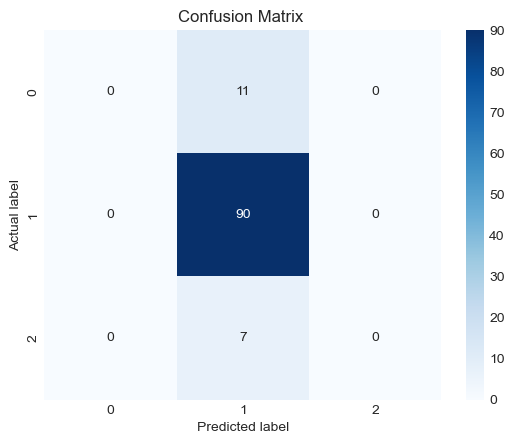

In [ ]:
conf_mat_LSTM = confusion_matrix(Y_valid_encoded, Y_valid_hat_LSTM)
sns.heatmap(conf_mat_LSTM, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix ')
plt.show()

# Optimal Models